<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
def scatter_plot(x, y, x_label, y_label):
    plt.figure(figsize=(10,10))
    plt.scatter(x=x, y=y)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title('Plot of {} vs {}' .format(x_label, y_label), fontsize=15)
    return plt.show

def hist_plot(x, x_label, bins=10):
    plt.figure(figsize=(10,6))
    plt.hist(x=x, bins=bins)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of {}' .format(x_label), fontsize=15)
    return plt.show

<font color='blue'>

## 1.1 EDA

In [4]:
house.shape

(1460, 81)

<font color='blue'>

### 1.1.1  Remove Non-Residential Houses from Dataset

In [5]:
#Look at the zoning calssifications in the dataset
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
#Remove non residential (C (all)) category from the dataset
house.drop(house[house['MSZoning'] == 'C (all)'].index, axis=0, inplace=True)

house.reset_index(drop=True, inplace=True)

<font color='blue'>

### 1.1.2  Clean-up Null Values

In [7]:
#Look at columns with null values
house.isnull().sum()[house.isnull().sum()!=0].sort_values(ascending=False)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageYrBlt       79
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [8]:
#Impute 'None' for 'No Pool' category instead of NaN.
house.PoolQC.fillna('None', inplace=True)

#Impute 'None' for 'No MiscFeature' category instead of NaN.
house.MiscFeature.fillna('None', inplace=True)

#Impute 'None' for 'No alley access' category instead of NaN.
house.Alley.fillna('None', inplace=True)

#Impute 'None' for 'No Fence' category instead of NaN.
house.Fence.fillna('None', inplace=True)

#Impute 'None' for 'No Fireplace' category instead of NaN.
house.FireplaceQu.fillna('None', inplace=True)

#Impute 0 for houses with no LotFrontage instead of NaN.
house.LotFrontage.fillna(0, inplace=True)

#Impute 'None' for 'No Garage' category instead of NaN.
house.GarageCond.fillna('None', inplace=True)
house.GarageQual.fillna('None', inplace=True)
house.GarageFinish.fillna('None', inplace=True)
house.GarageType.fillna('None', inplace=True)

#Impute 2011 for 'No Garage' year built feature instead of NaN.
house.GarageYrBlt.fillna(2011, inplace=True)

#Impute 'None' for 'No Basement' category instead of NaN.
house.BsmtFinType2.fillna('None', inplace=True)
house.BsmtExposure.fillna('None', inplace=True)
house.BsmtFinType1.fillna('None', inplace=True)
house.BsmtCond.fillna('None', inplace=True)
house.BsmtQual.fillna('None', inplace=True)

#Impute 0 and 'None' for houses with no Masonry.
house.MasVnrArea.fillna(0, inplace=True)
house.MasVnrType.fillna('None', inplace=True)


In [9]:
#For the unit with missing 'Electrical' value, let's impute with the most common 'Electrical' value 
#for properties with the same 'MSSubClass', 'MsZoning', 'BldgType', 'HouseStyle'

In [10]:
house[house.Electrical.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1369,1380,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,None,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,167500


In [11]:
house.groupby(['MSSubClass', 'MSZoning', 'BldgType', 'HouseStyle'])['Electrical'].describe().loc[80]

,,,count,unique,top,freq
MSZoning,BldgType,HouseStyle,,,,
RL,1Fam,SLvl,57,2,SBrkr,56


In [12]:
#Impute 'SBrkr' for the 'Electrical' value for the row with NaN
house.Electrical.fillna('SBrkr', inplace=True)

<font color='blue'>

### 1.1.3  Categorize Features by Cetegorical, Quantitative, Time, Non-renovatable and Renovatable

In [13]:
#Target Feature
target = ['SalePrice']

#Cateogorical Features
cat_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 
                'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
                'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
                'MiscFeature', 'SaleType', 'SaleCondition']

#Quantitative Features
quant_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
                  'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
                  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                  'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

#Time Features
time_features = ['MoSold', 'YrSold']



#Non-renovatable House Characteristics/ Features
fixed_char = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig',
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
              'RoofStyle', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF',
              '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
              'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature',
              'MiscVal', 'SaleType', 'SaleCondition']

#Renovatable House Characteristics/ Features
reno_char = ['Street', 'Alley', 'Utilities', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofMatl', 'Exterior1st',
             'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 
             'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
             'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence']

#Fixed and Categorical Features
fixed_cat = list(set(fixed_char).intersection(cat_features))

#Fixed and Quantitaive Features
fixed_quant = [feature for feature in fixed_char if feature not in fixed_cat]

In [14]:
#Convert Year Built to be the age of the house (from year 2010)
house['YearBuilt'] = house['YearBuilt'].apply(lambda x: 2010-x)

#Convert Year YearRemodAdd to be the years since remodeled (from year 2010)
house['YearRemodAdd'] = house['YearRemodAdd'].apply(lambda x: 2010-x)

#Convert GarageYrBlt to be the years garage was built (from year 2010)
house['GarageYrBlt'] = house['GarageYrBlt'].apply(lambda x: 2010-x)

In [15]:
#convert datatype of categorical variables to object type
house[cat_features] = house[cat_features].astype(str)

<font color='blue'>

### 1.1.4  Explore the Non-renovatable (Quantitative) Features

In [16]:
house[fixed_quant].describe()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,57.54000,10523.831724,38.406897,103.828276,1059.408966,1164.773103,347.394483,1517.698621,0.427586,0.057241,1.568966,0.384828,2.870345,1.046207,6.522069,0.616552,29.608966,1.770345,473.277931,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517
std,34.71992,10012.185355,30.022696,181.150114,439.207322,386.646095,437.094261,525.154207,0.519394,0.238249,0.549549,0.503450,0.814645,0.219643,1.625324,0.644991,25.017086,0.745136,212.687621,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495
min,0.00000,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.25000,7544.500000,9.000000,0.000000,796.000000,882.500000,0.000000,1131.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,7.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.00000,9496.000000,37.000000,0.000000,992.000000,1088.000000,0.000000,1466.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,25.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,79.00000,11613.500000,56.000000,166.000000,1301.500000,1392.000000,728.000000,1779.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,48.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.00000,215245.000000,138.000000,1600.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,104.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


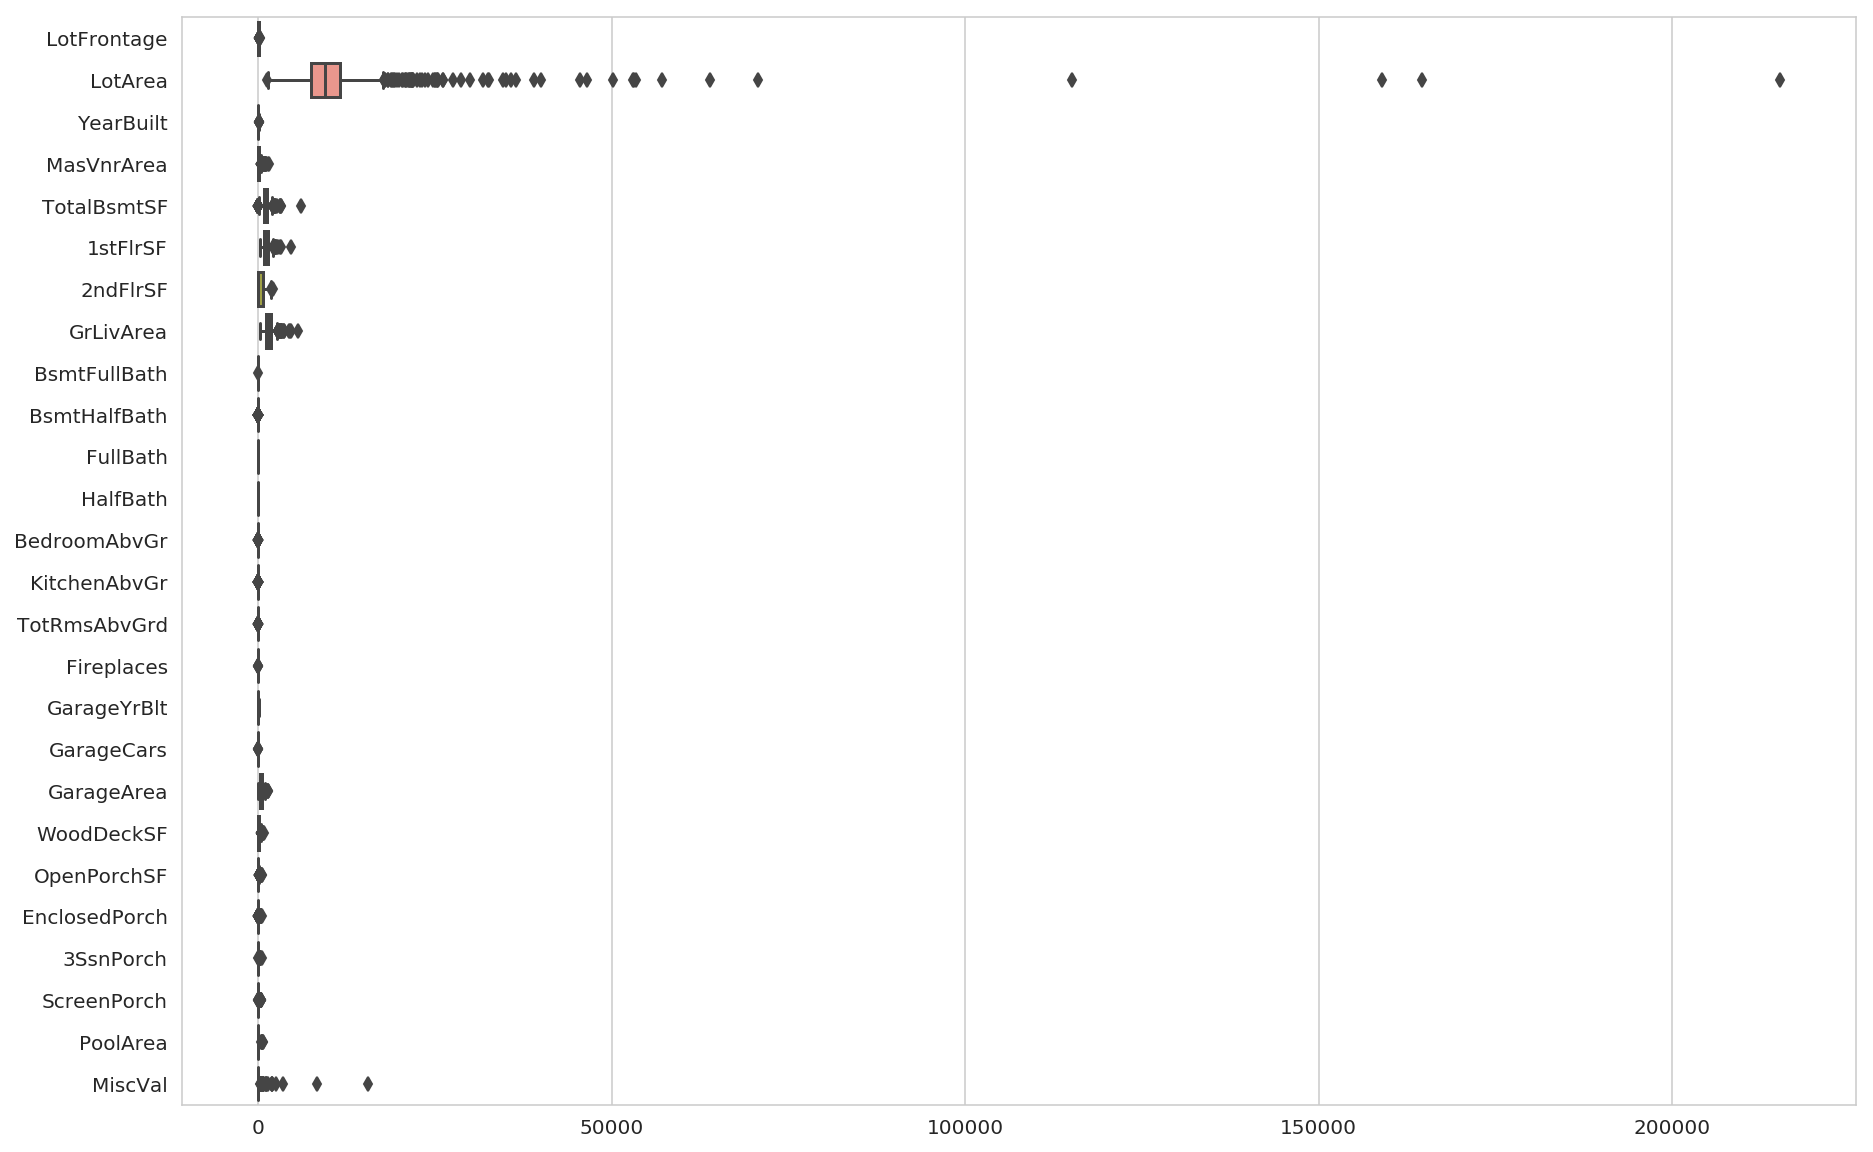

In [17]:
#Boxplot of the Non-renovatable (quantitative) Features

plt.figure(figsize=(15,10))
sns.boxplot(data=house[fixed_quant], orient='h')

plt.show()

<font color='blue'>

Observation:  Scale and outliers of LotArea skewing the distribution.

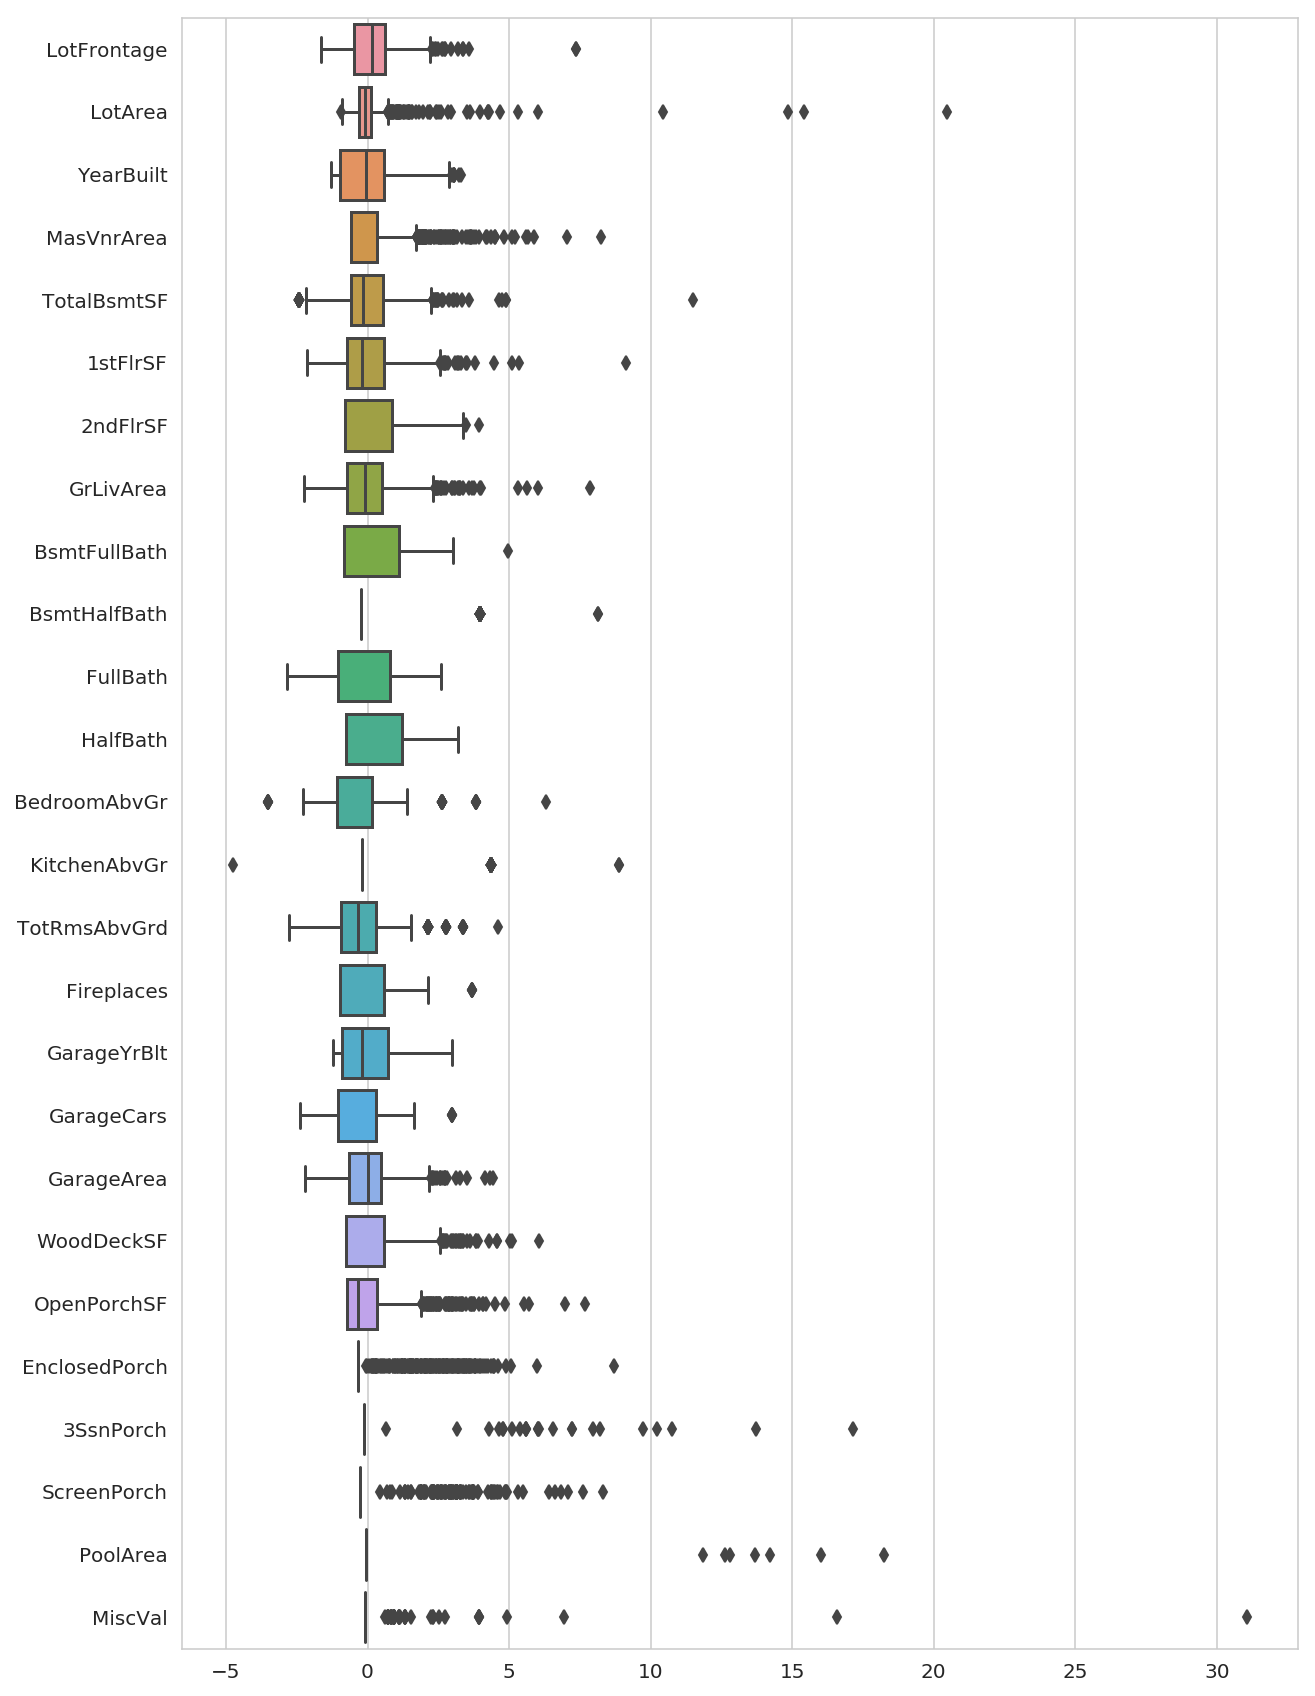

In [18]:
#Boxplot of the Standardized Non-renovatable (quantitative) Features

#Standardize the variables
ss = StandardScaler()
fixed_quant_std = pd.DataFrame(ss.fit_transform(house[fixed_quant]), columns=fixed_quant)

#Plot the variables
plt.figure(figsize=(10,15))
sns.boxplot(data=fixed_quant_std, orient='h')

plt.show()


<font color='blue'>

Observation:  Still some outliers in the data, but we will ignore them for now.

<font color='blue'>

## 1.2 Modeling

<font color='blue'>

### 1.2.1  Predict Target (Sale Price) Using Top 10 Most Correlated Non-renovatable Features

<font color='blue'>

#### 1.2.1.1 Identify Top 10 Most Correlated Non-renovatable Features to Sale Price

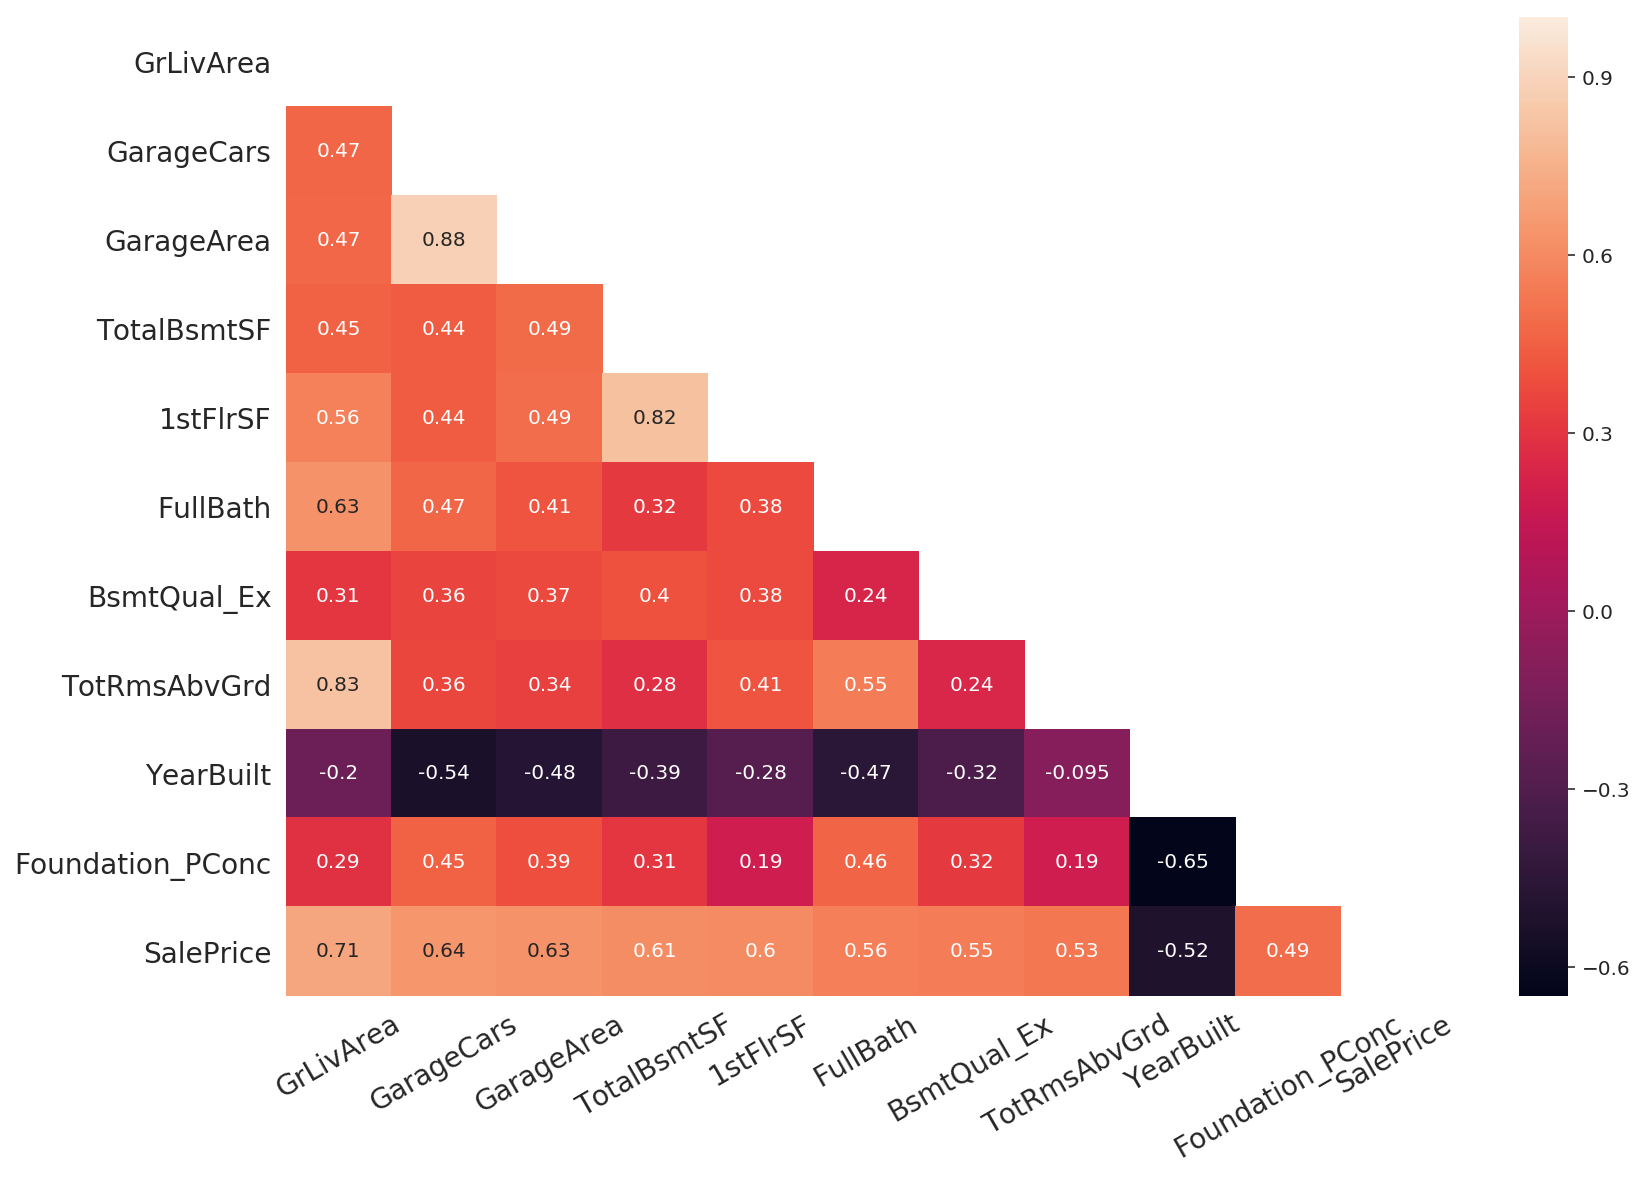

In [19]:
#Convert the categorical variables in fixed_cat to dummy varilables
fixed_cat_dummy = pd.get_dummies(house[fixed_cat], prefix=fixed_cat, drop_first=False)

#Concat the fixed_cat_dummy df with fixed_quant df
fixed_char_dummy = pd.concat([fixed_cat_dummy, house[fixed_quant]], axis=1)

#Identify top 10 most correlated (abs) non-renovatable features to Sale Price
top10_corr = pd.concat([fixed_char_dummy, house['SalePrice']], axis=1).corr()['SalePrice'].abs().sort_values()[::-1].index[1:11].values

#Plot heatmap of top 10 correlated features to Sale Price
fig, ax = plt.subplots(figsize=(13,9))

#Generate a mask for the upper triangle
mask = np.zeros_like(pd.concat([fixed_char_dummy[top10_corr], house['SalePrice']], axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(pd.concat([fixed_char_dummy[top10_corr], house['SalePrice']], axis=1).corr(), mask=mask, annot=True)

#Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

<font color='blue'>

Observation:  From the Heatmap, we can see that there are very strong inter-correlation (>0.8) between the following predictor pairs:
    1. TotRmsAbvGrd - GrLivArea
    2. GarageArea - GarageCars
    3. 1stFlrSF - TotalBsmtSF
    
Let's replace TotRmsAbvGrd, GarageCars and TotalBsmtSF with the 11-13 top correlated features.

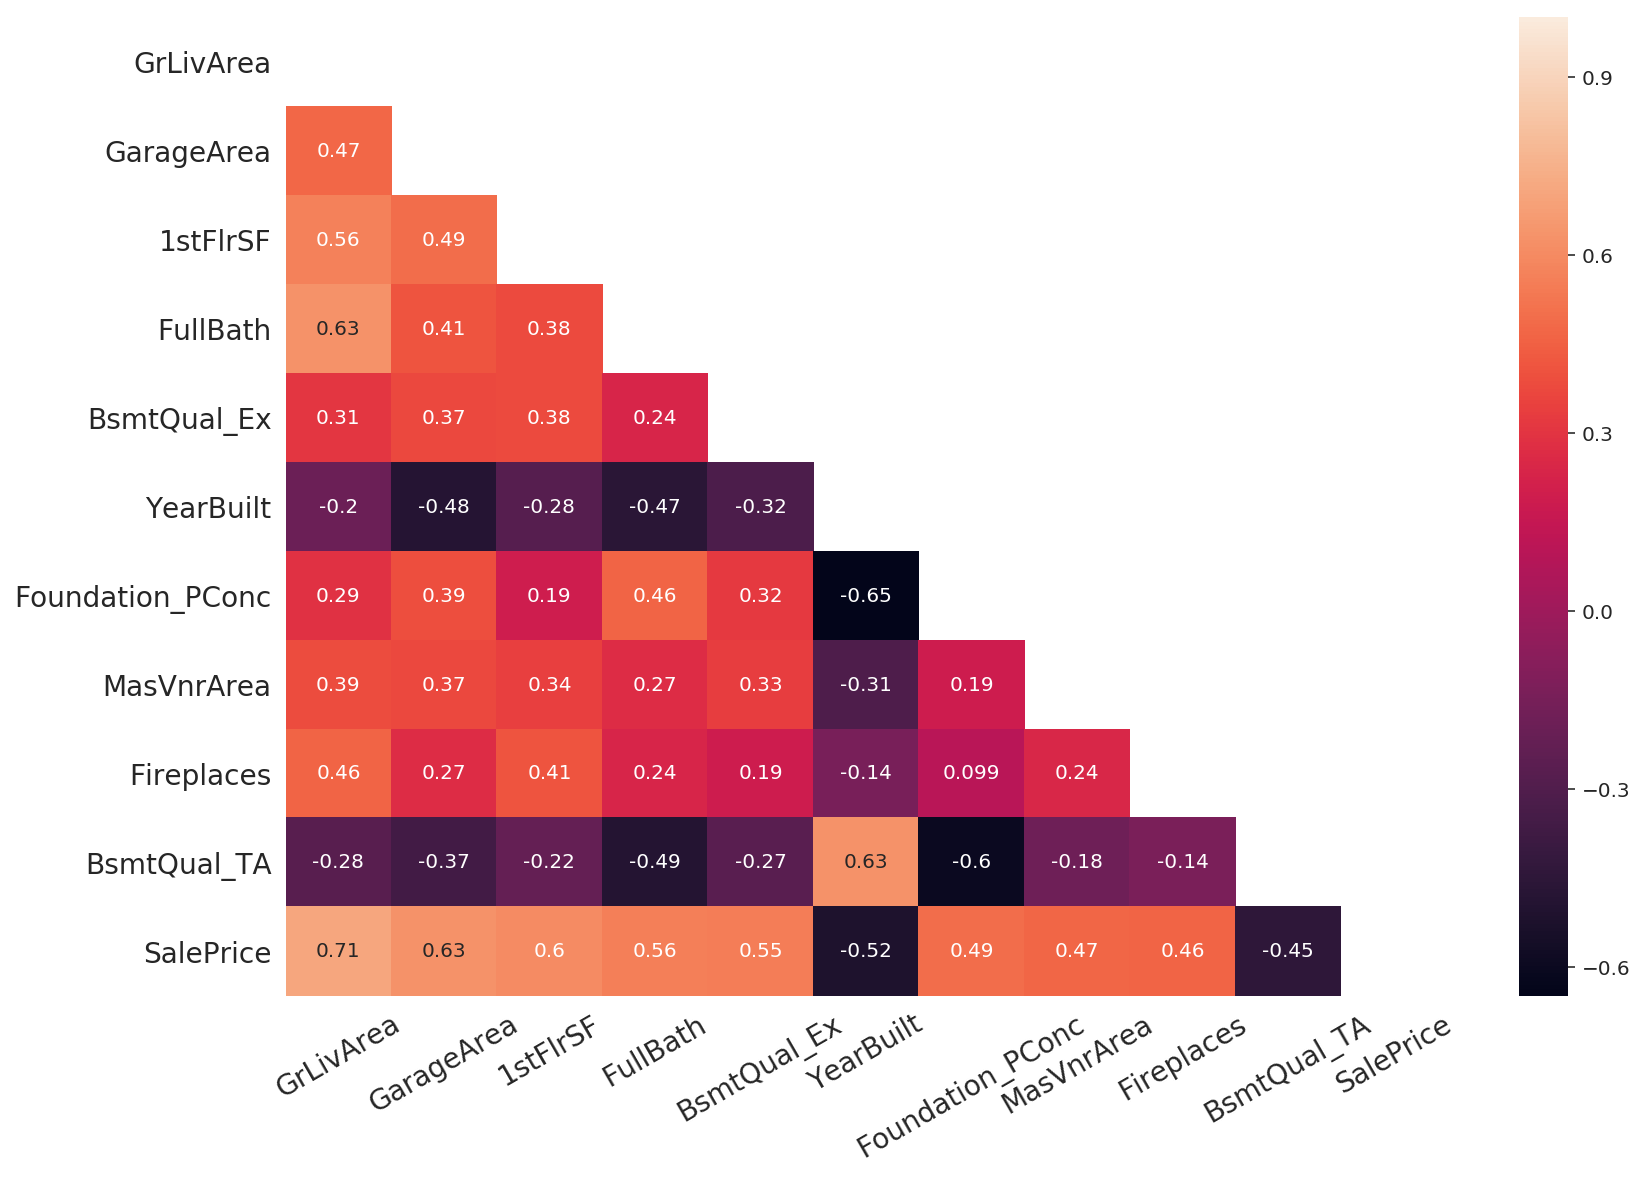

In [20]:
#Replace TotRmsAbvGrd, GarageCars and TotalBsmtSF with 11-13 top correlated features.
remove = ['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF']
top10_corr_new = [f for f in top10_corr if f not in remove] + list(pd.concat([fixed_char_dummy, house['SalePrice']], axis=1).corr()['SalePrice'].abs().sort_values()[::-1].index[11:14].values)

#Plot heatmap of top 10 correlated features to Sale Price
fig, ax = plt.subplots(figsize=(13,9))

#Generate a mask for the upper triangle
mask = np.zeros_like(pd.concat([fixed_char_dummy[top10_corr_new], house['SalePrice']], axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(pd.concat([fixed_char_dummy[top10_corr_new], house['SalePrice']], axis=1).corr(), mask=mask, annot=True)

#Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

<font color='blue'>

Observation:  Correlation betweeen features has been reduced.

<font color='blue'>

#### 1.2.1.2 Look at Scatter Plot Between Top 10 Correlated Features with Target

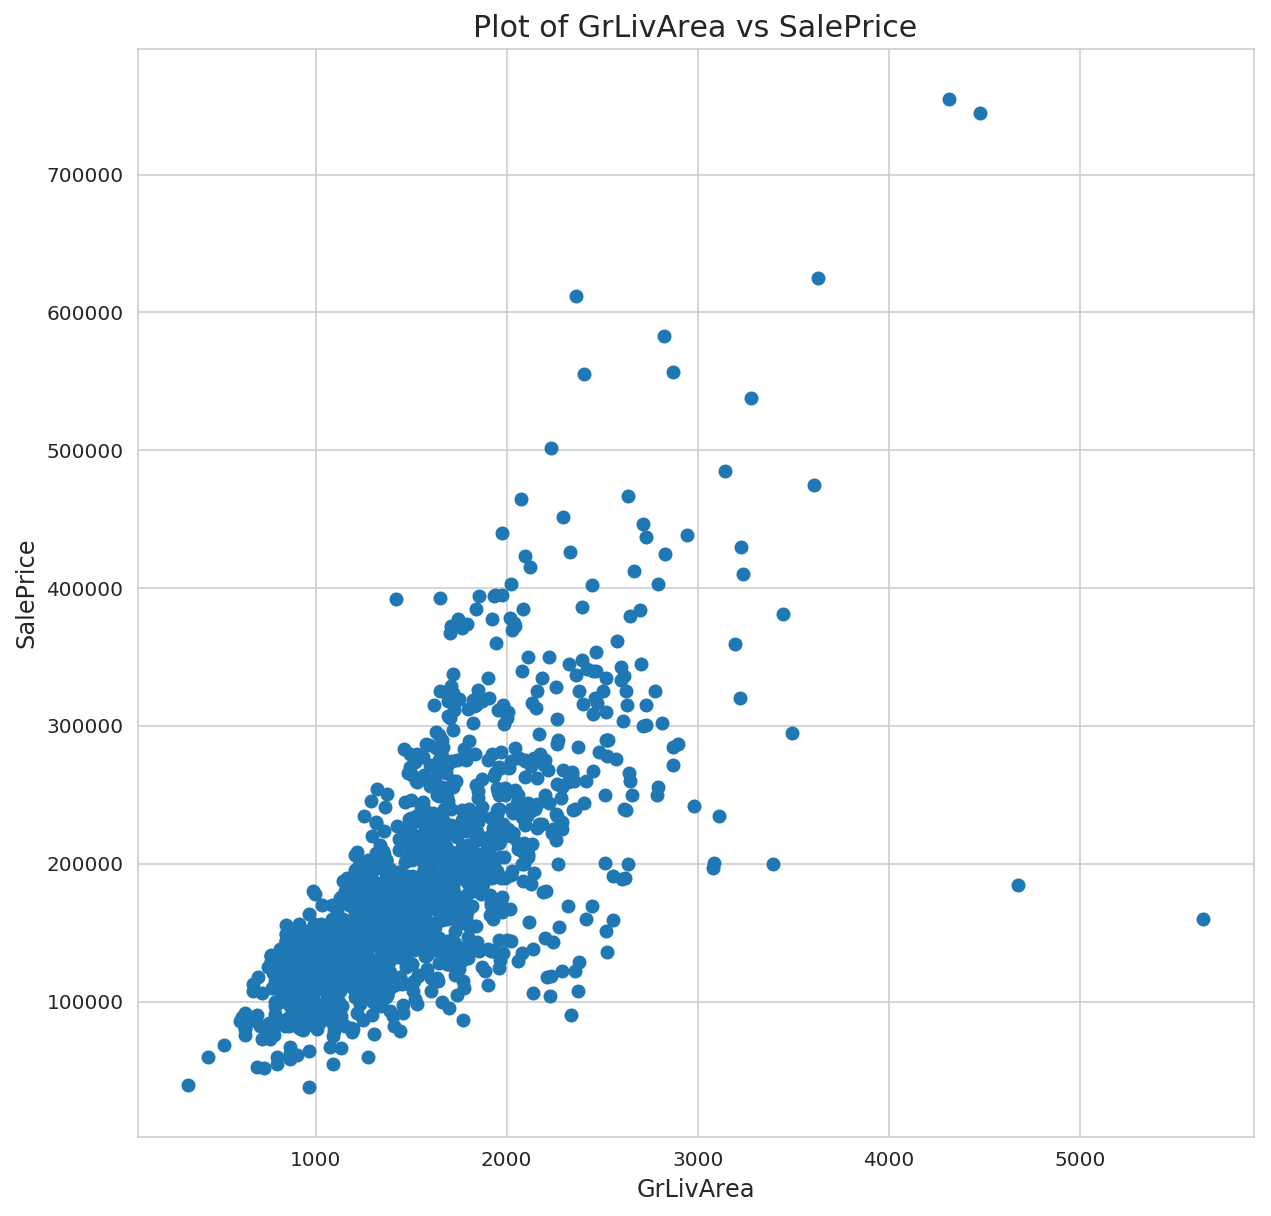

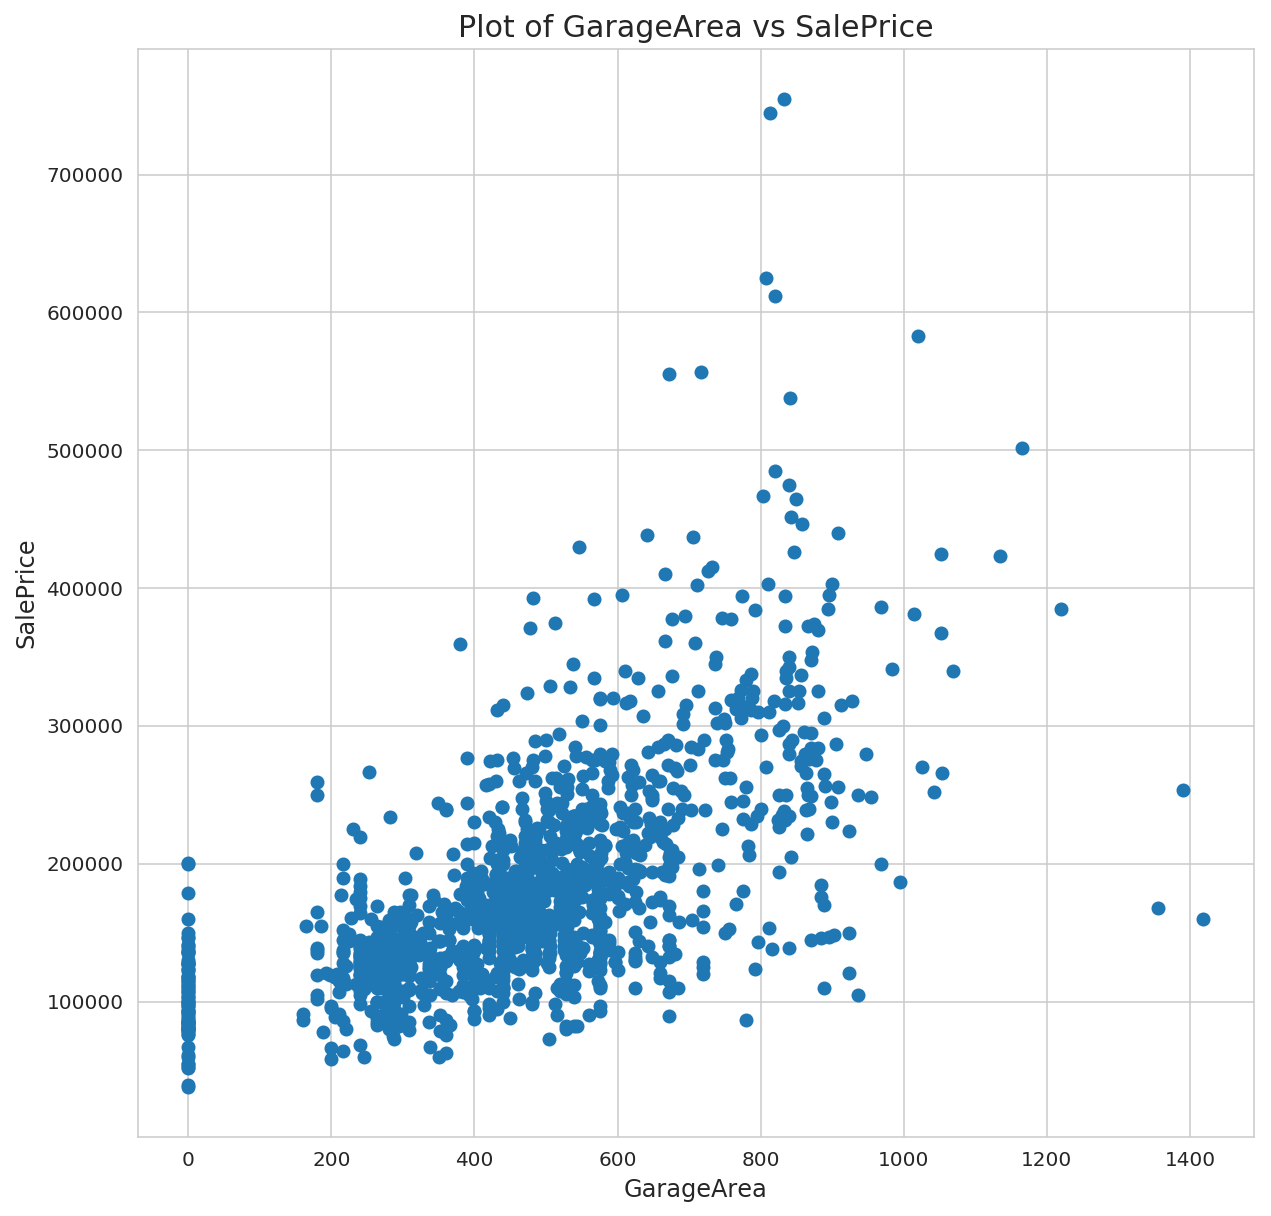

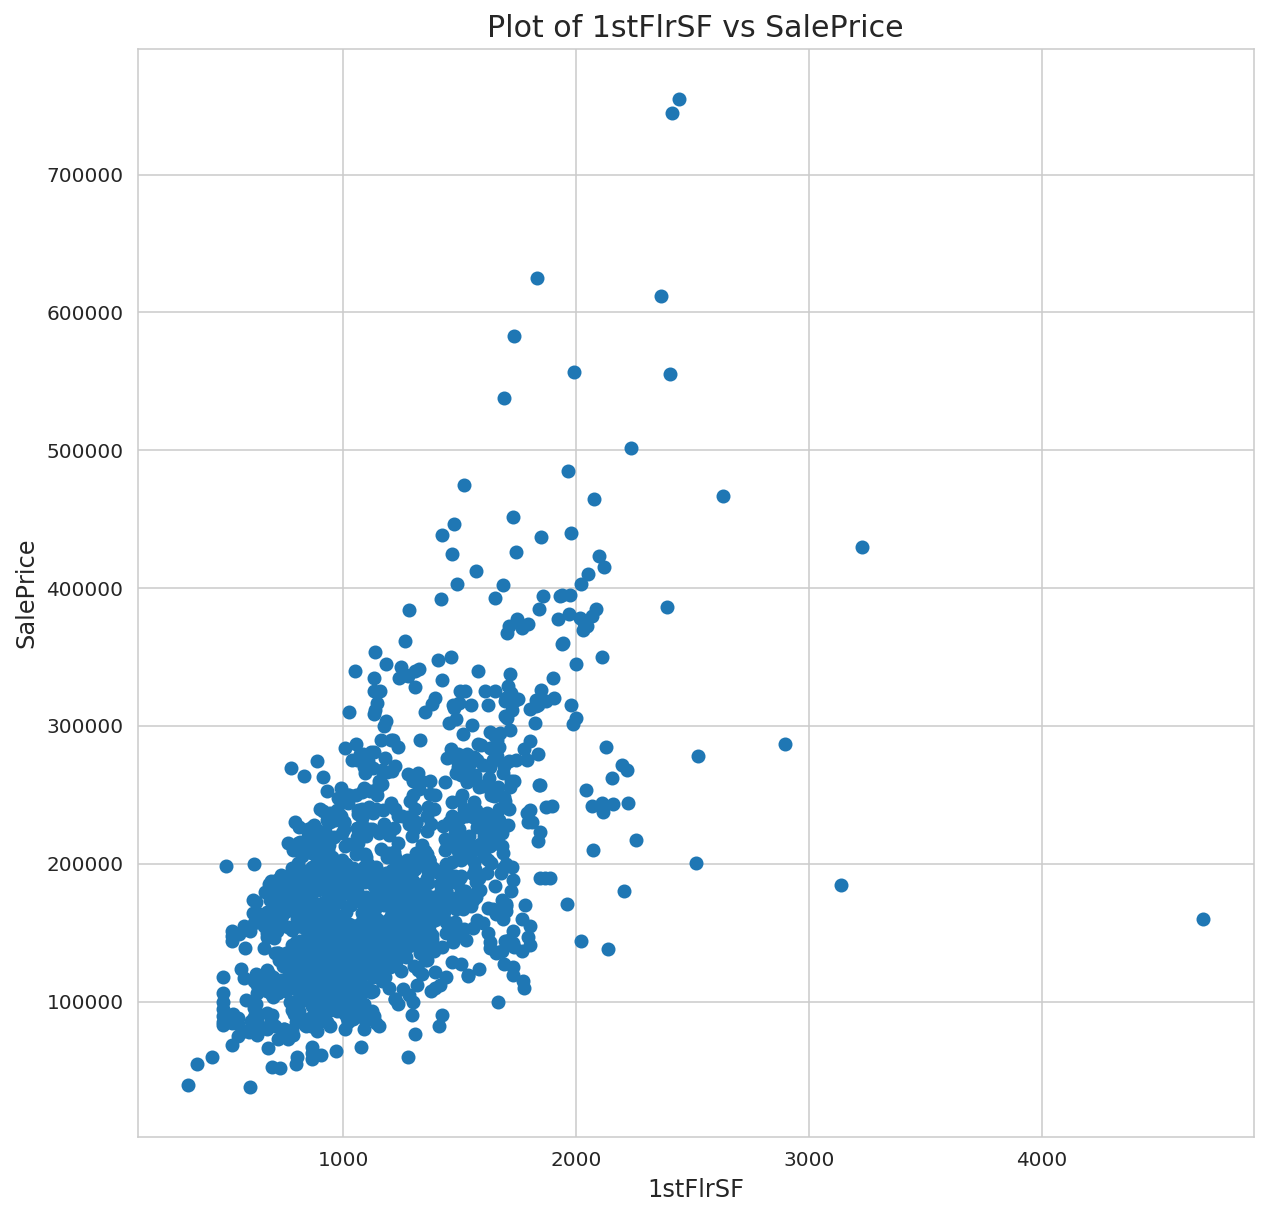

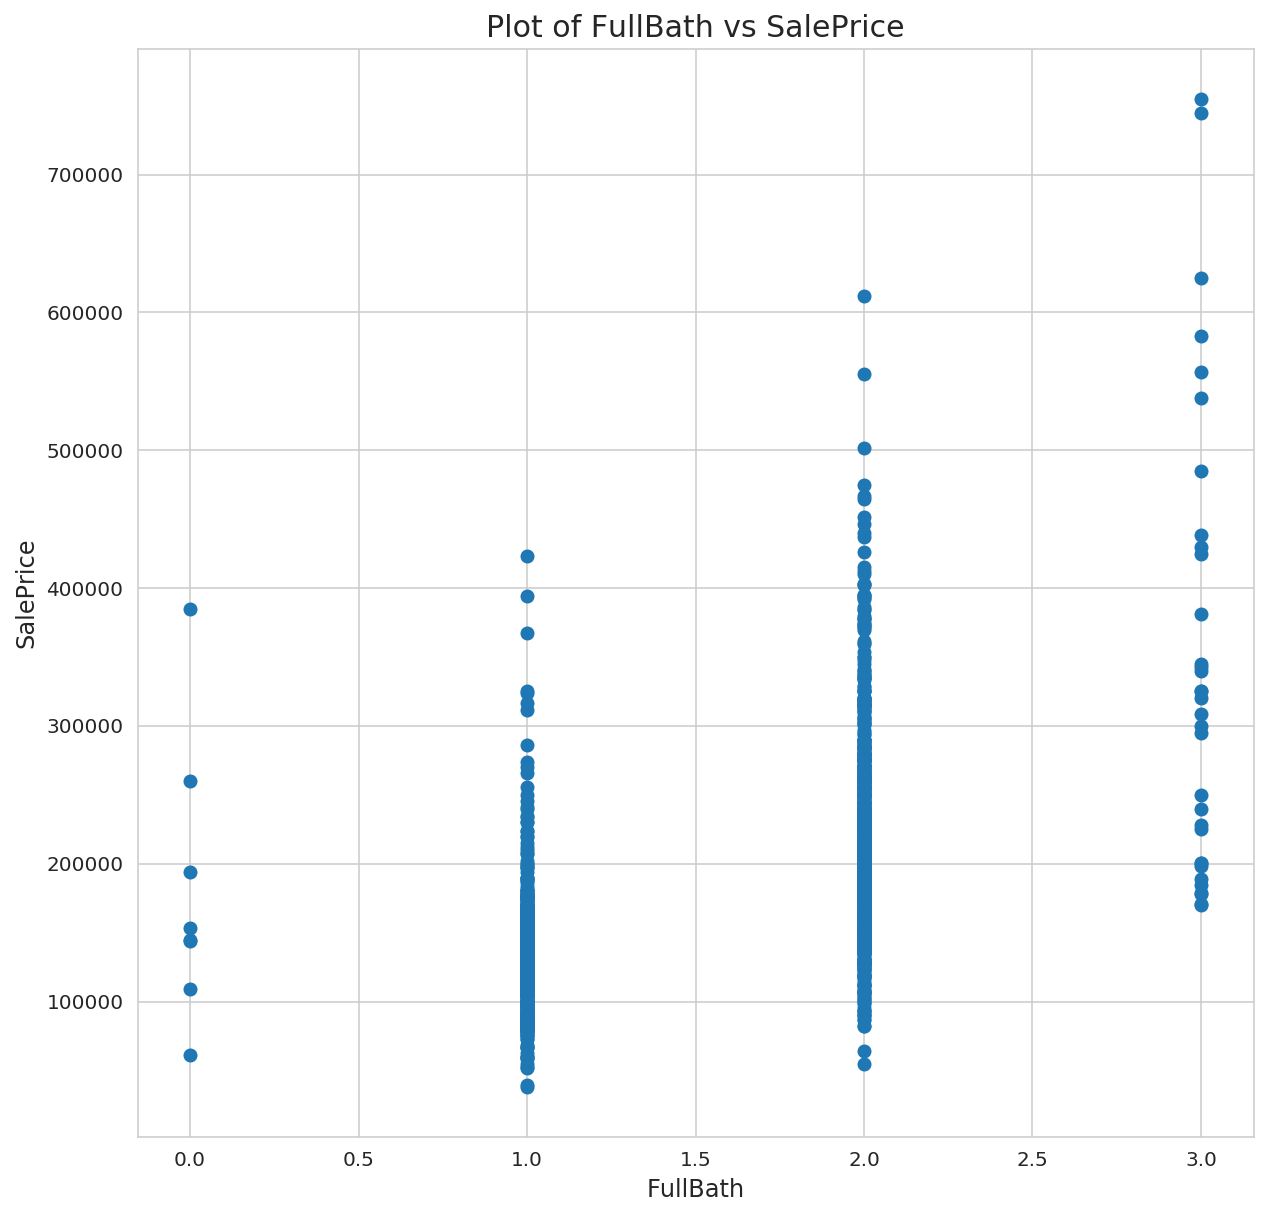

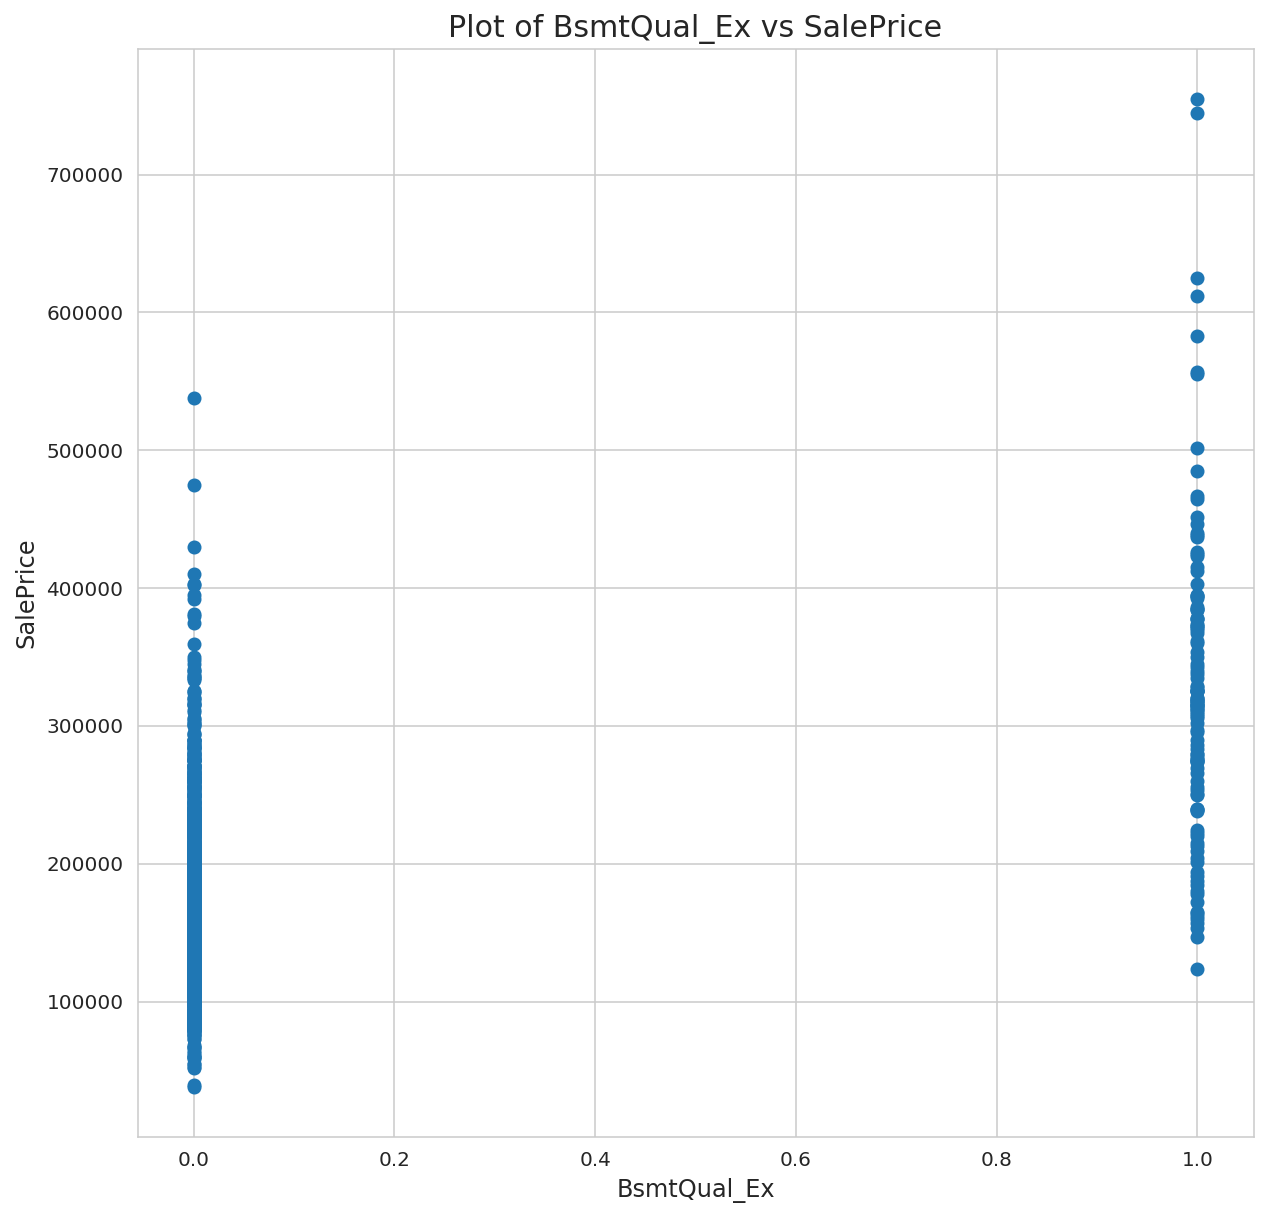

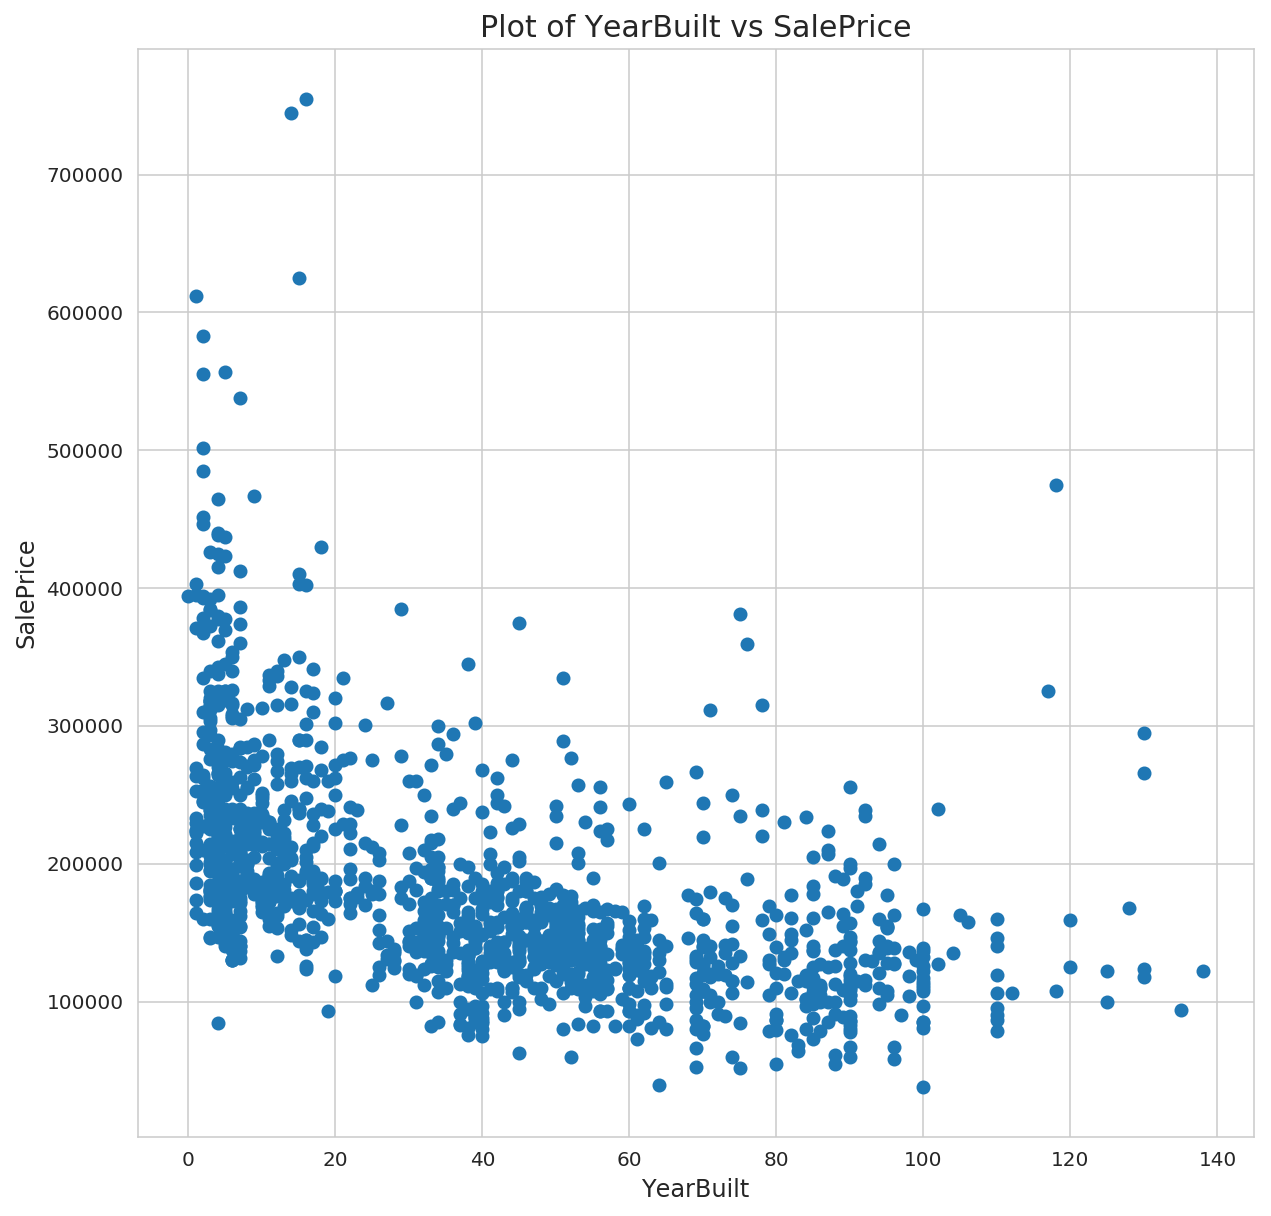

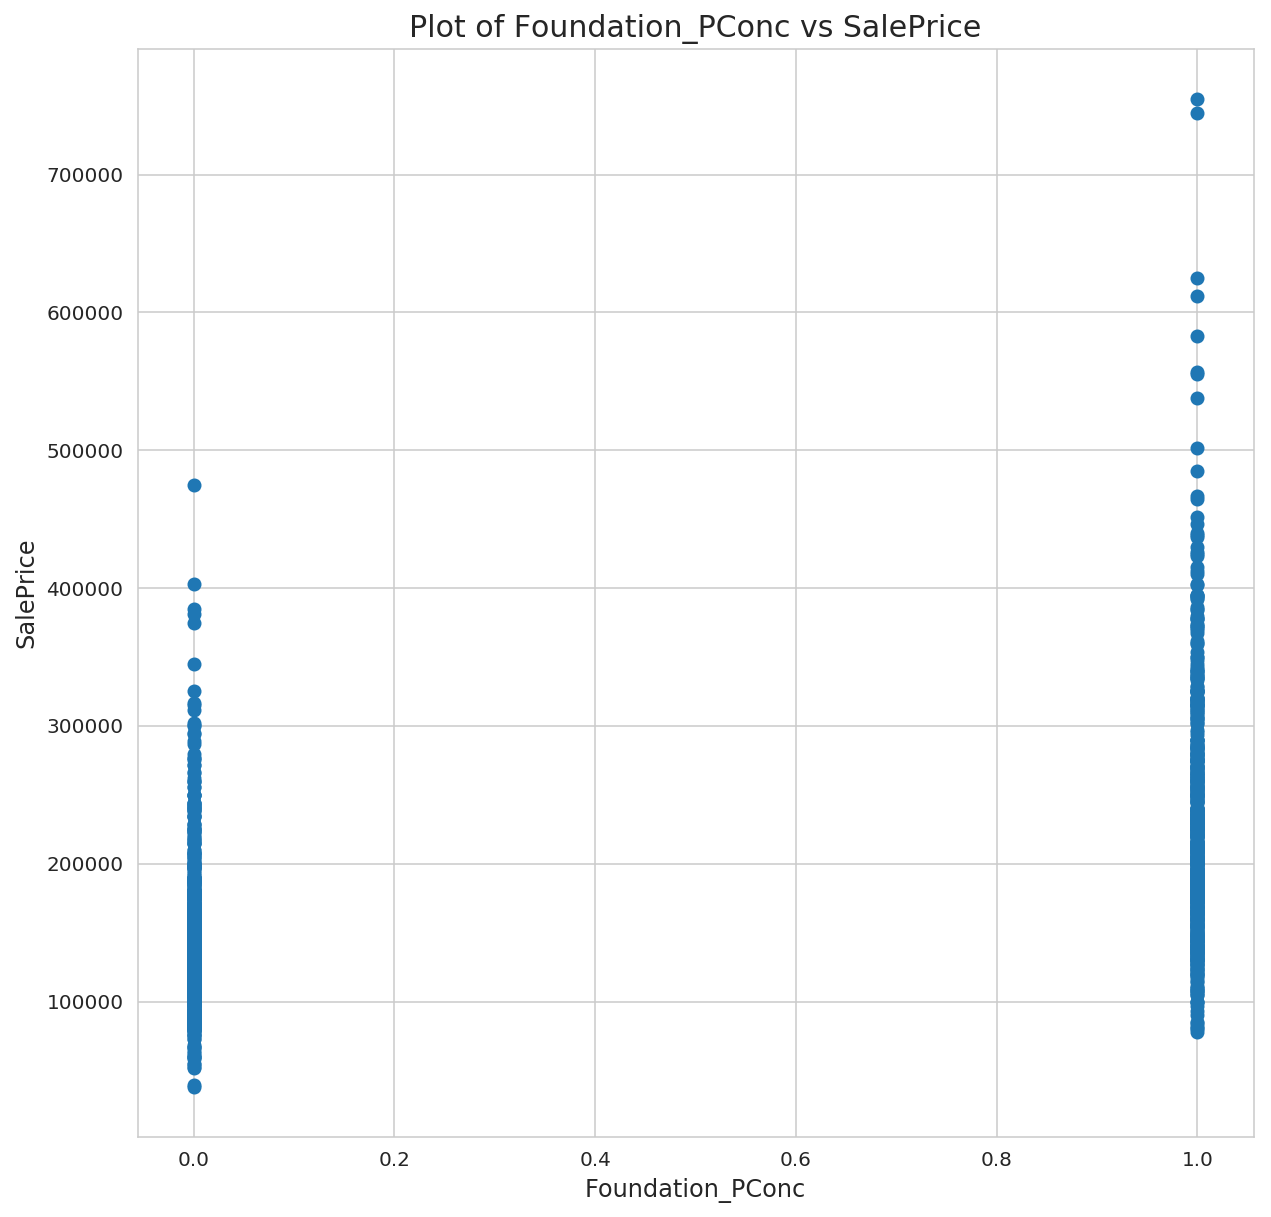

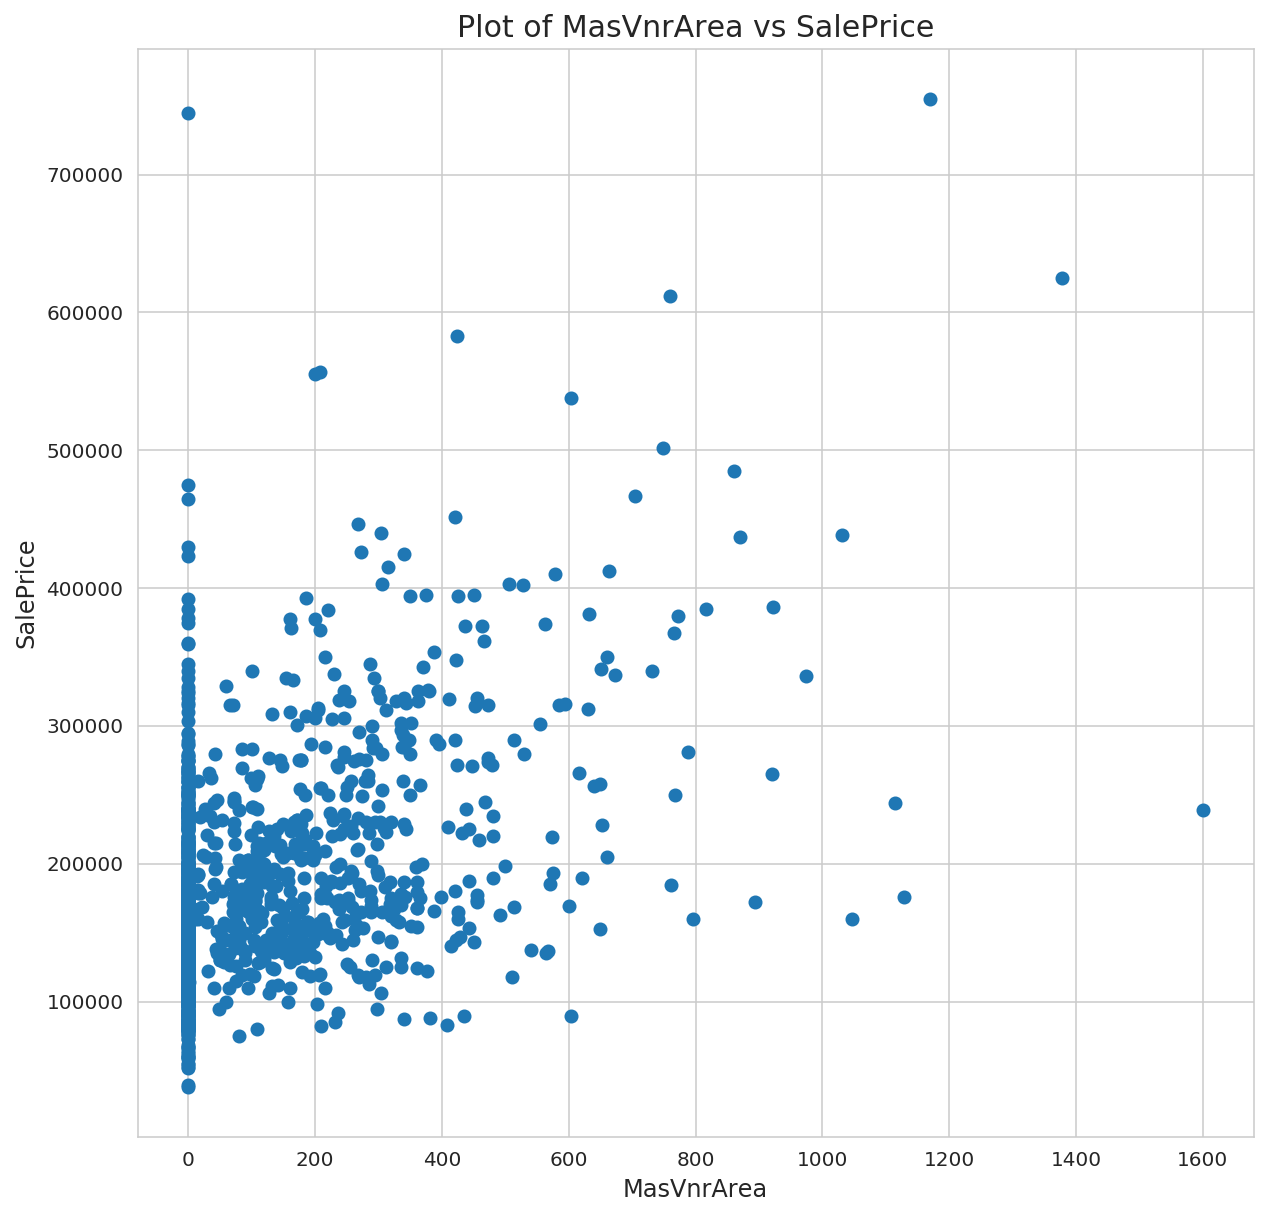

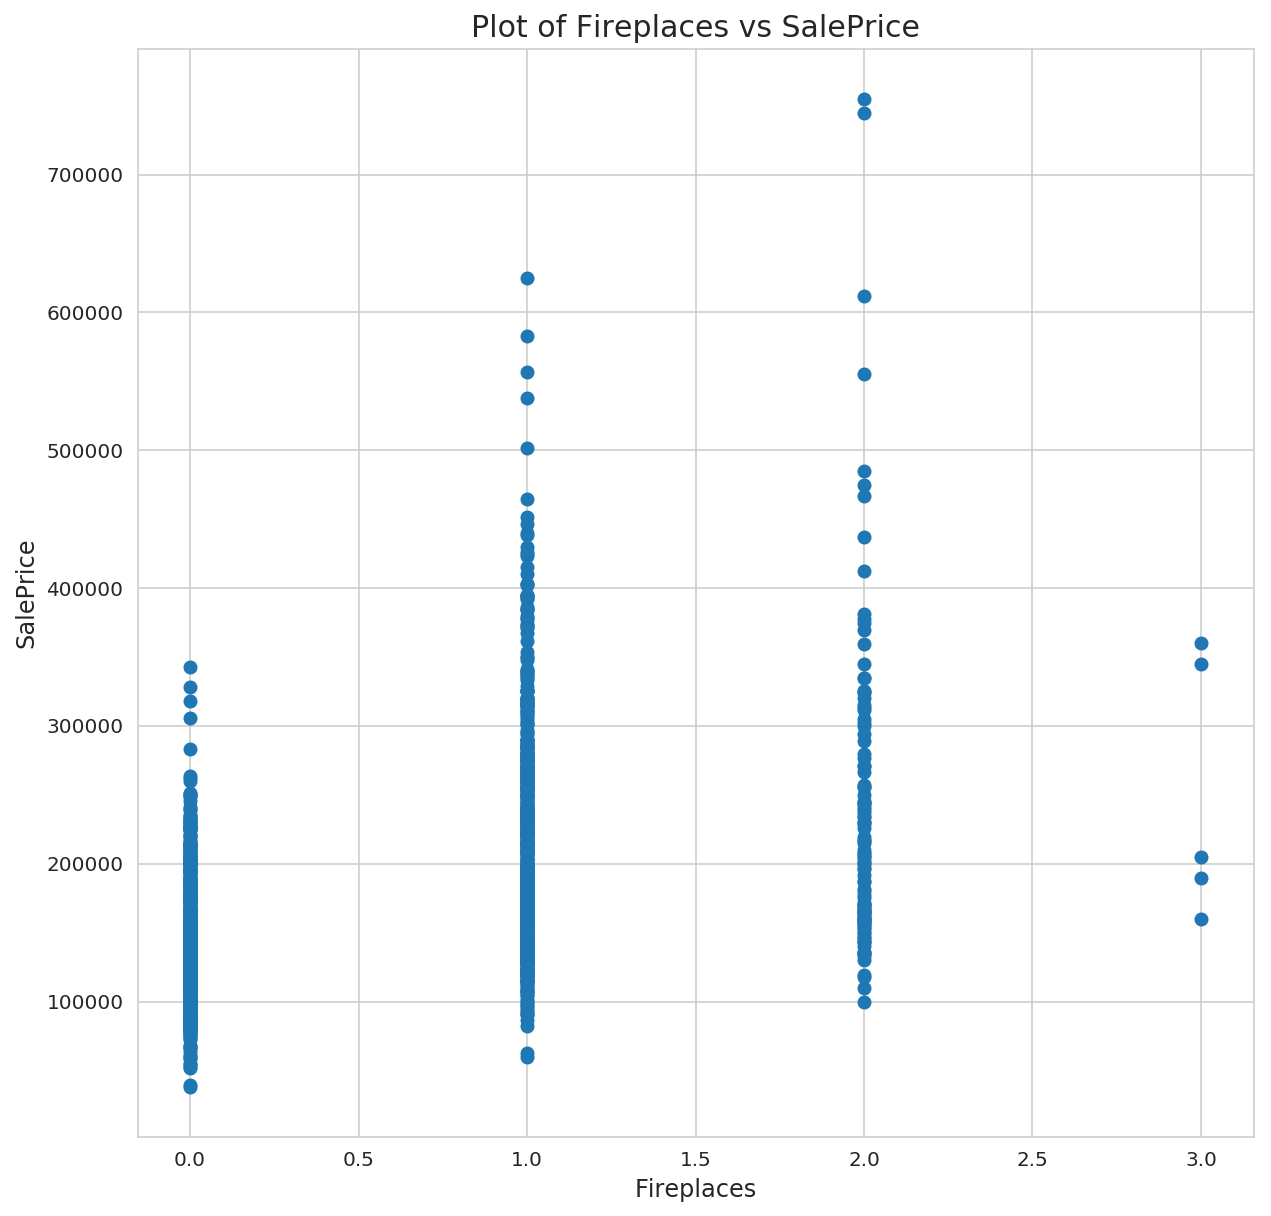

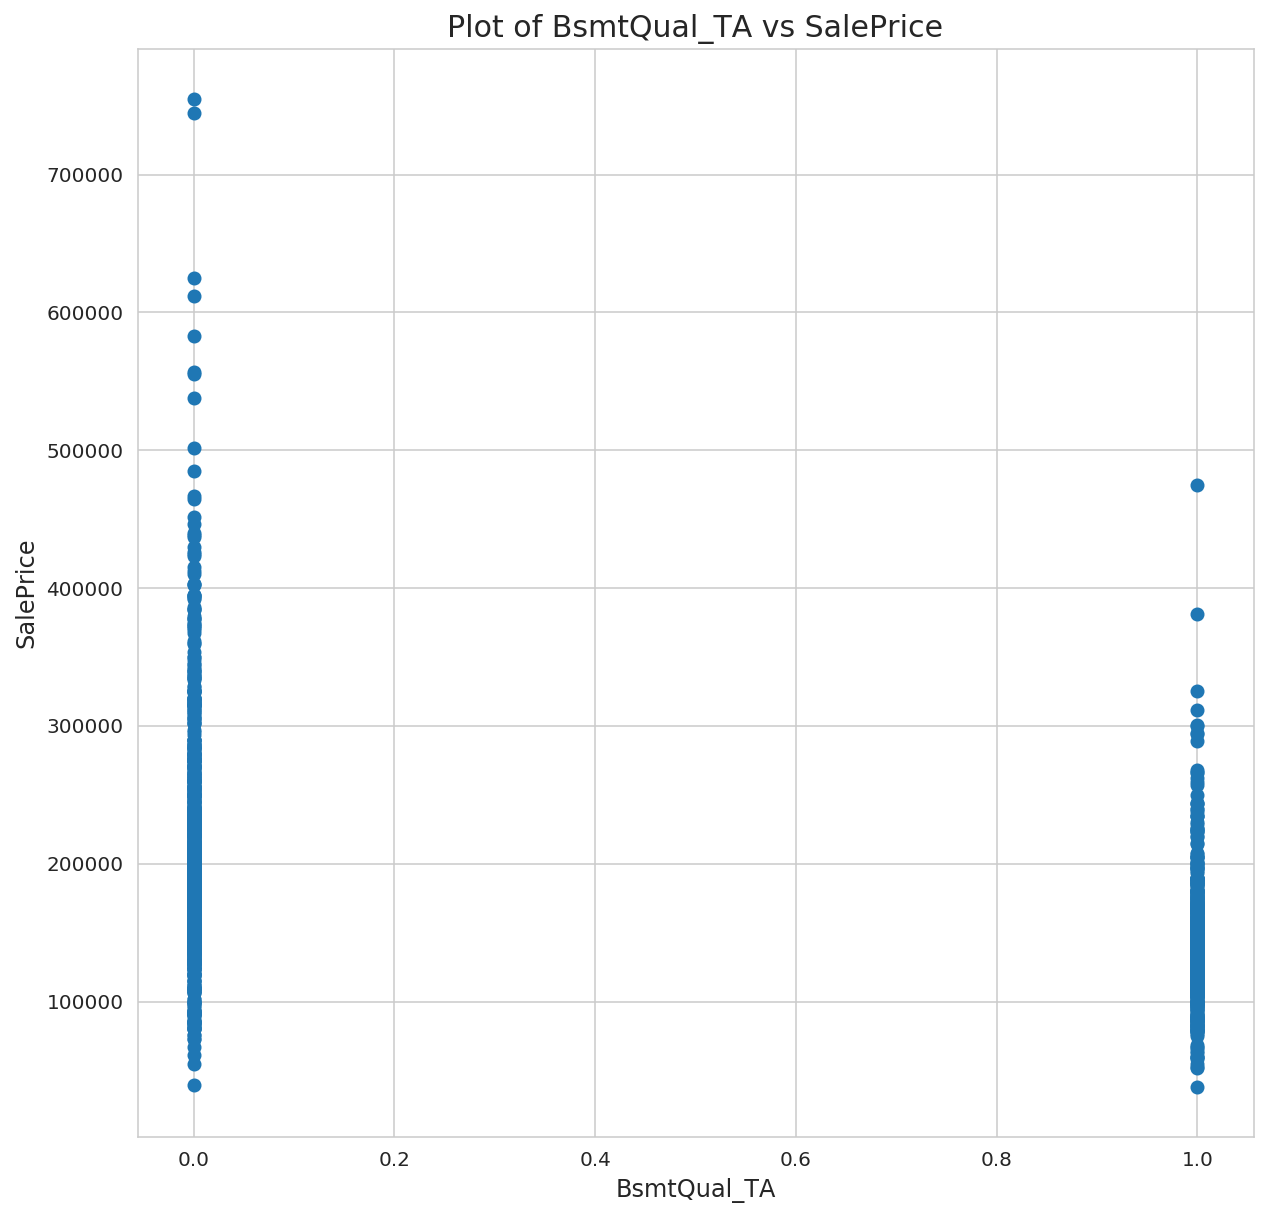

In [21]:
for x in top10_corr_new:
    scatter_plot(fixed_char_dummy[x], house[target], x, 'SalePrice')

<font color='blue'>

Observation: The plots do show agree with the correlation heatmap in terms of general correlation. However, some of the correlations may not be linear.

<font color='blue'>

#### 1.2.1.3 Data Preparation for Modeling

In [22]:
y = house[target]

#Categorical Features
X_fixed_cat = fixed_cat_dummy

#Quantitaive Features
X_fixed_quant = house[fixed_quant]

#Standardize the quantitative predictor variables
ss = StandardScaler()
Xs_fixed_quant = pd.DataFrame(ss.fit_transform(X_fixed_quant))

#Combine the Categorical and Quantitative Variables and extract the top 10 correlated variables
Xs = pd.concat([X_fixed_cat, X_fixed_quant], axis=1)
Xs_top10 = Xs[top10_corr_new]

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train = Xs_top10.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test = Xs_top10.iloc[index_2010,:]
y_test = y.iloc[index_2010]

<font color='blue'>

#### 1.2.1.4 Linear Regression

In [23]:
lr = LinearRegression()

lr10_cv_scores = cross_val_score(lr, X_train, y_train, cv=10)
lr10_mean_cv_score = np.mean(lr10_cv_scores)
lr10_std_cv_score = np.std(lr10_cv_scores)

model = lr.fit(X_train, y_train)
lr10_test_score =  model.score(X_test, y_test)
lr10_mse = mean_squared_error(y_test, model.predict(X_test))

print("CV scores: {}" .format(lr10_cv_scores))
print("Mean CV score: {}" .format(lr10_mean_cv_score))
print("CV Score STD: {}" .format(lr10_std_cv_score))
print("Score on Test Set: {}" .format(lr10_test_score))
print("Mean Squared Error: {}" .format(lr10_mse))

CV scores: [0.80169322 0.80445445 0.82695249 0.64078414 0.77240857 0.78316895
 0.81577991 0.7763709  0.51778188 0.80272518]
Mean CV score: 0.7542119689603302
CV Score STD: 0.0930805048208265
Score on Test Set: 0.7901640234525957
Mean Squared Error: 1334011048.9112399


<font color='blue'>

#### 1.2.1.5 Ridge Regression

In [24]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge10_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge10_mean_cv_score = np.mean(ridge10_cv_scores)
ridge10_std_cv_score = np.std(ridge10_cv_scores)

ridge_model = ridge.fit(X_train, y_train)
ridge10_test_score = ridge_model.score(X_test, y_test)
ridge10_mse = mean_squared_error(y_test, ridge_model.predict(X_test))

print("CV scores: {}" .format(ridge10_cv_scores))
print("Mean CV score: {}" .format(ridge10_mean_cv_score))
print("CV Score STD: {}" .format(ridge10_std_cv_score))
print("Score on Test Set: {}" .format(ridge10_test_score))
print("Mean Squared Error: {}" .format(ridge10_mse))

CV scores: [0.80239146 0.80422615 0.82689049 0.64363187 0.7726883  0.7828783
 0.81614697 0.77442046 0.5156616  0.8045561 ]
Mean CV score: 0.7543491714533637
CV Score STD: 0.09337070786529923
Score on Test Set: 0.7901327742491421
Mean Squared Error: 1334209712.569221


<font color='blue'>

#### 1.2.1.6 Lasso Regression

In [25]:
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso10_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso10_mean_cv_score = np.mean(lasso10_cv_scores)
lasso10_std_cv_score = np.std(lasso10_cv_scores)

lasso_model = lasso.fit(X_train, y_train)
lasso10_test_score = lasso_model.score(X_test, y_test)
lasso10_mse = mean_squared_error(y_test, lasso_model.predict(X_test))

print("CV scores: {}" .format(lasso10_cv_scores))
print("Mean CV score: {}" .format(lasso10_mean_cv_score))
print("CV Score STD: {}" .format(lasso10_std_cv_score))
print("Score on Test Set: {}" .format(lasso10_test_score))
print("Mean Squared Error: {}" .format(lasso10_mse))

CV scores: [0.74242231 0.76601553 0.76749202 0.61255488 0.73304961 0.74878729
 0.71308867 0.70202285 0.43630364 0.75484744]
Mean CV score: 0.6976584229961007
CV Score STD: 0.0972093538978545
Score on Test Set: 0.7426875746237493
Mean Squared Error: 1635837782.0712817


<font color='blue'>

#### 1.2.1.7 Elastic Net

In [26]:
#Find optimum l1_ration and Alpha:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(X_train, y_train)

print("Optimal Alpha: {}" .format(optimal_enet.alpha_))
print("Optimal l1 Ratio: {}" .format(optimal_enet.l1_ratio_))
print("-"*40)
print("")

#Compute model scores
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet10_cv_scores = cross_val_score(enet, X_train, y_train, cv=10)
enet10_mean_cv_score = np.mean(enet10_cv_scores)
enet10_std_cv_score = np.std(enet10_cv_scores)

enet_model = enet.fit(X_train, y_train)
enet10_test_score = enet_model.score(X_test, y_test)
enet10_mse = mean_squared_error(y_test, enet_model.predict(X_test))

print("CV scores: {}" .format(enet10_cv_scores))
print("Mean CV score: {}" .format(enet10_mean_cv_score))
print("CV Score STD: {}" .format(enet10_std_cv_score))
print("Score on Test Set: {}" .format(enet10_test_score))
print("Mean Squared Error: {}" .format(enet10_mse))

Optimal Alpha: 29567.727441172483
Optimal l1 Ratio: 1.0
----------------------------------------

CV scores: [0.74242231 0.76601553 0.76749202 0.61255488 0.73304961 0.74878729
 0.71308867 0.70202285 0.43630364 0.75484744]
Mean CV score: 0.6976584229961007
CV Score STD: 0.0972093538978545
Score on Test Set: 0.7426875746237493
Mean Squared Error: 1635837782.0712817


<font color='blue'>

#### 1.2.1.8 Summary of Model Scores with Top 10 Correlated Non-renovatable Features

In [27]:
linreg10 = ['Linear Regression (10)', lr10_mean_cv_score, lr10_std_cv_score, lr10_test_score, lr10_mse]
ridge10 = ['Ridge (10)', ridge10_mean_cv_score, ridge10_std_cv_score, ridge10_test_score, ridge10_mse]
lasso10 = ['Lasso (10)', lasso10_mean_cv_score, lasso10_std_cv_score, lasso10_test_score, lasso10_mse]
enet10 = ['Enet (10)', enet10_mean_cv_score, enet10_std_cv_score, enet10_test_score, enet10_mse]

summary_10 = pd.DataFrame(columns = ['Model', 'Average CV Score', 'CV Score STD', 'Test Score', 
                                     'Mean-squared Error'])

for i, model in enumerate([linreg10, ridge10, lasso10, enet10]):
    summary_10.loc[i,:] = model
    
summary_10.sort_values('Test Score', ascending=False)

,Model,Average CV Score,CV Score STD,Test Score,Mean-squared Error
0,Linear Regression (10),0.754212,0.0930805,0.790164,1.33401e+09
1,Ridge (10),0.754349,0.0933707,0.790133,1.33421e+09
2,Lasso (10),0.697658,0.0972094,0.742688,1.63584e+09
3,Enet (10),0.697658,0.0972094,0.742688,1.63584e+09


<font color='blue'>

Observation: The R2 scores for all models are quite close, with Linear Regression the highest.

<font color='blue'>

### 1.2.2  Predict Target (Sale Price) Using ALL Non-renovatable Features

In [28]:
y = house[target]

X_cat = house[fixed_cat]
X_quant = house[fixed_quant]

#Standardize the quantitative predictor variables
ss = StandardScaler()
Xs_quant = pd.DataFrame(ss.fit_transform(X_quant), columns=fixed_quant)

#Generate dummy variables for the categorical predictor variables
X_cat_dummy = pd.get_dummies(X_cat, columns=fixed_cat, drop_first=True, prefix=fixed_cat)

#Cocat the standardized and dummy predictor variables
Xs = pd.concat([Xs_quant, X_cat_dummy], axis=1)

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train = Xs.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test = Xs.iloc[index_2010,:]
y_test = y.iloc[index_2010]


<font color='blue'>

#### 1.2.2.1 Linear Regression

In [29]:
lr = LinearRegression()

lrall_cv_scores = cross_val_score(lr, X_train, y_train, cv=10)
lrall_mean_cv_score = np.mean(lrall_cv_scores)
lrall_std_cv_score = np.std(lrall_cv_scores)

model = lr.fit(X_train, y_train)
lrall_test_score =  model.score(X_test, y_test)
lrall_mse = mean_squared_error(y_test, model.predict(X_test))

print("CV scores: {}" .format(lrall_cv_scores))
print("Mean CV score: {}" .format(lrall_mean_cv_score))
print("CV Score STD: {}" .format(lrall_std_cv_score))
print("Score on Test Set: {}" .format(lrall_test_score))
print("Mean Squared Error: {}" .format(lrall_mse))

CV scores: [ 8.61674346e-01  8.19154379e-01 -1.63885208e+21 -6.52461798e+05
  8.38175915e-01  6.57233289e-01  8.56473630e-01  8.07546493e-01
  5.67965721e-01  8.14571385e-01]
Mean CV score: -1.6388520796347423e+20
CV Score STD: 4.9165562389042246e+20
Score on Test Set: 0.865670833318151
Mean Squared Error: 853984123.6621487


<font color='blue'>

Observation: Using all non-renovatable features, the model is overfitting causing a very negative R2 score.

<font color='blue'>

#### 1.2.2.2 Ridge Regression

In [30]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridgeall_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridgeall_mean_cv_score = np.mean(ridgeall_cv_scores)
ridgeall_std_cv_score = np.std(ridgeall_cv_scores)

ridge_model = ridge.fit(X_train, y_train)
ridgeall_test_score = ridge_model.score(X_test, y_test)
ridgeall_mse = mean_squared_error(y_test, ridge_model.predict(X_test))

print("CV scores: {}" .format(ridgeall_cv_scores))
print("Mean CV score: {}" .format(ridgeall_mean_cv_score))
print("CV Score STD: {}" .format(ridgeall_std_cv_score))
print("Score on Test Set: {}" .format(ridgeall_test_score))
print("Mean Squared Error: {}" .format(ridgeall_mse))

CV scores: [0.89217577 0.85867601 0.85450336 0.73970745 0.8359871  0.84760197
 0.86879618 0.81731072 0.5624668  0.84709317]
Mean CV score: 0.8124318511898874
CV Score STD: 0.09177849885618848
Score on Test Set: 0.8798377578618714
Mean Squared Error: 763919330.2869986


<font color='blue'>

#### 1.2.2.3 Lasso Regression

In [31]:
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lassoall_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lassoall_mean_cv_score = np.mean(lassoall_cv_scores)
lassoall_std_cv_score = np.std(lassoall_cv_scores)

lasso_model = lasso.fit(X_train, y_train)
lassoall_test_score = lasso_model.score(X_test, y_test)
lassoall_mse = mean_squared_error(y_test, lasso_model.predict(X_test))

print("CV scores: {}" .format(lassoall_cv_scores))
print("Mean CV score: {}" .format(lassoall_mean_cv_score))
print("CV Score STD: {}" .format(lassoall_std_cv_score))
print("Score on Test Set: {}" .format(lassoall_test_score))
print("Mean Squared Error: {}" .format(lassoall_mse))

CV scores: [0.88615472 0.85677364 0.86326453 0.75371933 0.82923081 0.84364634
 0.87661411 0.81652894 0.5383963  0.8530494 ]
Mean CV score: 0.8117378113215585
CV Score STD: 0.09775762132389998
Score on Test Set: 0.8781310944063507
Mean Squared Error: 774769271.0068792


<font color='blue'>

#### 1.2.2.3+ Run Ridge Regression on Remaining (non-zero) Coefficients from Lasso Regression

In [32]:
#Look at coefficients after Lasso:

lassoall_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso_model.coef_, 
                               'abs_coef':np.abs(lasso_model.coef_)})

lassoall_coefs.sort_values('abs_coef', inplace=True, ascending=False)

#Display the (top-10) non-zero coefficients
lassoall_coefs[lassoall_coefs.abs_coef>0].head(10)

,variable,coef,abs_coef
102,Neighborhood_NoRidge,52138.351495,52138.351495
109,Neighborhood_StoneBr,47722.614489,47722.614489
103,Neighborhood_NridgHt,44381.992465,44381.992465
61,BsmtQual_Gd,-24909.465155,24909.465155
7,GrLivArea,23334.582822,23334.582822
93,Neighborhood_Crawfor,20819.775729,20819.775729
63,BsmtQual_TA,-19883.959544,19883.959544
108,Neighborhood_Somerst,19340.418540,19340.418540
128,BsmtExposure_None,-17664.176767,17664.176767
125,BsmtExposure_Gd,17313.117453,17313.117453


In [33]:
#Run Ridge with remaining Coefficients:
col_lasso = lassoall_coefs[lassoall_coefs['coef'] != 0]['variable'].values.tolist()

Xs_lasso = Xs[col_lasso]

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train_lasso = Xs_lasso.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test_lasso = Xs_lasso.iloc[index_2010,:]
y_test = y.iloc[index_2010]

#Ridge Regression on Remaining Lasso Coefficients
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_lasso, y_train)

ridgelass = Ridge(alpha=optimal_ridge.alpha_)

ridgelass_cv_scores = cross_val_score(ridgelass, X_train_lasso, y_train, cv=10)
ridgelass_mean_cv_score = np.mean(ridgelass_cv_scores)
ridgelass_std_cv_score = np.std(ridgelass_cv_scores)

ridgelass_model = ridgelass.fit(X_train_lasso, y_train)
ridgelass_test_score = ridgelass_model.score(X_test_lasso, y_test)
ridgelass_mse = mean_squared_error(y_test, ridgelass_model.predict(X_test_lasso))

print("CV scores: {}" .format(ridgelass_cv_scores))
print("Mean CV score: {}" .format(ridgelass_mean_cv_score))
print("CV Score STD: {}" .format(ridgelass_std_cv_score))
print("Score on Test Set: {}" .format(ridgelass_test_score))
print("Mean Squared Error: {}" .format(ridgelass_mse))

CV scores: [0.8850217  0.86347289 0.86675137 0.76596672 0.84282491 0.86277836
 0.87415616 0.82348394 0.60991208 0.83993918]
Mean CV score: 0.8234307298292359
CV Score STD: 0.07806138524285944
Score on Test Set: 0.8787772374779758
Mean Squared Error: 770661481.6234386


<font color='blue'>

#### 1.2.2.3+ Run Ridge Regression on Remaining (non-zero) & Pvalue < 0.05 Coefficients from Lasso Regression

In [34]:
#Check P-Value of Non-zero Coefficients from Lasso using Statsmodel OLS

import statsmodels.api as sm

X_train_lasso_int = sm.add_constant(X_train_lasso)

sm_model = sm.OLS(y_train, X_train_lasso_int)
sm_model = sm_model.fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     112.1
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:42:16   Log-Likelihood:                -14991.
No. Observations:                1278   AIC:                         3.011e+04
Df Residuals:                    1213   BIC:                         3.045e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.917e+05   9682.097     19.801      0.000    1.73e+05    2.11e+05
Neighborhood_NoRidge  6.803e+04   6826.638      9.965      0.000    5.46e+04    8.14e+04
Neighborhood_StoneBr  6.322e+04   7752.895      8.155      0.000     4.8e+04    7.84e+04
Neighborhood_NridgHt  5.058e+04   5431.246      9.314      0.000    3.99e+04    6.12e+04
BsmtQual_Gd          -3.943e+04   4135.331     -9.534      0.000   -4.75e+04   -3.13e+04
GrLivArea             2.385e+04   3261.142      7.314      0.000    1.75e+04    3.02e+04
Neighborhood_Crawfor  2.382e+04   5579.028      4.270      0.000    1.29e+04    3.48e+04
BsmtQual_TA          -3.624e+04   5222.236     -6.939      0.000   -4.65e+04    -2.6e+04
Neighborhood_Somerst  2.711e+04   5043.769      5.374      0.000    1.72e+04     3.7e+04
BsmtExposure_None     -5.28e+04   9392.733     -5.621      0.000   -7.12e+04   -3.44e+04
BsmtExposure_Gd       1.885e+04   3711.329      5.080      0.000    1.16e+04    2.61e+04
Neighborhood_Edwards -1.934e+04   4135.264     -4.677      0.000   -2.75e+04   -1.12e+04
MSSubClass_160       -1.608e+04   1.01e+04     -1.596      0.111   -3.59e+04    3683.162
BsmtQual_Fa          -4.147e+04   7970.733     -5.202      0.000   -5.71e+04   -2.58e+04
SaleType_New          1.632e+04   4639.521      3.517      0.000    7213.192    2.54e+04
MSSubClass_20         5638.2563   4180.404      1.349      0.178   -2563.368    1.38e+04
GarageCars            1.052e+04   2116.421      4.970      0.000    6365.485    1.47e+04
Condition1_Norm       6977.0588   3398.505      2.053      0.040     309.459    1.36e+04
Neighborhood_Mitchel -1.498e+04   5392.537     -2.779      0.006   -2.56e+04   -4403.761
BsmtExposure_No      -8577.6878   2356.096     -3.641      0.000   -1.32e+04   -3955.212
KitchenAbvGr         -6707.6313   1163.841     -5.763      0.000   -8990.997   -4424.266
2ndFlrSF              8891.8172   3251.896      2.734      0.006    2511.852    1.53e+04
LotConfig_CulDSac     6468.1109   3944.773      1.640      0.101   -1271.224    1.42e+04
YearBuilt            -9489.6532   2421.895     -3.918      0.000   -1.42e+04   -4738.086
TotalBsmtSF           2833.3570   2209.317      1.282      0.200   -1501.150    7167.864
BldgType_TwnhsE      -2.303e+04   5832.640     -3.948      0.000   -3.45e+04   -1.16e+04
Foundation_PConc      2745.9453   2931.913      0.937      0.349   -3006.238    8498.128
LotShape_IR2          1.367e+04   5730.685      2.386      0.017    2431.025    2.49e+04
TotRmsAbvGrd          5569.3403   1992.826      2.795      0.005    1659.573    9479.108
BedroomAbvGr         -5678.3141   1394.592     -4.072      0.000   -8414.395   -2942.233
BsmtFullBath          5563.8865   1036.170      5.370      0.000    3531.002    7596.771
FullBath              5881.8967   1577.390      3.729    

In [35]:
#Extract features with Pvalue >= 0.05
high_p = sm_model.pvalues[sm_model.pvalues >= 0.05].index.tolist()

#Remove the features with Pvalue >= 0.05 and re-model with Ridge Regression
remaining_col = [f for f in col_lasso if f not in high_p]

Xs_remain = Xs[remaining_col]

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train_remain = Xs_remain.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test_remain = Xs_remain.iloc[index_2010,:]
y_test = y.iloc[index_2010]

#Ridge Regression on Remaining Coefficients
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_remain, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridgeremain_cv_scores = cross_val_score(ridge, X_train_remain, y_train, cv=10)
ridgeremain_mean_cv_score = np.mean(ridgeremain_cv_scores)
ridgeremain_std_cv_score = np.std(ridgeremain_cv_scores)

ridge_model = ridge.fit(X_train_remain, y_train)
ridgeremain_test_score = ridge_model.score(X_test_remain, y_test)
ridgeremain_mse = mean_squared_error(y_test, ridge_model.predict(X_test_remain))

print("CV scores: {}" .format(ridgeremain_cv_scores))
print("Mean CV score: {}" .format(ridgeremain_mean_cv_score))
print("CV Score STD: {}" .format(ridgeremain_std_cv_score))
print("Score on Test Set: {}" .format(ridgeremain_test_score))
print("Mean Squared Error: {}" .format(ridgeremain_mse))

CV scores: [0.89701582 0.86248717 0.86845295 0.76631538 0.84321733 0.85927069
 0.87623572 0.81750608 0.65642716 0.83819711]
Mean CV score: 0.8285125394589585
CV Score STD: 0.06676736161878519
Score on Test Set: 0.8663304759681121
Mean Squared Error: 849790512.071515


<font color='blue'>

#### 1.2.2.4 Enet Regression

In [36]:
#Find optimum l1_ration and Alpha:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(X_train, y_train)

print("Optimal Alpha: {}" .format(optimal_enet.alpha_))
print("Optimal l1 Ratio: {}" .format(optimal_enet.l1_ratio_))
print("-"*40)
print("")

#Enet Scores
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enetall_cv_scores = cross_val_score(enet, X_train, y_train, cv=10)
enetall_mean_cv_score = np.mean(enetall_cv_scores)
enetall_std_cv_score = np.std(enetall_cv_scores)

enet_model = enet.fit(X_train, y_train)
enetall_test_score = enet_model.score(X_test, y_test)
enetall_mse = mean_squared_error(y_test, enet_model.predict(X_test))

print("CV scores: {}" .format(enetall_cv_scores))
print("Mean CV score: {}" .format(enetall_mean_cv_score))
print("CV Score STD: {}" .format(enetall_std_cv_score))
print("Score on Test Set: {}" .format(enetall_test_score))
print("Mean Squared Error: {}" .format(enetall_mse))

Optimal Alpha: 235.16384964130586
Optimal l1 Ratio: 1.0
----------------------------------------

CV scores: [0.88565332 0.85639848 0.86392815 0.7522963  0.8270354  0.8506349
 0.8754485  0.81352151 0.53843084 0.85422178]
Mean CV score: 0.8117569169464696
CV Score STD: 0.09799286575436837
Score on Test Set: 0.8773508383906727
Mean Squared Error: 779729669.9004349


<font color='blue'>

#### 1.2.2.5  Summary of Model Scores with ALL Non-renovatable Features

In [37]:
linregall = ['Linear Regression (all)', lrall_mean_cv_score, lrall_std_cv_score, lrall_test_score, lrall_mse]
ridgeall = ['Ridge (all)', ridgeall_mean_cv_score, ridgeall_std_cv_score, ridgeall_test_score, ridgeall_mse]
lassoall = ['Lasso (all)', lassoall_mean_cv_score, lassoall_std_cv_score, lassoall_test_score, lassoall_mse]
ridgelass = ['Lasso (all) + Ridge (non-zero coefficients)', ridgelass_mean_cv_score, ridgelass_std_cv_score, 
             ridgelass_test_score, ridgelass_mse]
ridgeremain = ['Lasso (all) + Ridge (non-zero & Pvalue < 0.05 coefficients)', ridgeremain_mean_cv_score, 
               ridgeremain_std_cv_score, ridgeremain_test_score, ridgeremain_mse]
enetall = ['Enet (all)', enetall_mean_cv_score, enetall_std_cv_score, enetall_test_score, enetall_mse]

summary_all = pd.DataFrame(columns = ['Model', 'Average CV Score', 'CV Score STD', 'Test Score', 
                                     'Mean-squared Error'])

for i, model in enumerate([linregall, ridgeall, lassoall, ridgeremain, ridgelass, enetall]):
    summary_all.loc[i,:] = model
    
summary_all.sort_values('Test Score', ascending=False)

,Model,Average CV Score,CV Score STD,Test Score,Mean-squared Error
1,Ridge (all),0.812432,0.0917785,0.879838,7.63919e+08
4,Lasso (all) + Ridge (non-zero coefficients),0.823431,0.0780614,0.878777,7.70661e+08
2,Lasso (all),0.811738,0.0977576,0.878131,7.74769e+08
5,Enet (all),0.811757,0.0979929,0.877351,7.7973e+08
3,Lasso (all) + Ridge (non-zero & Pvalue < 0.05 ...,0.828513,0.0667674,0.86633,8.49791e+08
0,Linear Regression (all),-1.63885e+20,4.91656e+20,0.865671,8.53984e+08


<font color='blue'>

### 1.2.3  Modeling Summary

<font color='blue'>

#### 1.2.3.1  Results for All Models

In [38]:
summary = pd.concat([summary_10, summary_all]).sort_values('Test Score', ascending=False).reset_index(drop=True)

summary

,Model,Average CV Score,CV Score STD,Test Score,Mean-squared Error
0,Ridge (all),0.812432,0.0917785,0.879838,7.63919e+08
1,Lasso (all) + Ridge (non-zero coefficients),0.823431,0.0780614,0.878777,7.70661e+08
2,Lasso (all),0.811738,0.0977576,0.878131,7.74769e+08
3,Enet (all),0.811757,0.0979929,0.877351,7.7973e+08
4,Lasso (all) + Ridge (non-zero & Pvalue < 0.05 ...,0.828513,0.0667674,0.86633,8.49791e+08
5,Linear Regression (all),-1.63885e+20,4.91656e+20,0.865671,8.53984e+08
6,Linear Regression (10),0.754212,0.0930805,0.790164,1.33401e+09
7,Ridge (10),0.754349,0.0933707,0.790133,1.33421e+09
8,Lasso (10),0.697658,0.0972094,0.742688,1.63584e+09
9,Enet (10),0.697658,0.0972094,0.742688,1.63584e+09


<font color='blue'>

Observations:
1. The R2 scores for the models where all non-renovatable features are being used are generally higher (~0.08) than the models where only the top 10 most correlated features are used.

2. Among the models where all non-renovatable features are used, the delta among models is small (~0.002).

3. Comparing the top two models (Ridge(all) and Lasso+Ridge (all)), the R2 score difference is marginal, but the Lasso+Ridge(all) model has better CV Score STD, indicating that the model is more robust (less variant between sets). Hence, we will choose the Lasso+Ridge(all) model as the best model.

<font color='blue'>

#### 1.2.3.2  Making Sense of the Selected Model (LassoRidge (all))

<font color='blue'>

#### Model Interpretation

In [39]:
#Have a look at the top coefficients
ridgelass_coefs = pd.DataFrame({'variable':col_lasso, 'coef':ridgelass_model.coef_[0], 'abs_coef':np.abs(ridgelass_model.coef_[0])})

ridgelass_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print("Score on Test Set: {}" .format(ridgelass_test_score))
print("Toal number of coefficients: {}" .format(len(ridgelass_coefs)))

ridgelass_coefs.head(10)

Score on Test Set: 0.8787772374779758
Toal number of coefficients: 64


,variable,coef,abs_coef
0,Neighborhood_NoRidge,58015.937446,58015.937446
1,Neighborhood_StoneBr,53201.545060,53201.545060
2,Neighborhood_NridgHt,45614.681949,45614.681949
8,BsmtExposure_None,-38944.323306,38944.323306
3,BsmtQual_Gd,-34363.360482,34363.360482
12,BsmtQual_Fa,-31291.015918,31291.015918
6,BsmtQual_TA,-29513.471279,29513.471279
4,GrLivArea,22838.920970,22838.920970
7,Neighborhood_Somerst,22791.338699,22791.338699
44,Neighborhood_Veenker,22327.142189,22327.142189


<font color='blue'>

Observations:
1. R-square score: 0.87. This means that 87% of the variance in the Sales Price (test set) can be explained by the features in our model.

2. Within the top 10 coefficients, top 3, 9 and 10 of the coefficients relates to the neighbourhood where the property is located. This makes perfect sense as the a large part of property value depends on the location. E.g. City center of suburbs. Our model predicts that if a propoerty is located in either Northridge, Stone Brook or Northridge Heights, the property value increases by between $45 - 58k.

3. The model also infers that if a property does not have a basement, the value drops approximately by $39k.

4. Coefficients 5-7 regards to the Basement height. Note that during dummy variable encoding, BsmtQual_Ex (highest basement) variable was dropped. Hence, we can interpret the coefficients for 5-7 in relation to an execellent basement quality height. This accounts for the drop in value. However, it is interesting to note that the house valuse for a Good Basement height is lower than Fair or Typical heights.

5. GrLivArea = Above Ground Living Area (sf). The model predicts an increase of approximately $23k for every 1 standard deviation increase in living area above ground. This is also aligns with our intuition that above ground living area is preferred, hence higher value of property.

<font color='blue'>

#### Model Visualization

In [40]:
#Get SalePrice predictions from Model
y_hat = ridgelass_model.predict(Xs_lasso)

#Append predicted price to original house DF
house['SalePrice_predict1'] = y_hat

#Calculate the residual of predictions
house['SalePrice_resid1'] = house['SalePrice_predict1'] - house['SalePrice']


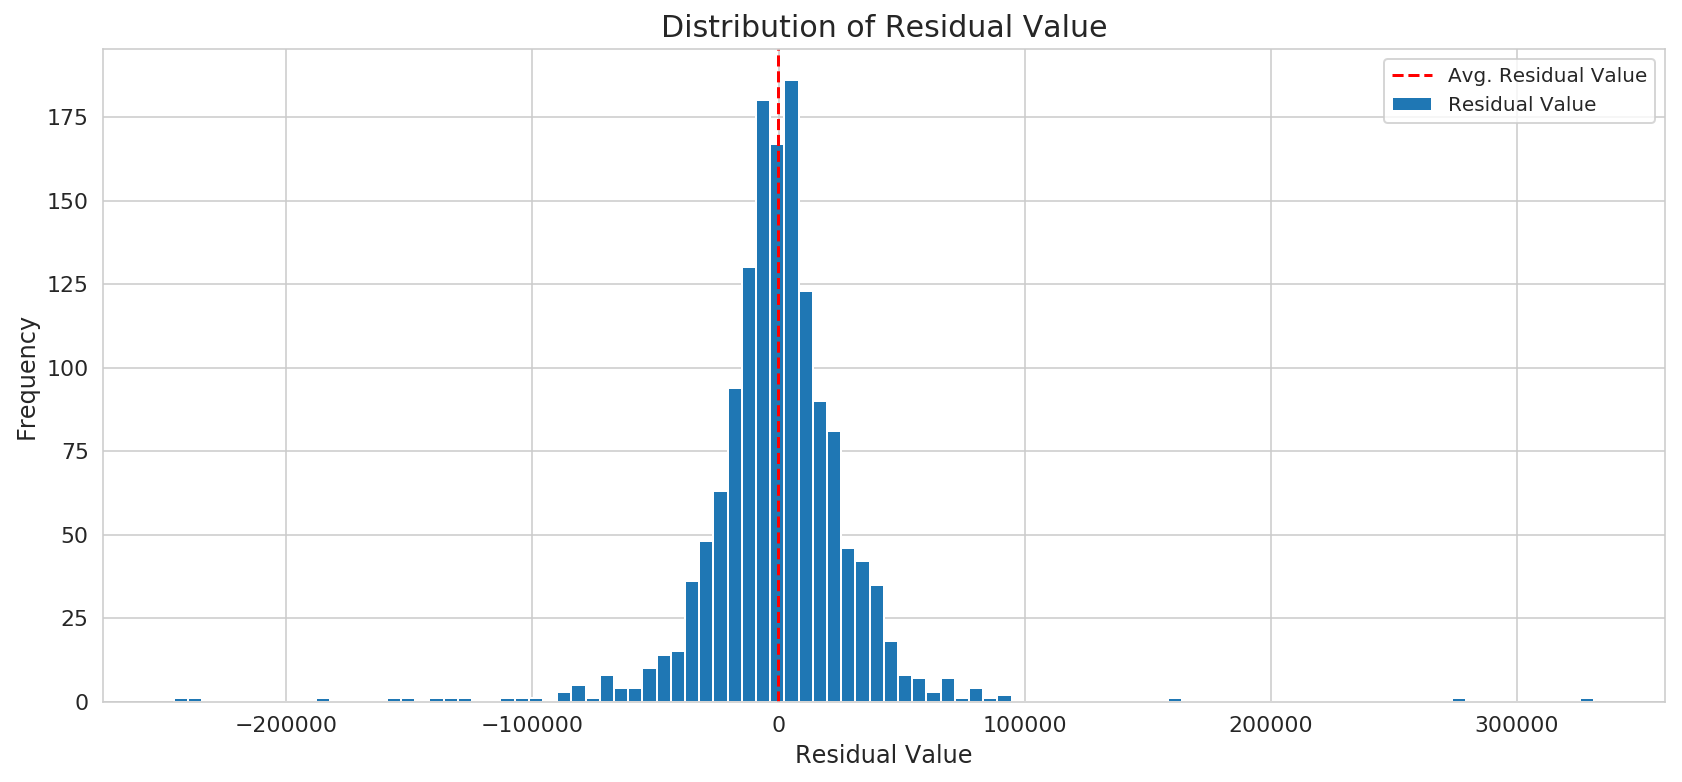

In [41]:
#Distribution plot of Prediction Residual

f, ax = plt.subplots(figsize=(14,6))

ax.hist(x=house['SalePrice_resid1'], bins=100, label='Residual Value')
ax.axvline(np.mean(house['SalePrice_resid1']), color='r', linestyle='--', label='Avg. Residual Value')

ax.set_xlabel('Residual Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Residual Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend()

plt.show()

<font color='blue'>

Observations:
1. From the histogram, the residuals are distributed normally. 

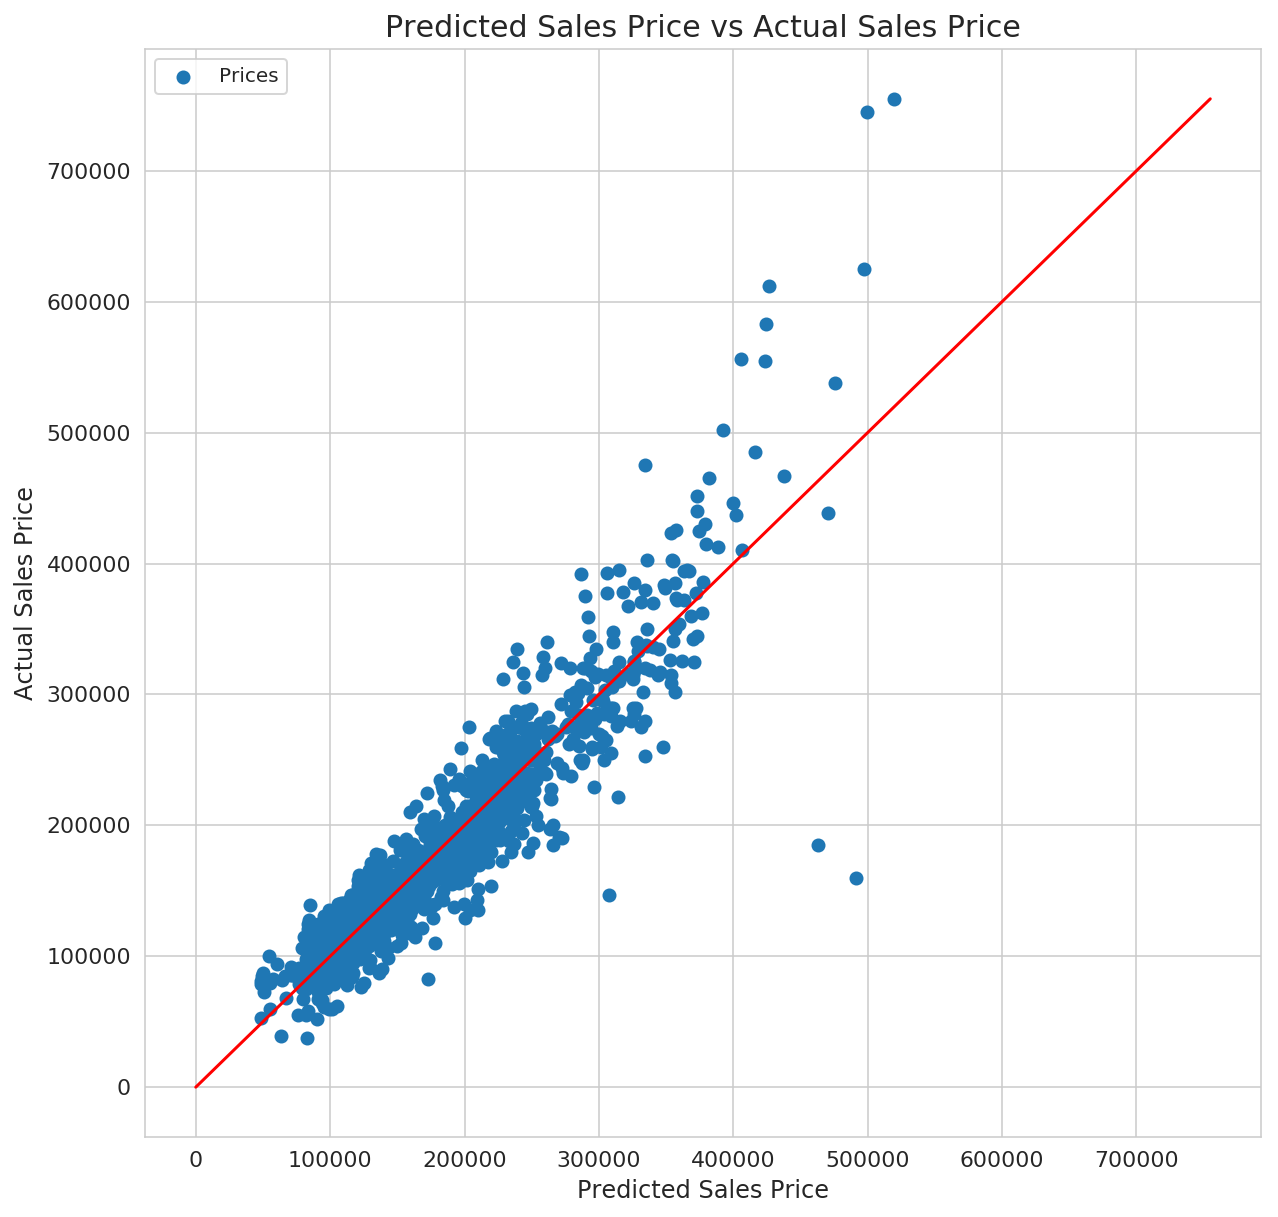

In [42]:
#Plot Scatter Plot of Predicted Price vs Actual Price

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice_predict1'], y=house['SalePrice'], label='Prices')
ax.plot((0,house['SalePrice'].max()), (0,house['SalePrice'].max()), c='red')

ax.set_xlabel('Predicted Sales Price', fontsize=12)
ax.set_ylabel('Actual Sales Price', fontsize=12)
ax.set_title('Predicted Sales Price vs Actual Sales Price', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper left')

plt.show()

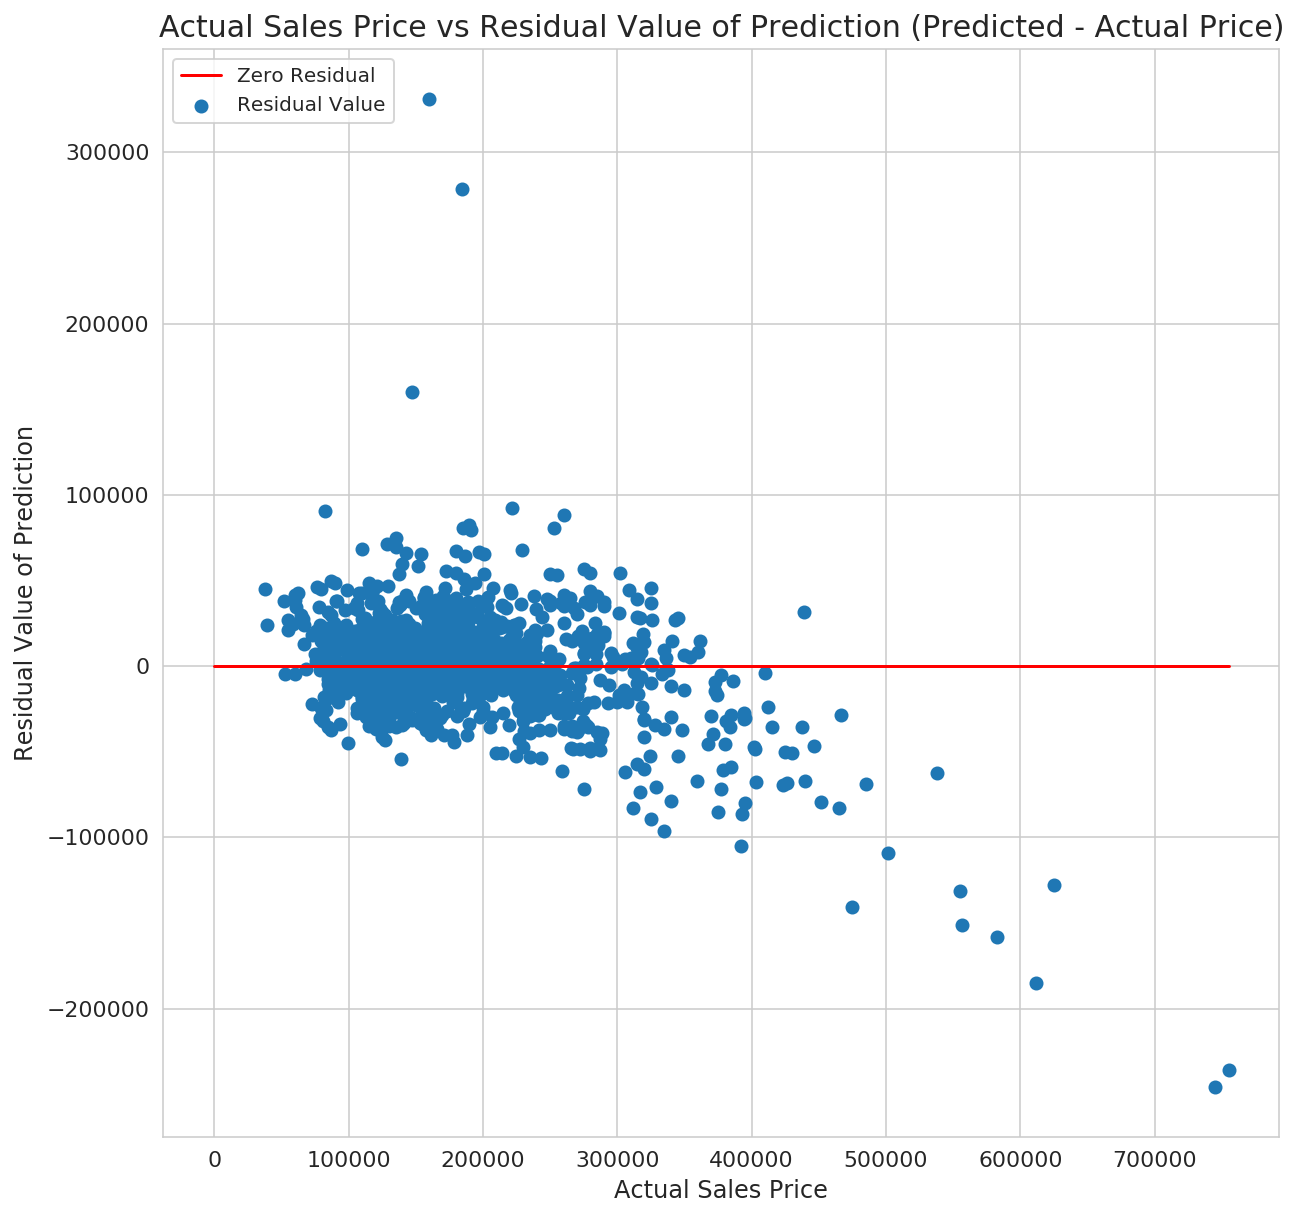

In [43]:
#Plot Scatter Plot of Actual Sales Price vs Residual Value of Prediction

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice'], y=house['SalePrice_resid1'], label='Residual Value')
ax.plot((0,house['SalePrice'].max()), (0,0), c='red', label='Zero Residual')

ax.set_xlabel('Actual Sales Price', fontsize=12)
ax.set_ylabel('Residual Value of Prediction', fontsize=12)
ax.set_title('Actual Sales Price vs Residual Value of Prediction (Predicted - Actual Price)', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper left')

plt.show()

<font color='blue'>

Observations:
1. From both the charts (Predicted vs Actual Price) and (Actual Price vs Residual), we can see that for house price below $350k, our model prediction is generally pretty good with prediction errors distributed evenly positively, and negatively.

2. For houses with Sales Prive above $350k, our model consistently under-predict the value of the houses. This is something worth looking into.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<font color='blue'>

### 2.1 Indentify Target and Predictor Features

In [44]:
#Target feature is the residucal value from the previous prediction (using non-renovatable features).
#We will be using the renovatable features to predict the residual value to identify which type of
#improvement to the house will yield the highest value.

y = house['SalePrice_resid1']

#Renovatable House Characteristics/ Features
reno_char = ['Street', 'Alley', 'Utilities', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofMatl', 'Exterior1st',
             'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 
             'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
             'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence']

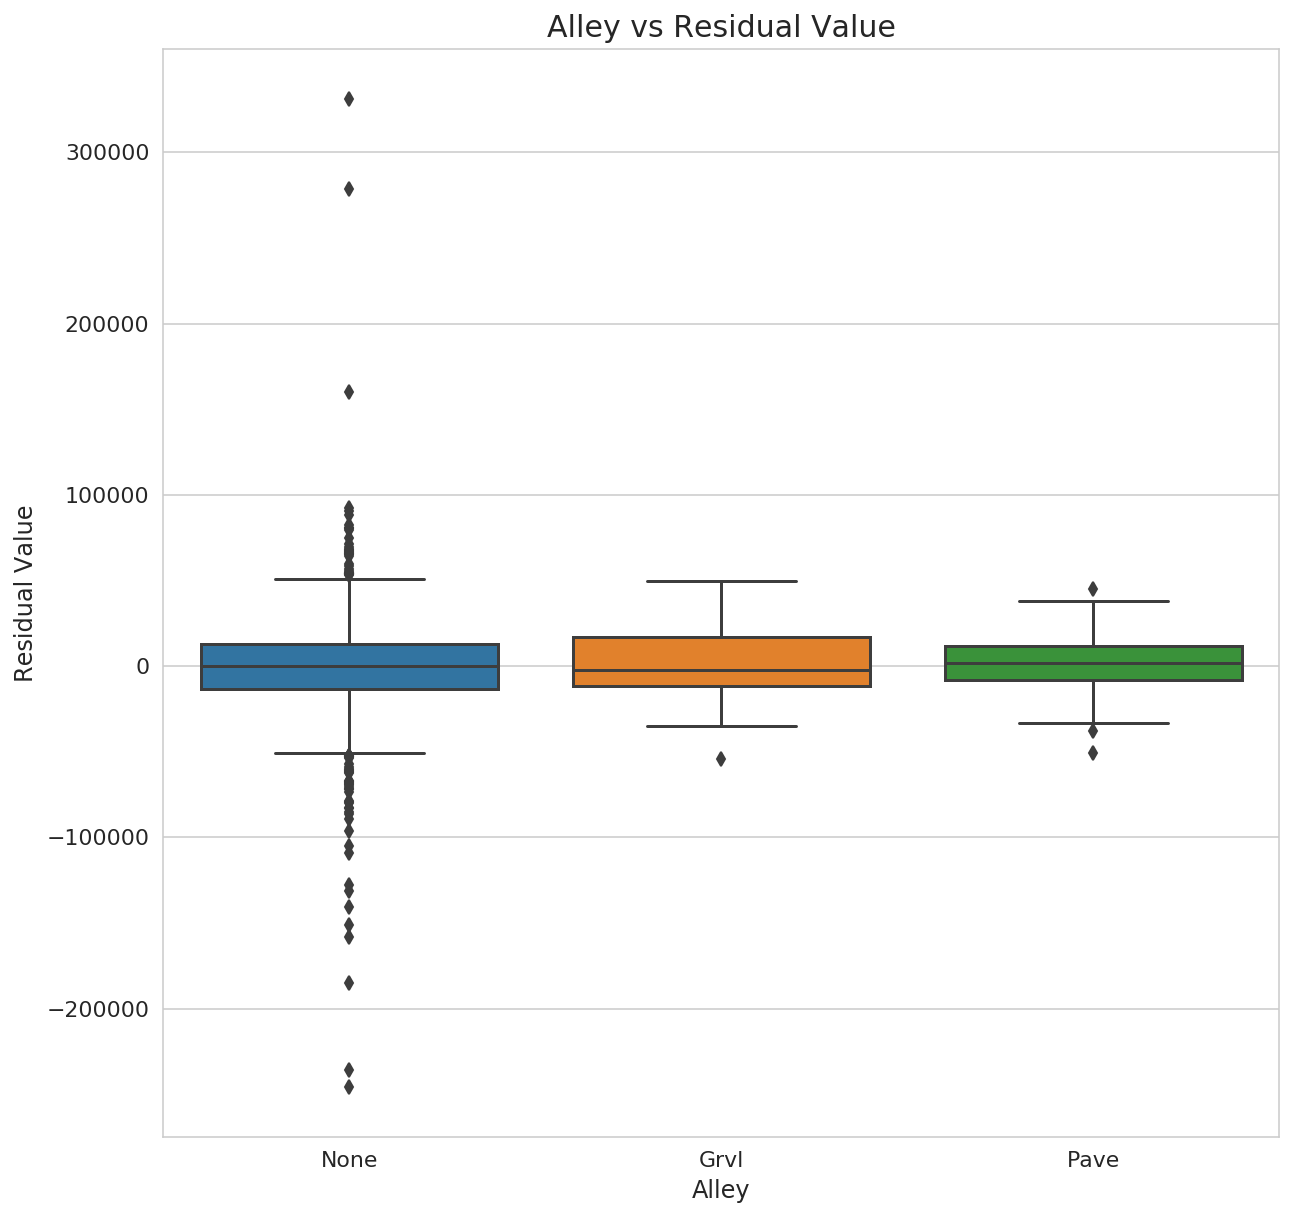

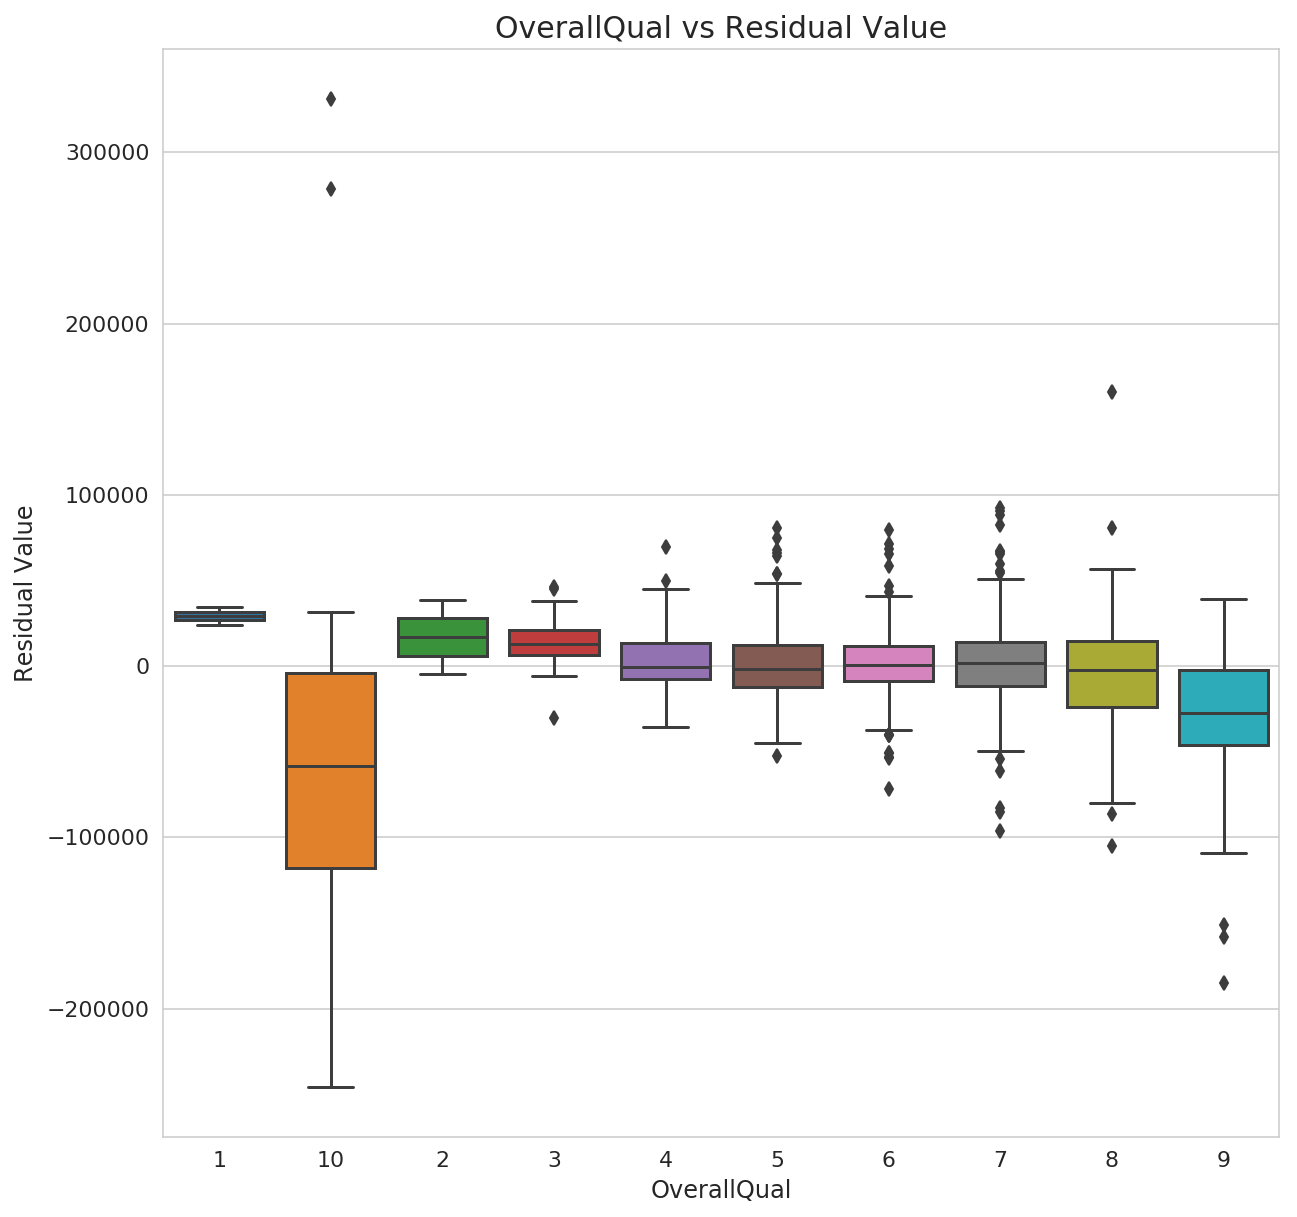

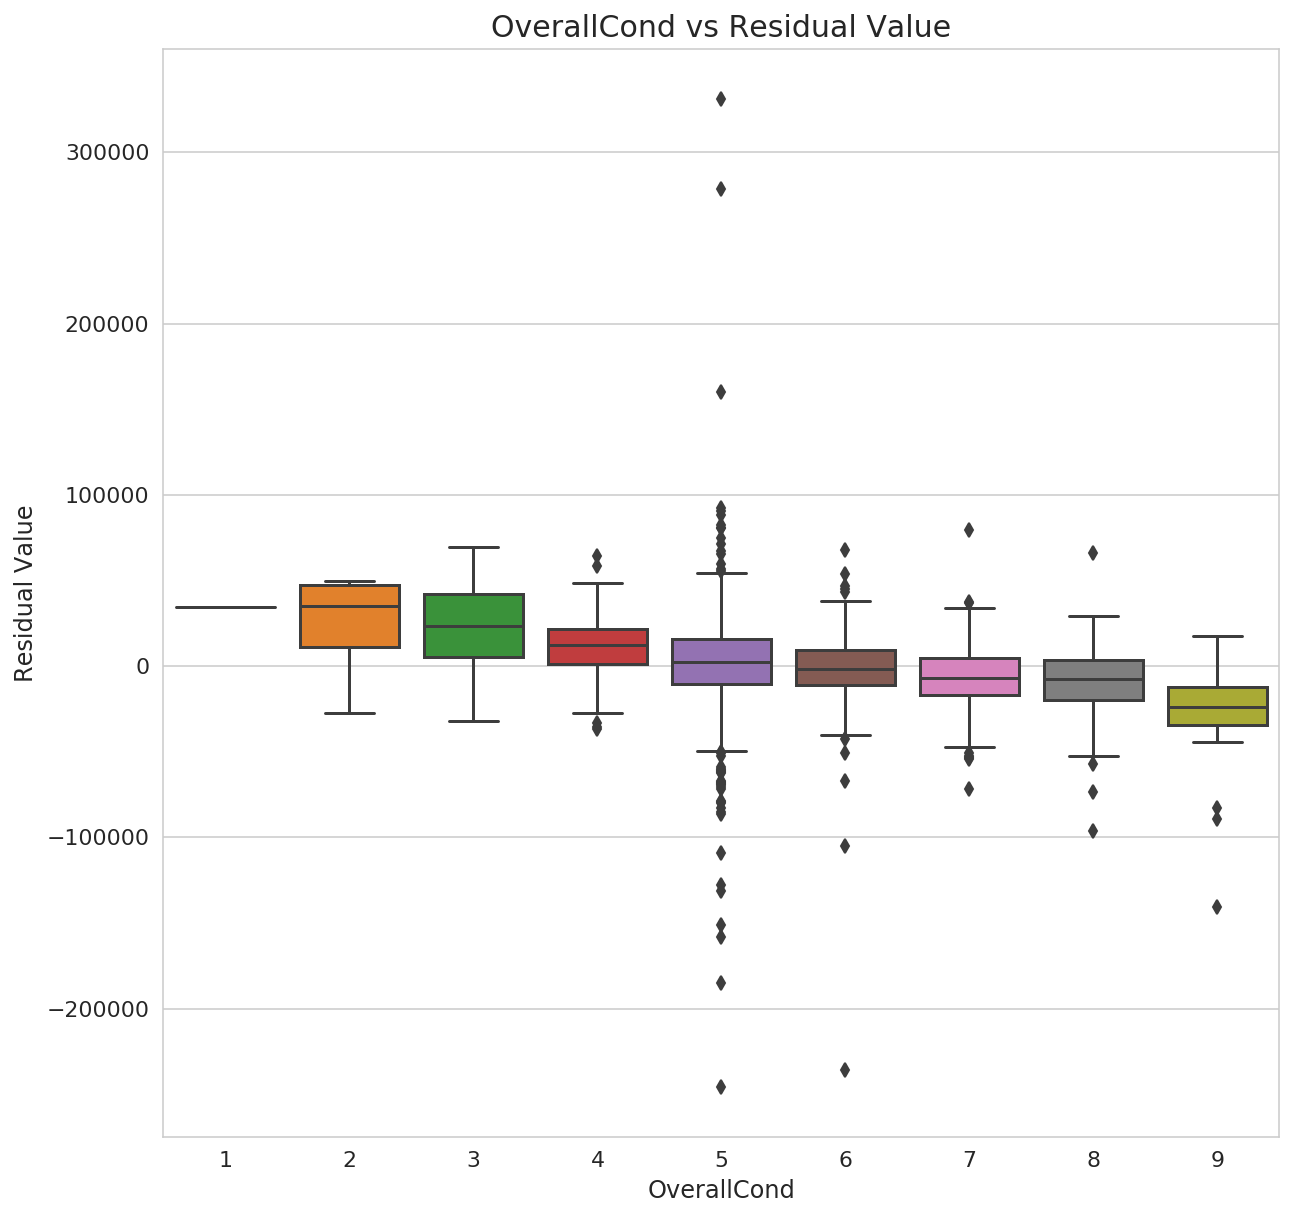

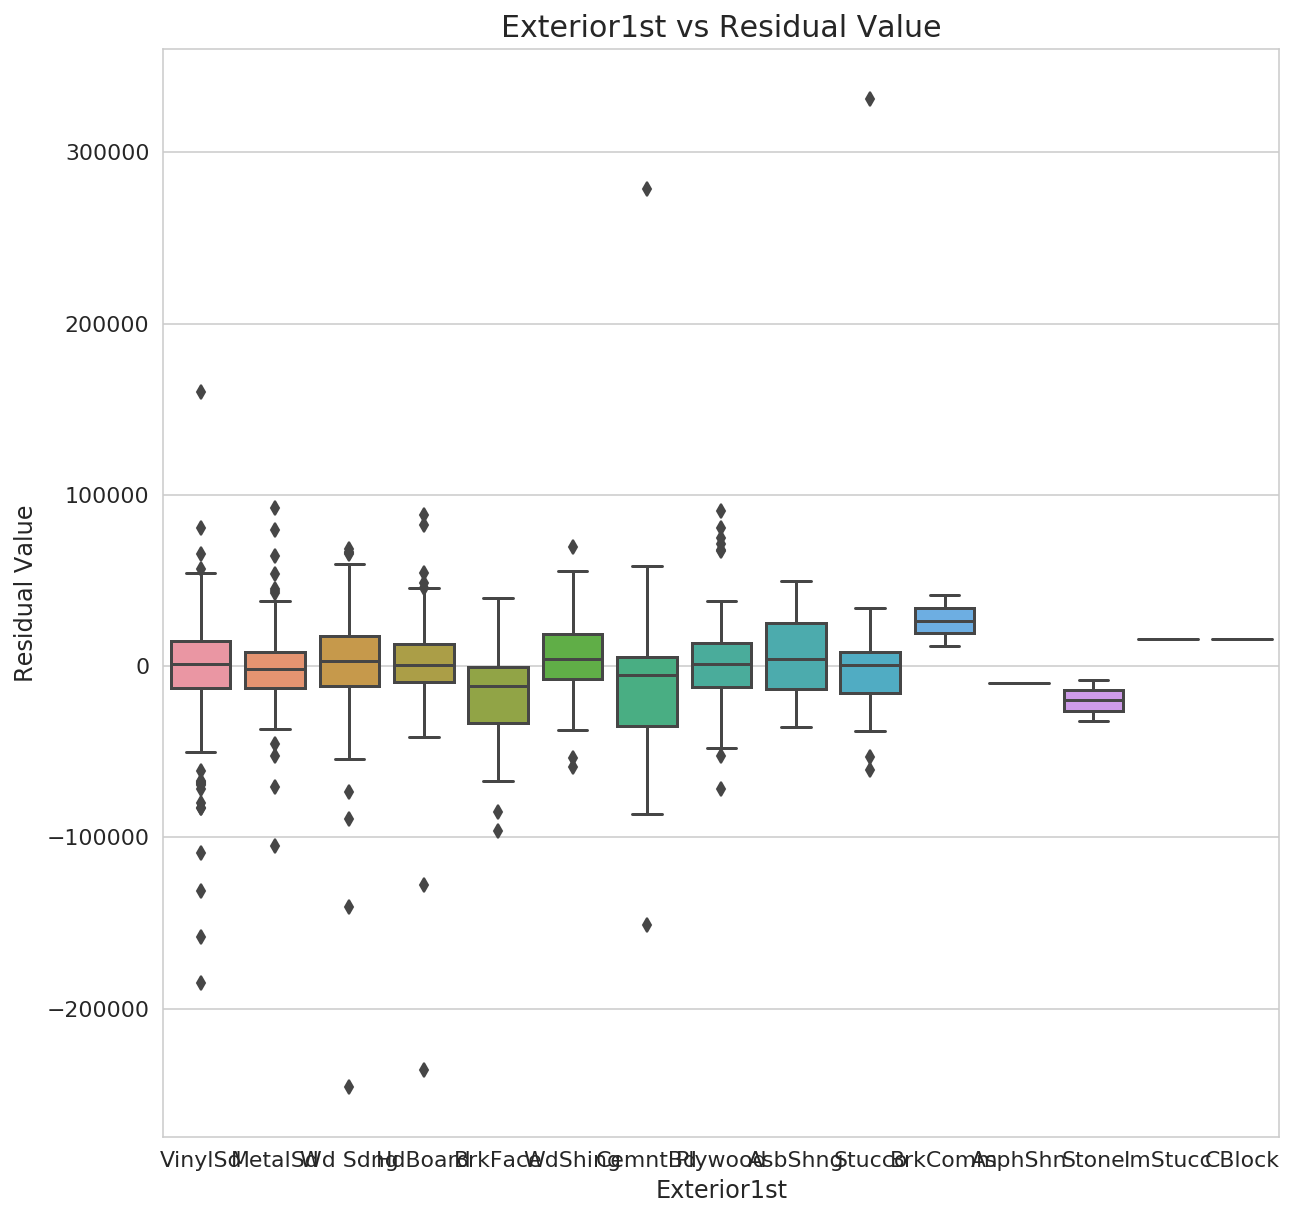

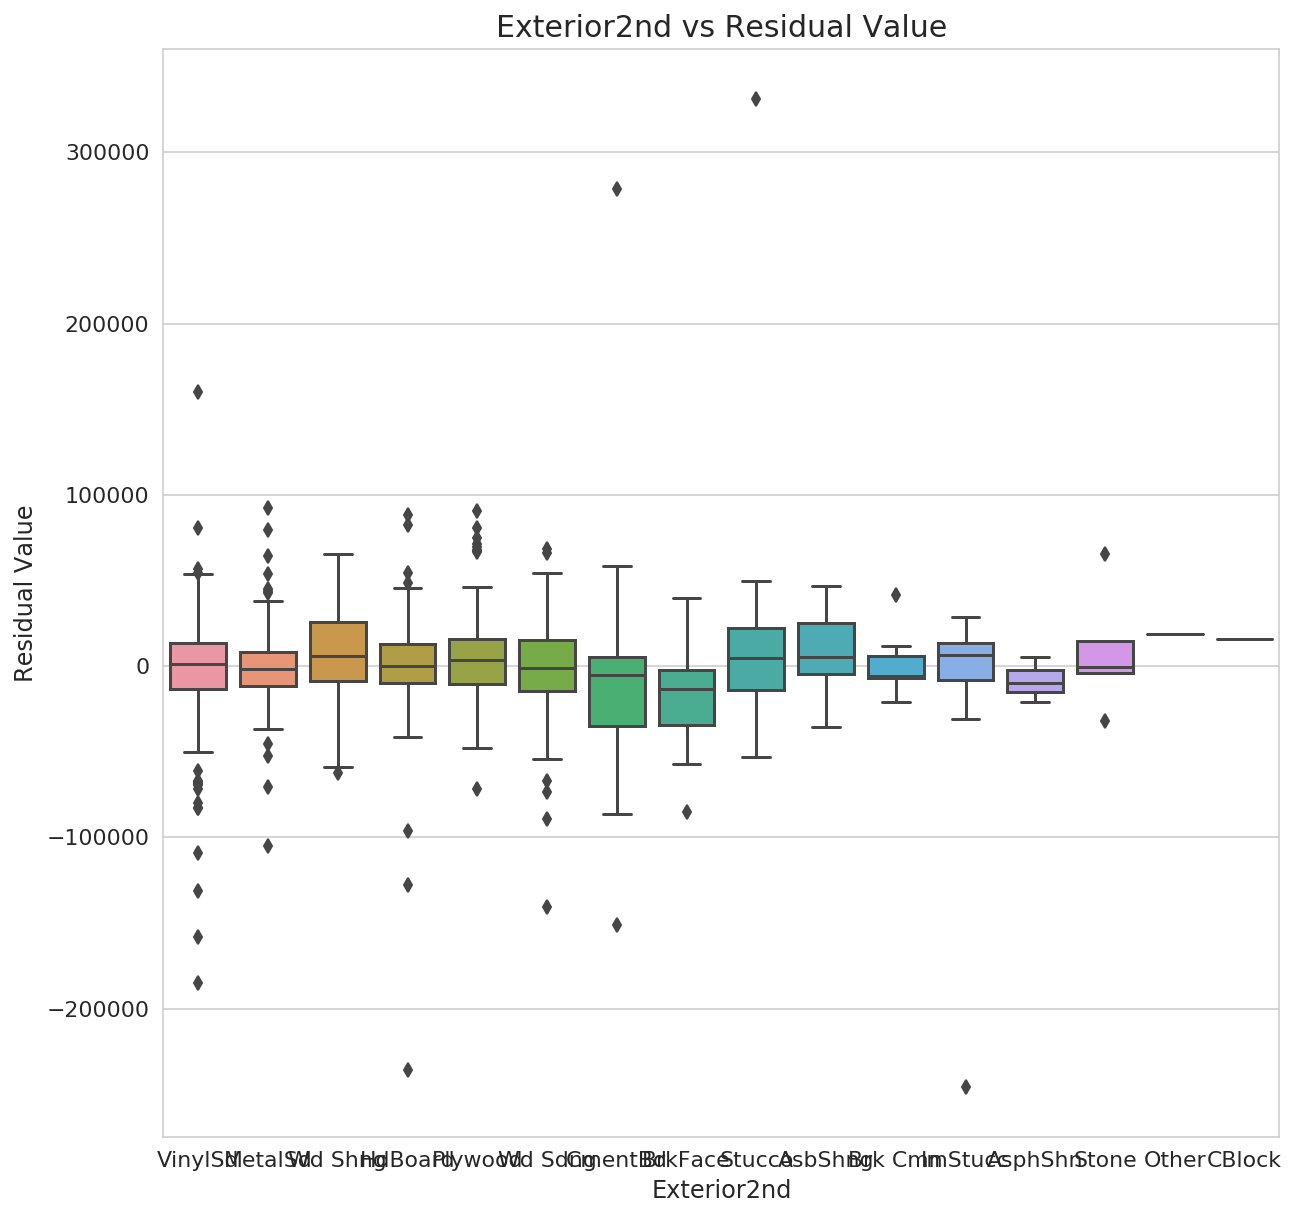

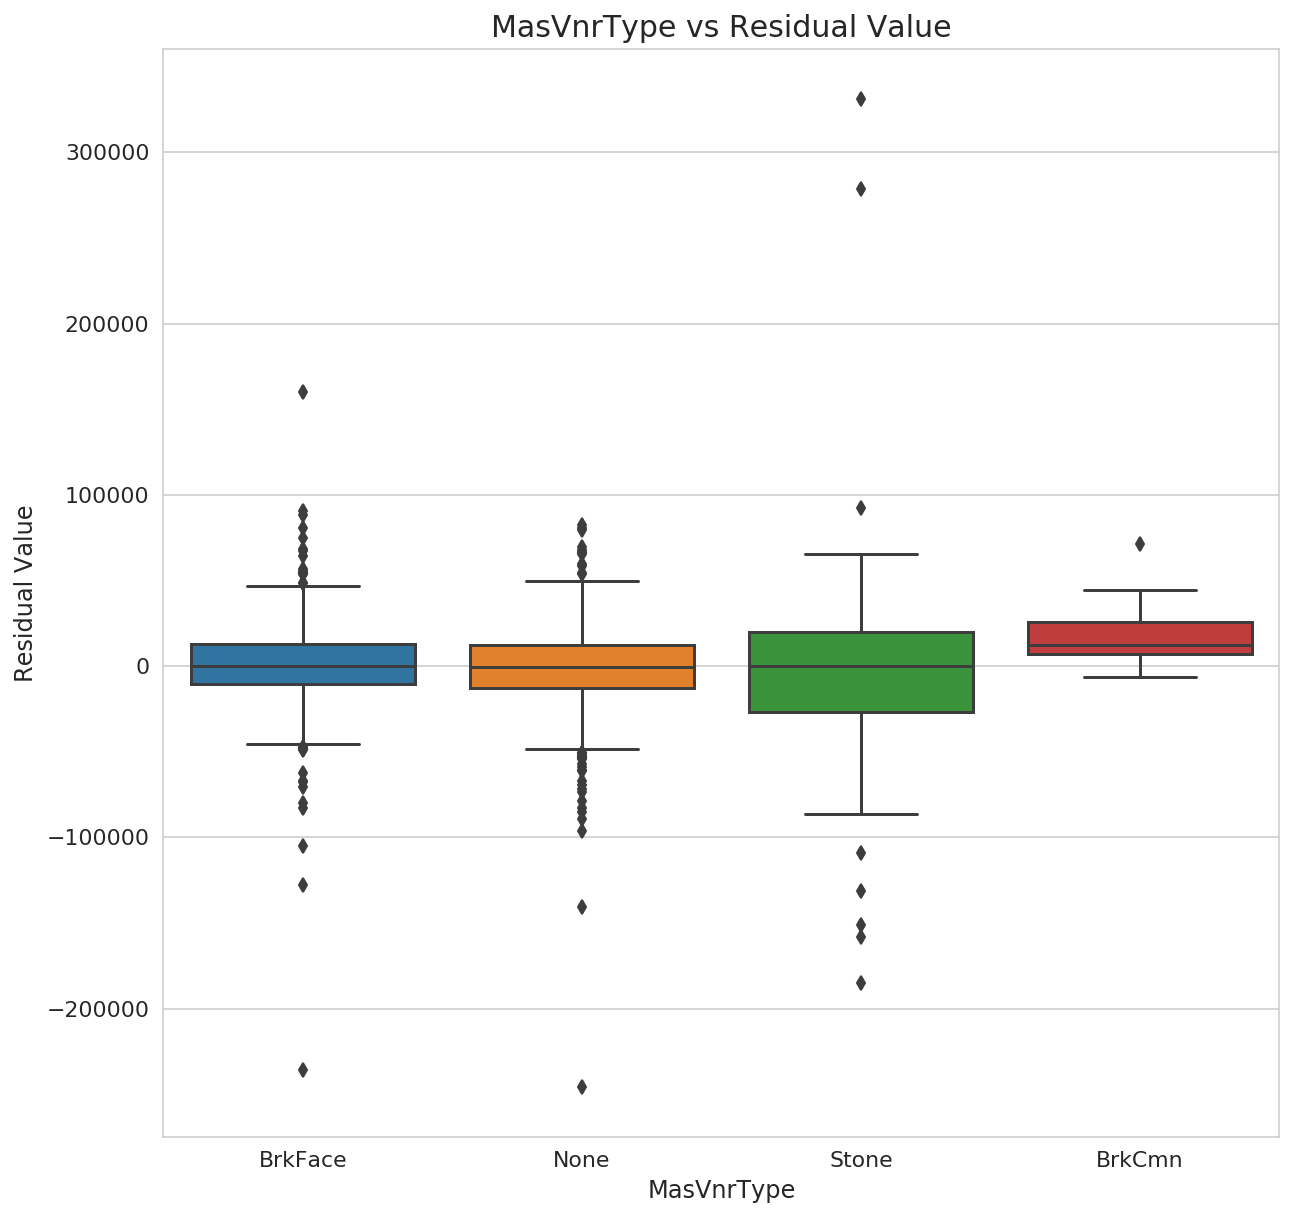

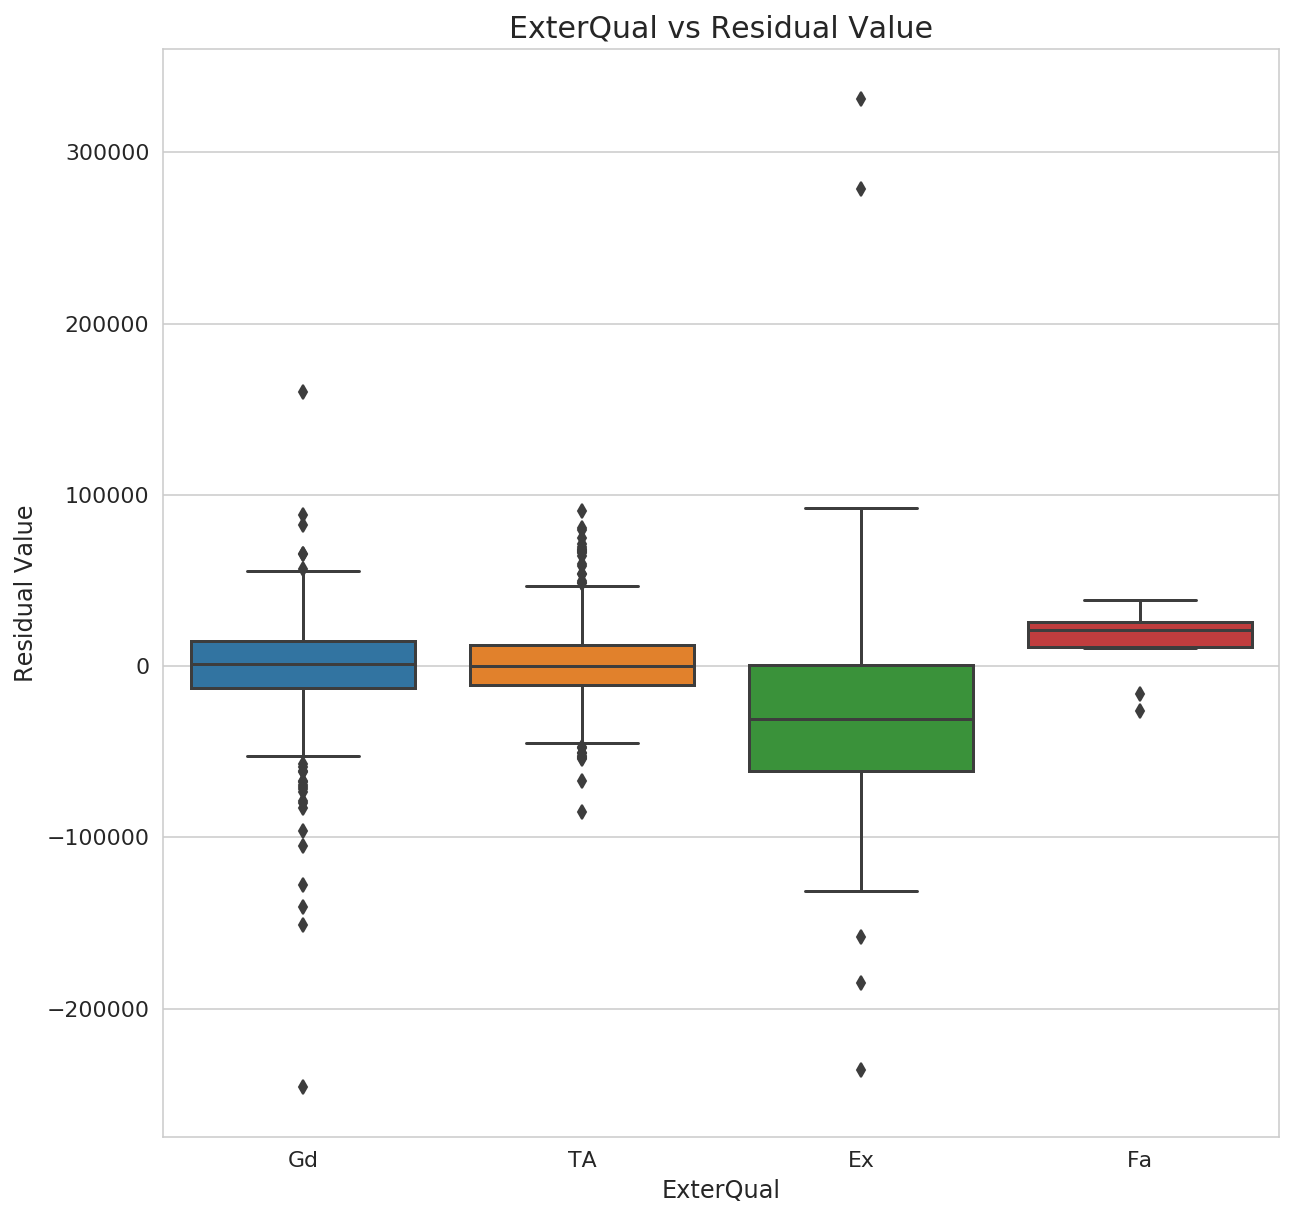

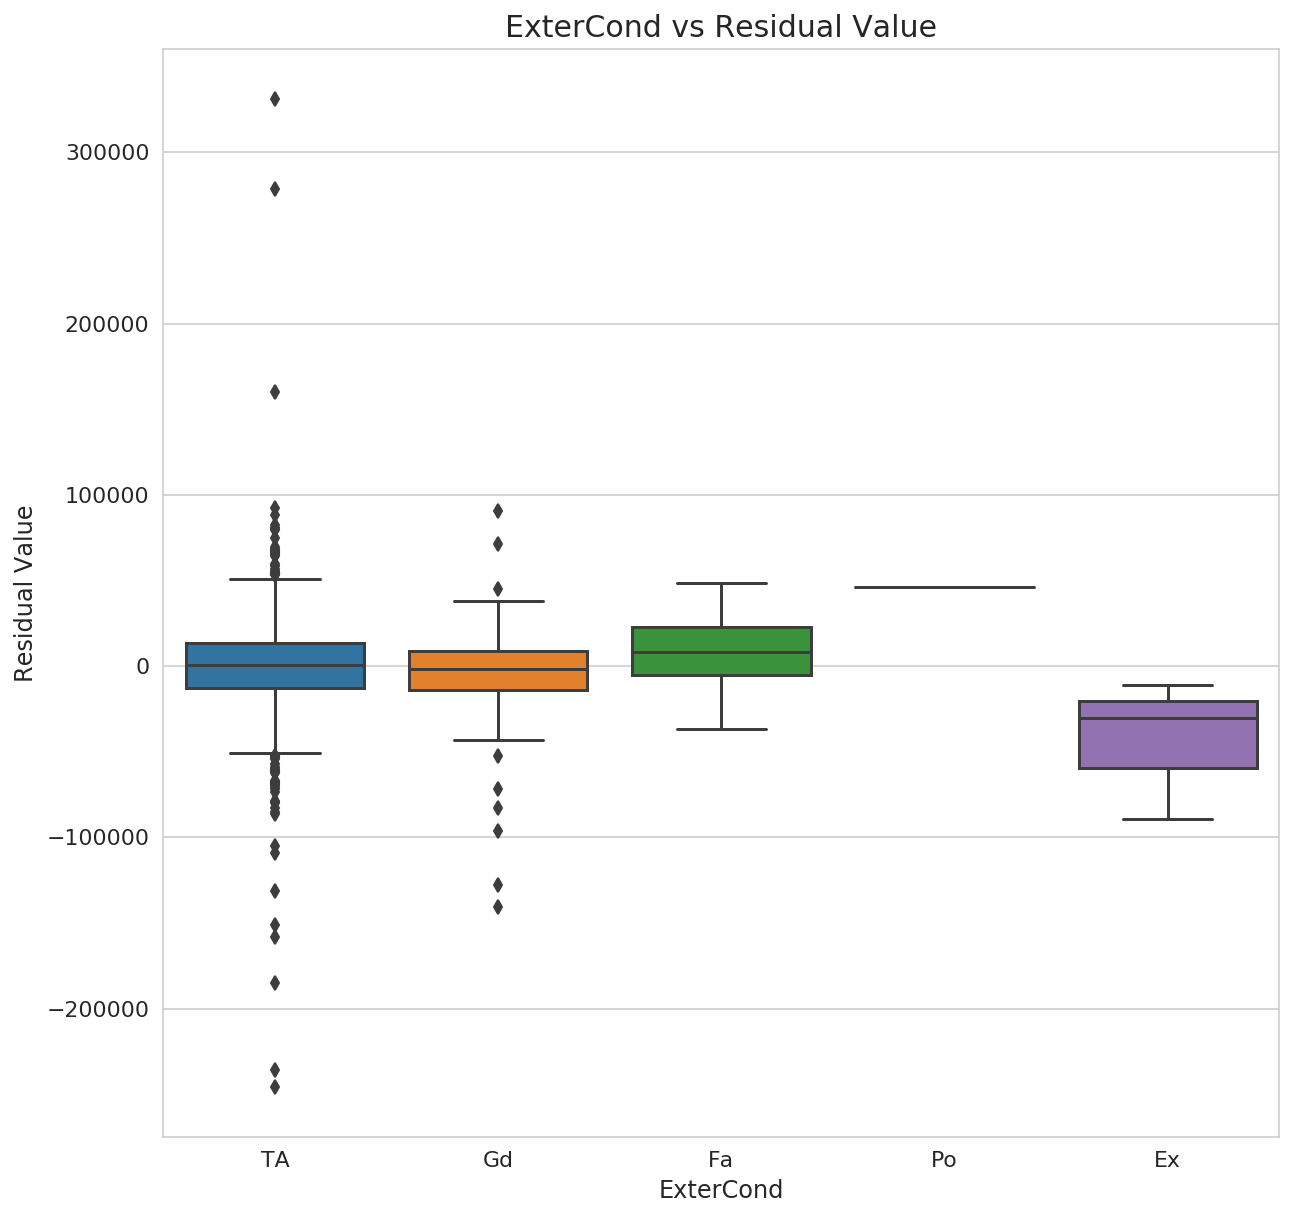

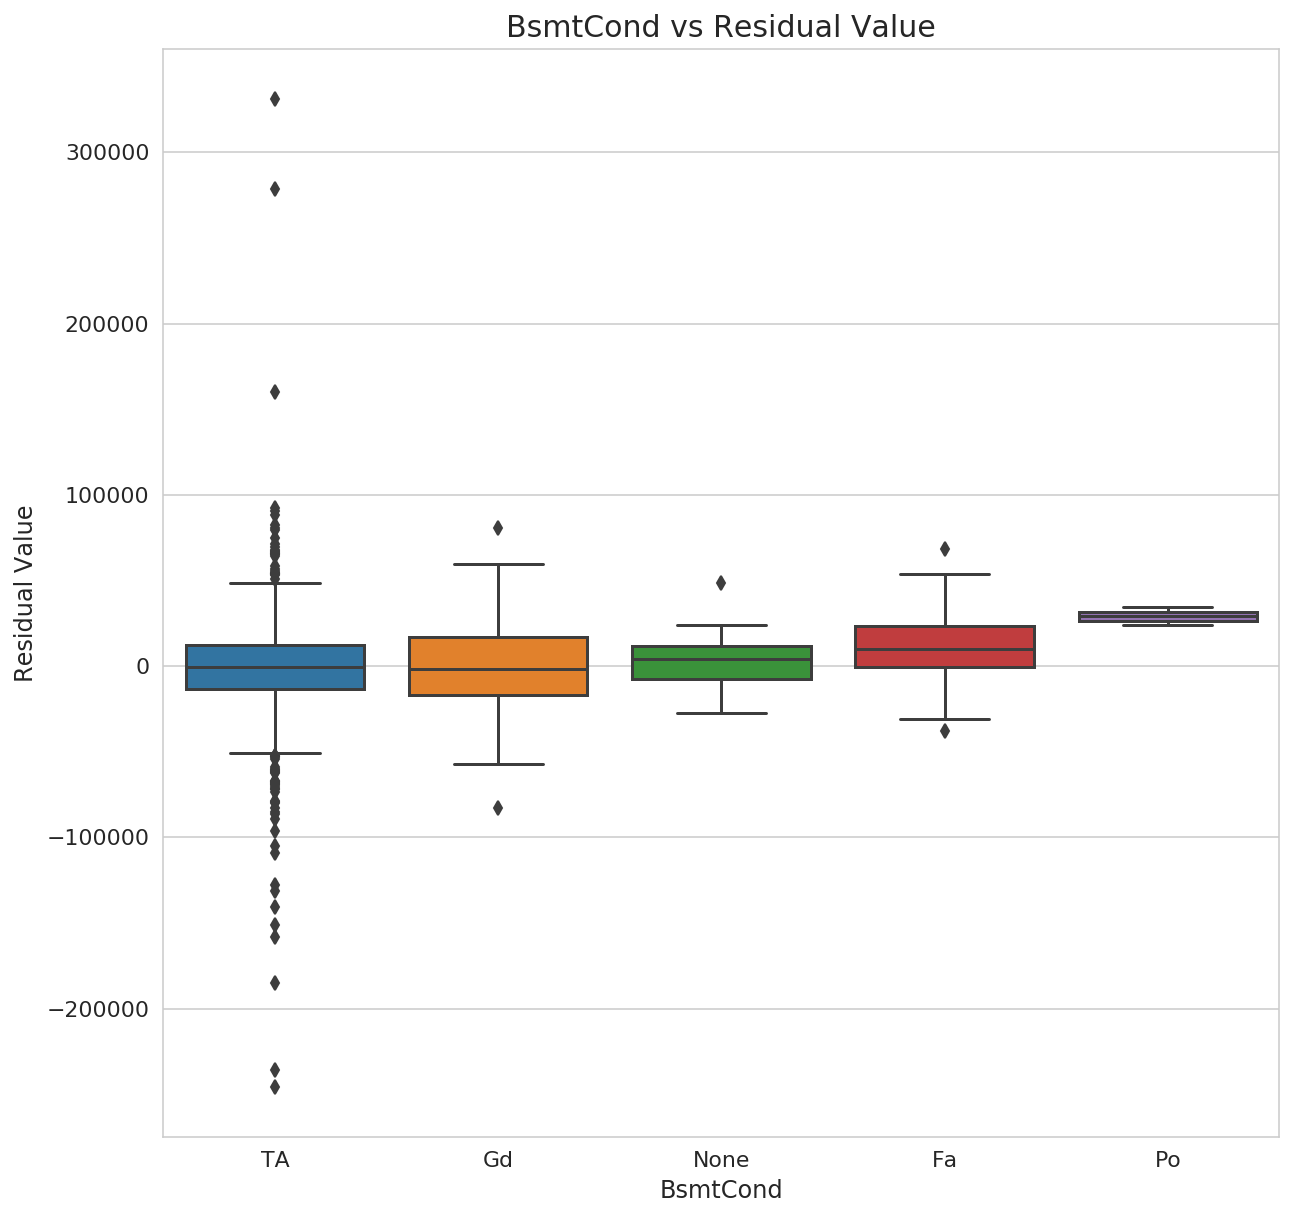

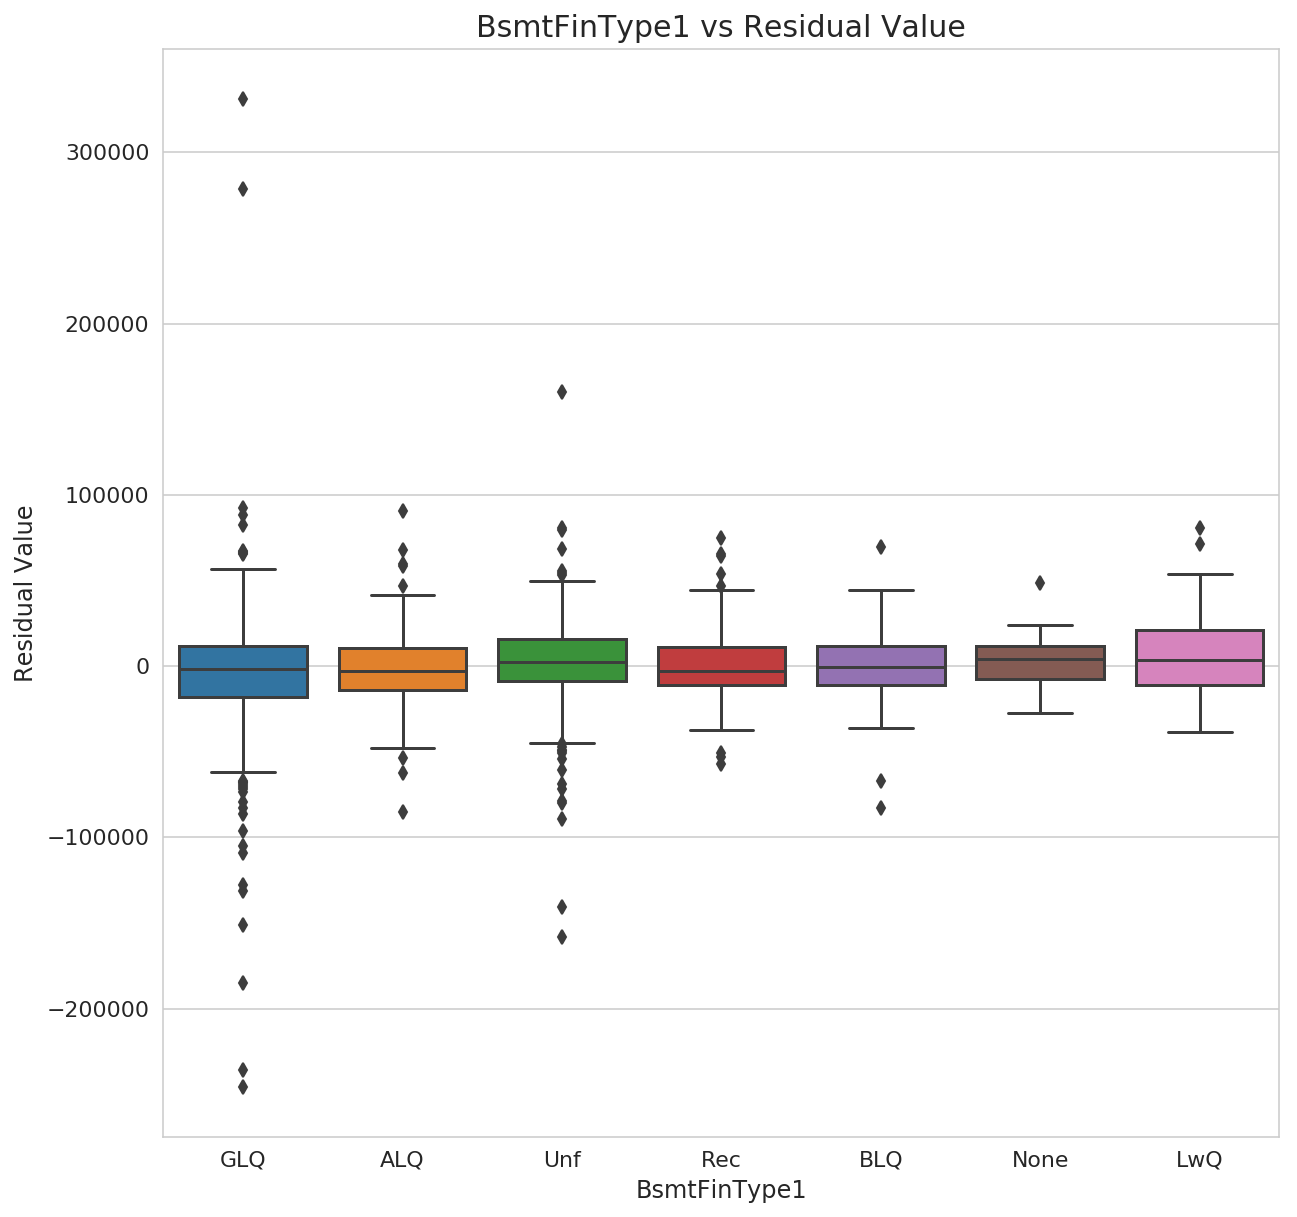

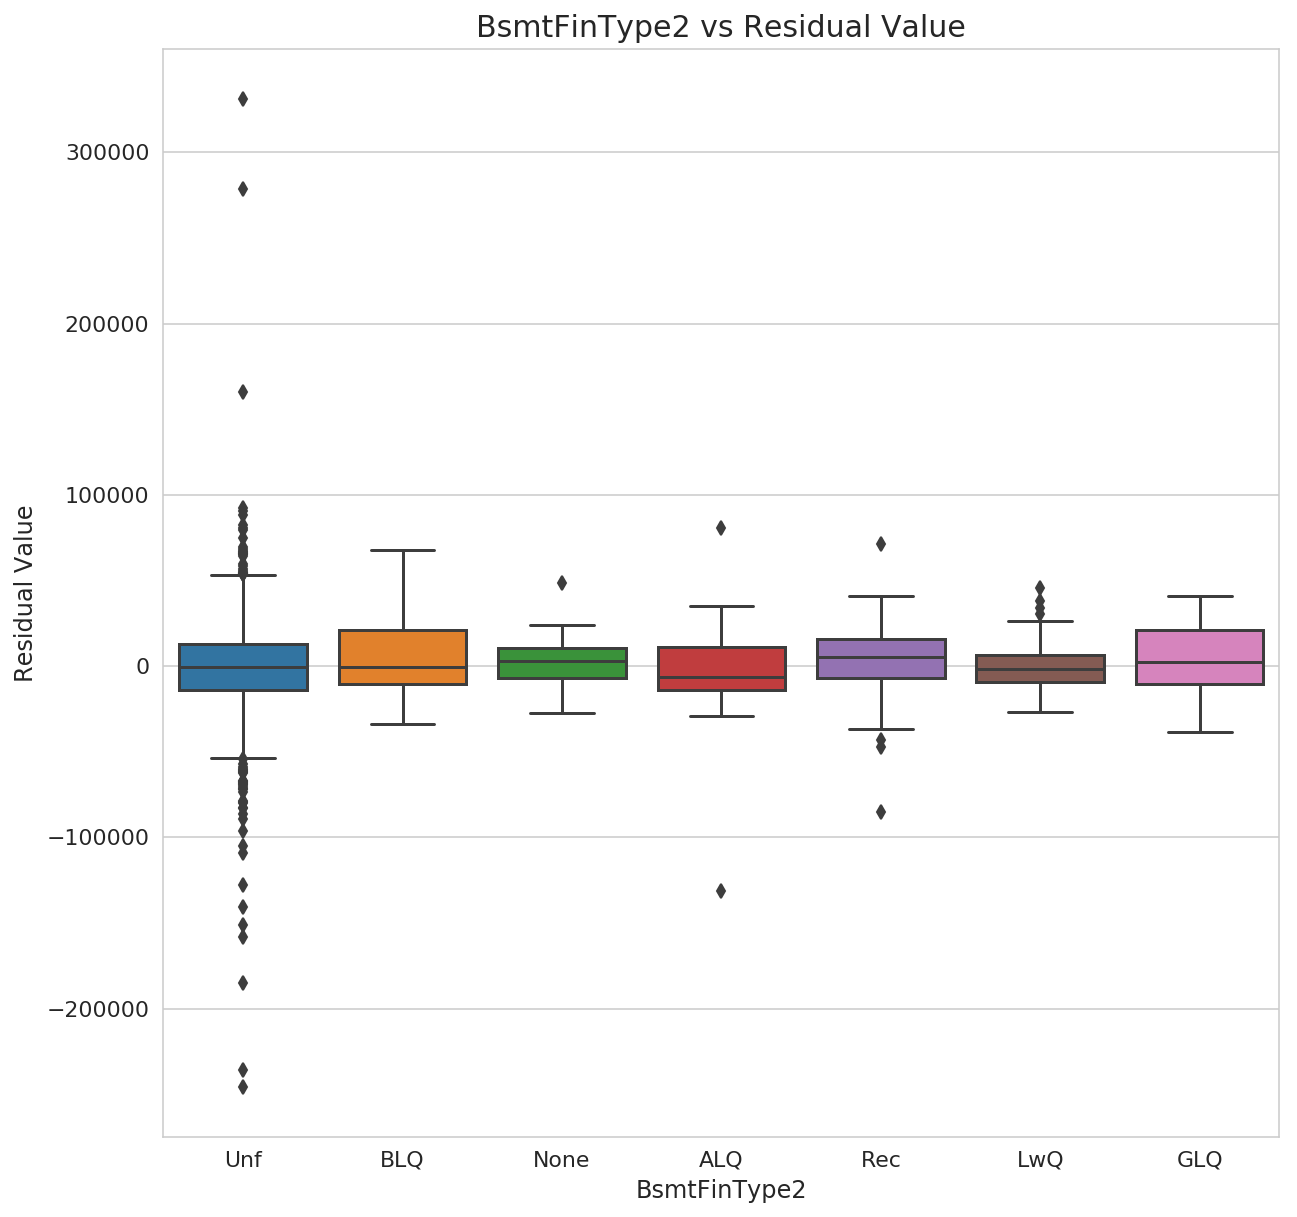

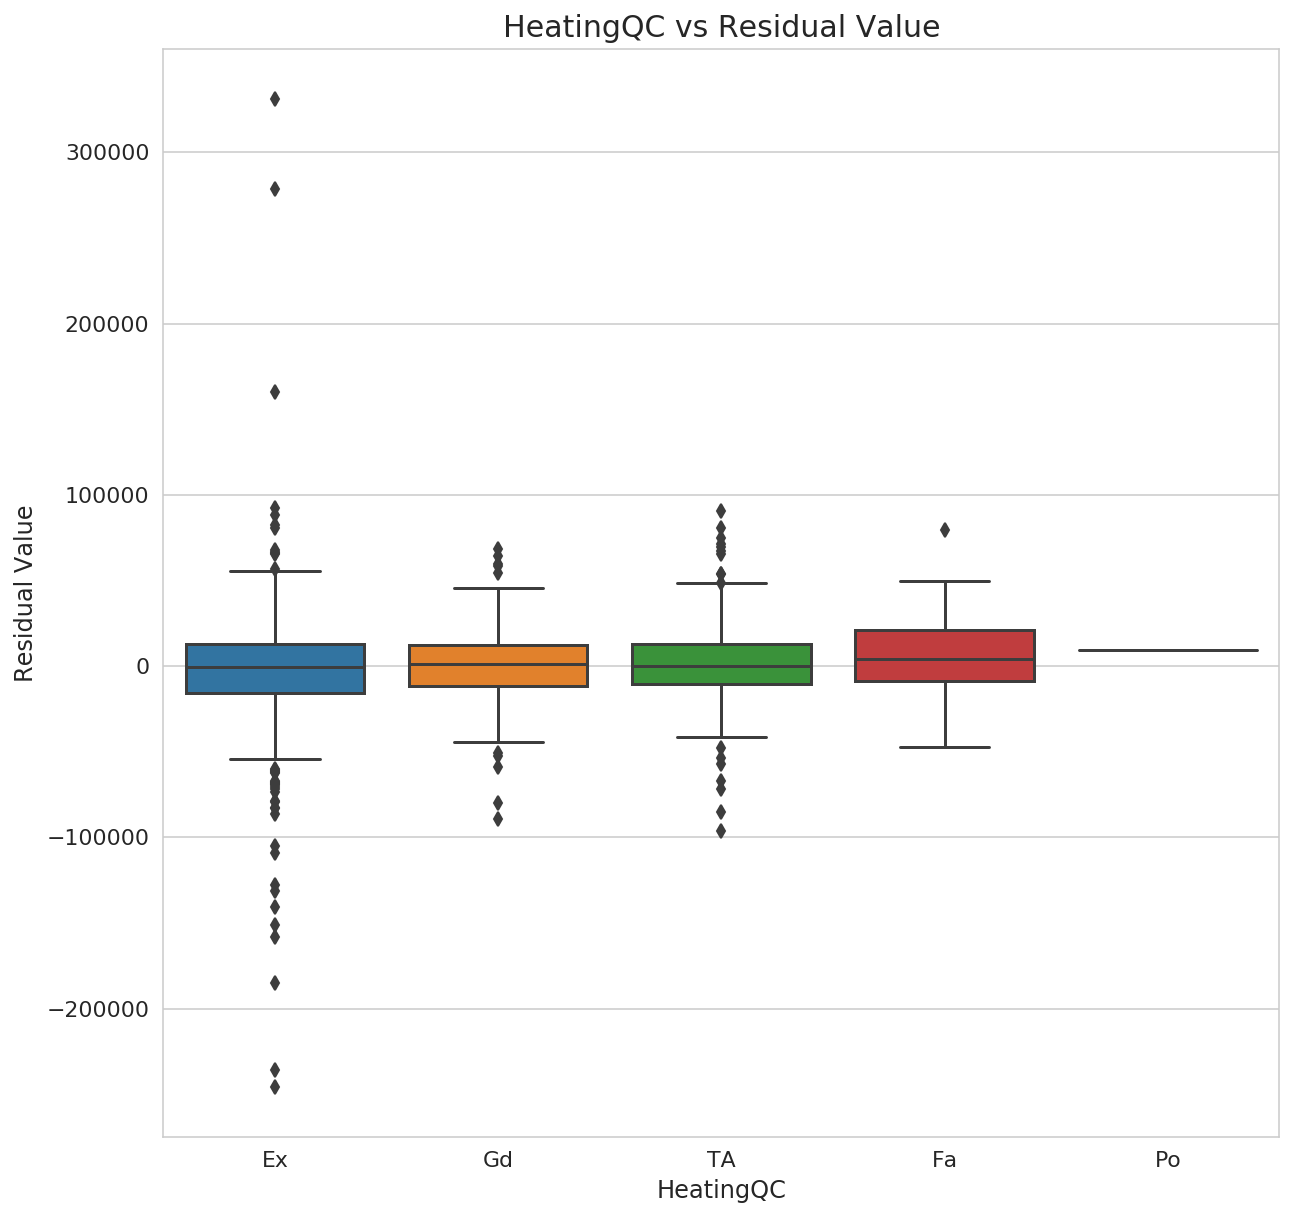

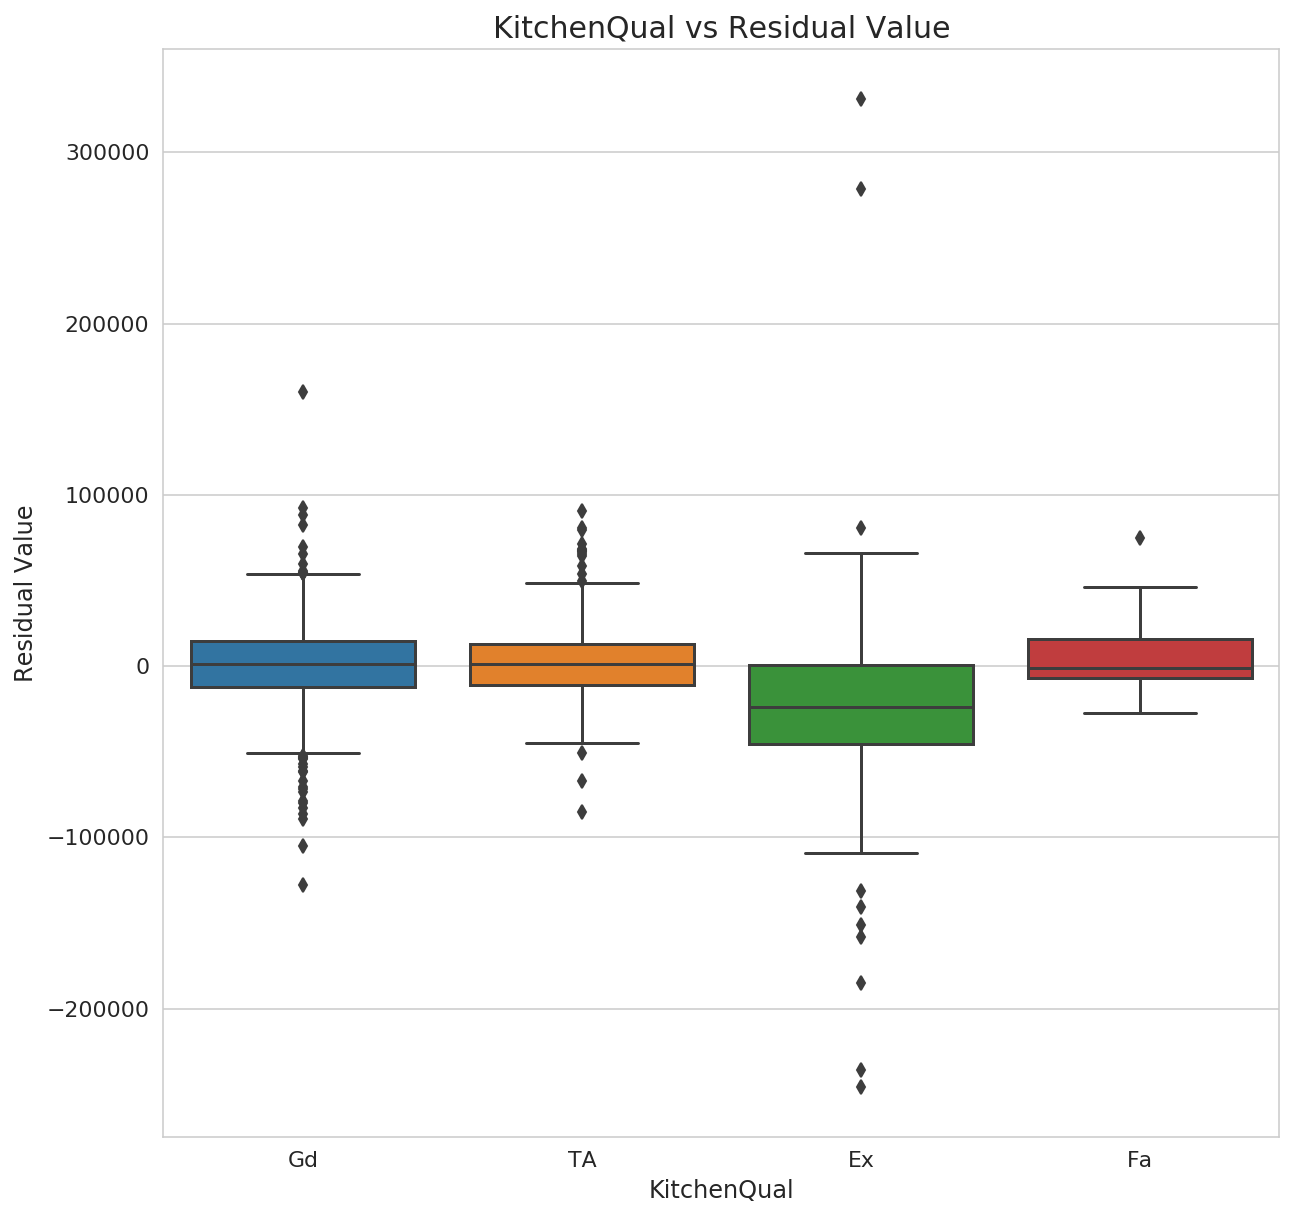

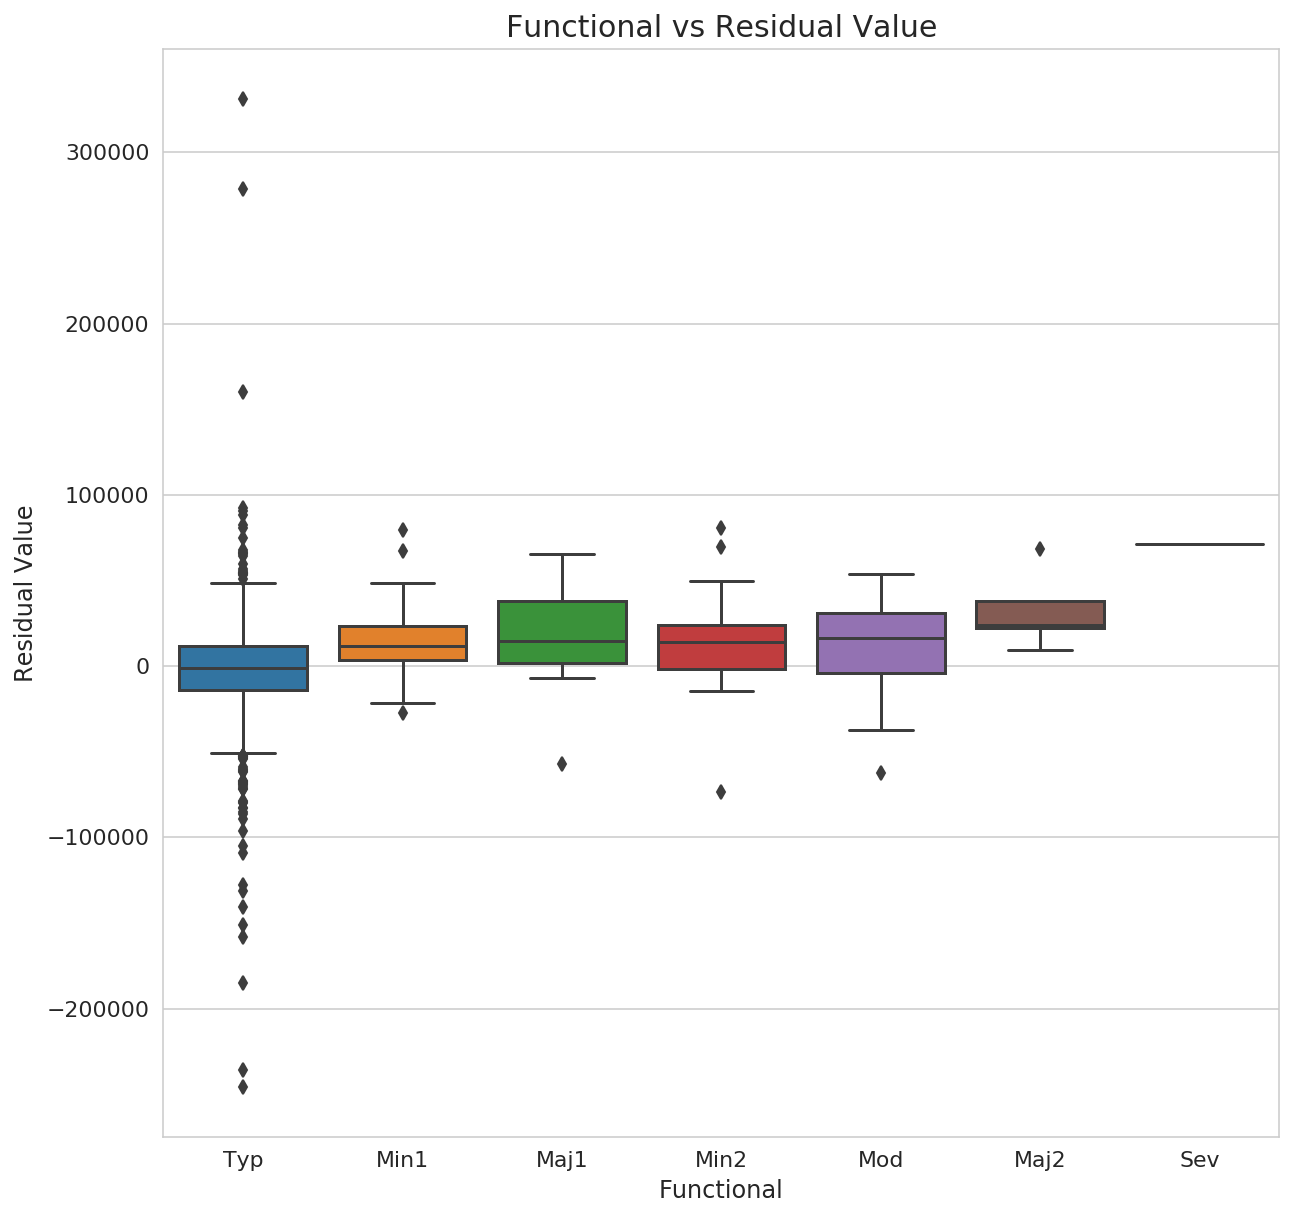

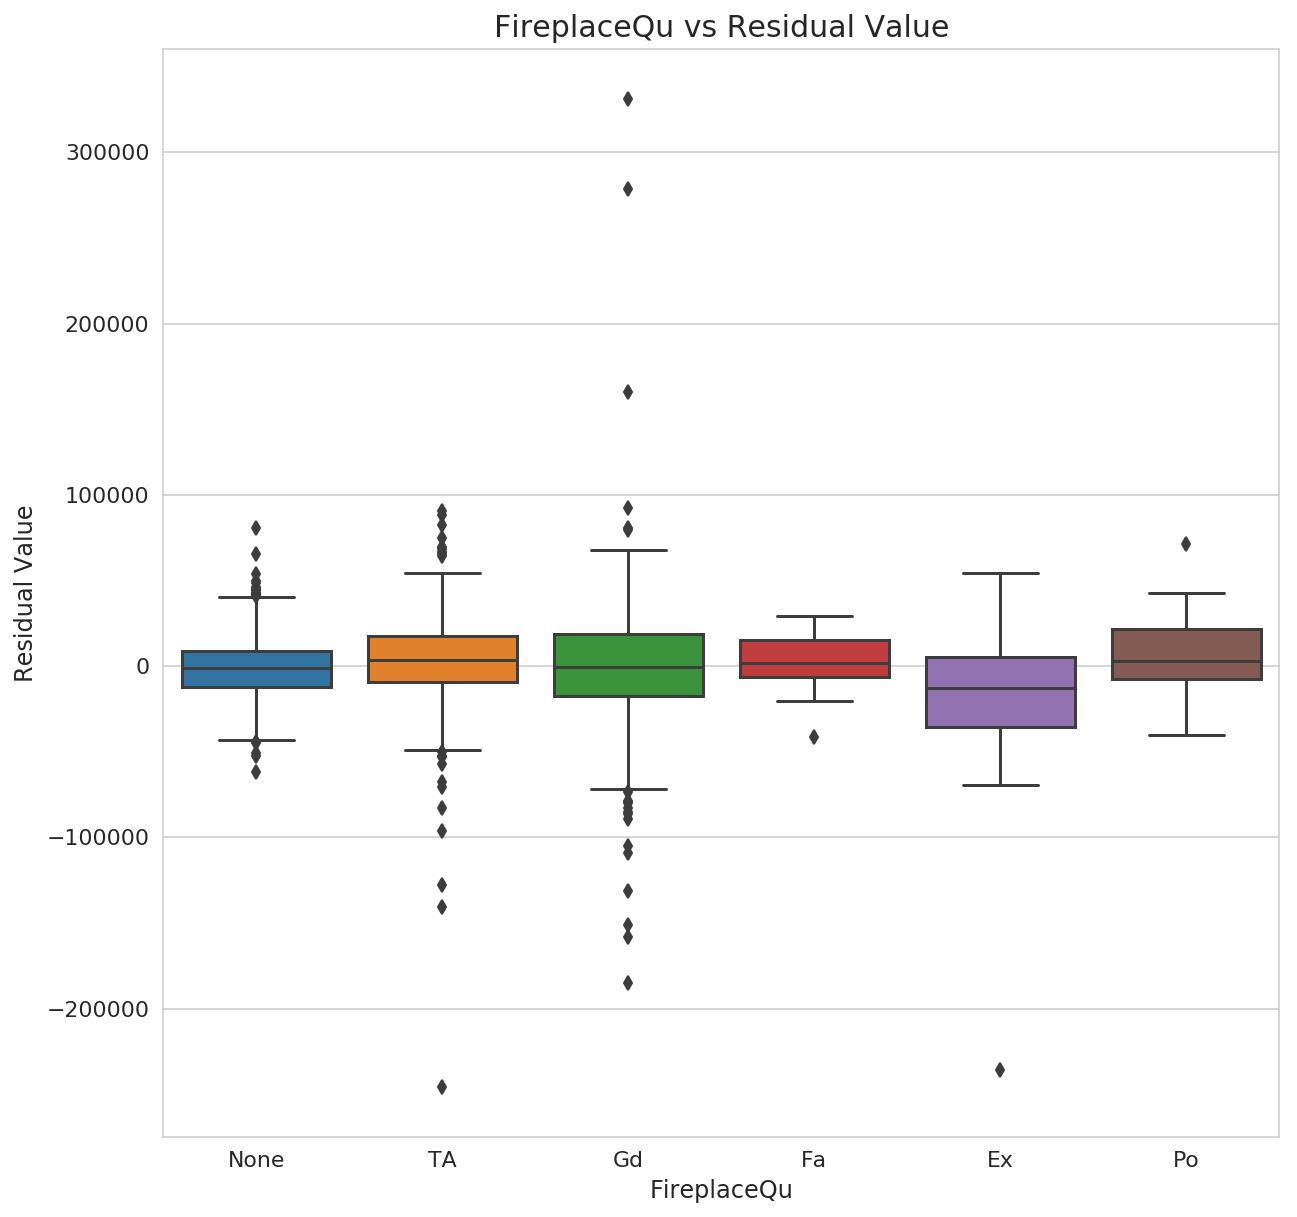

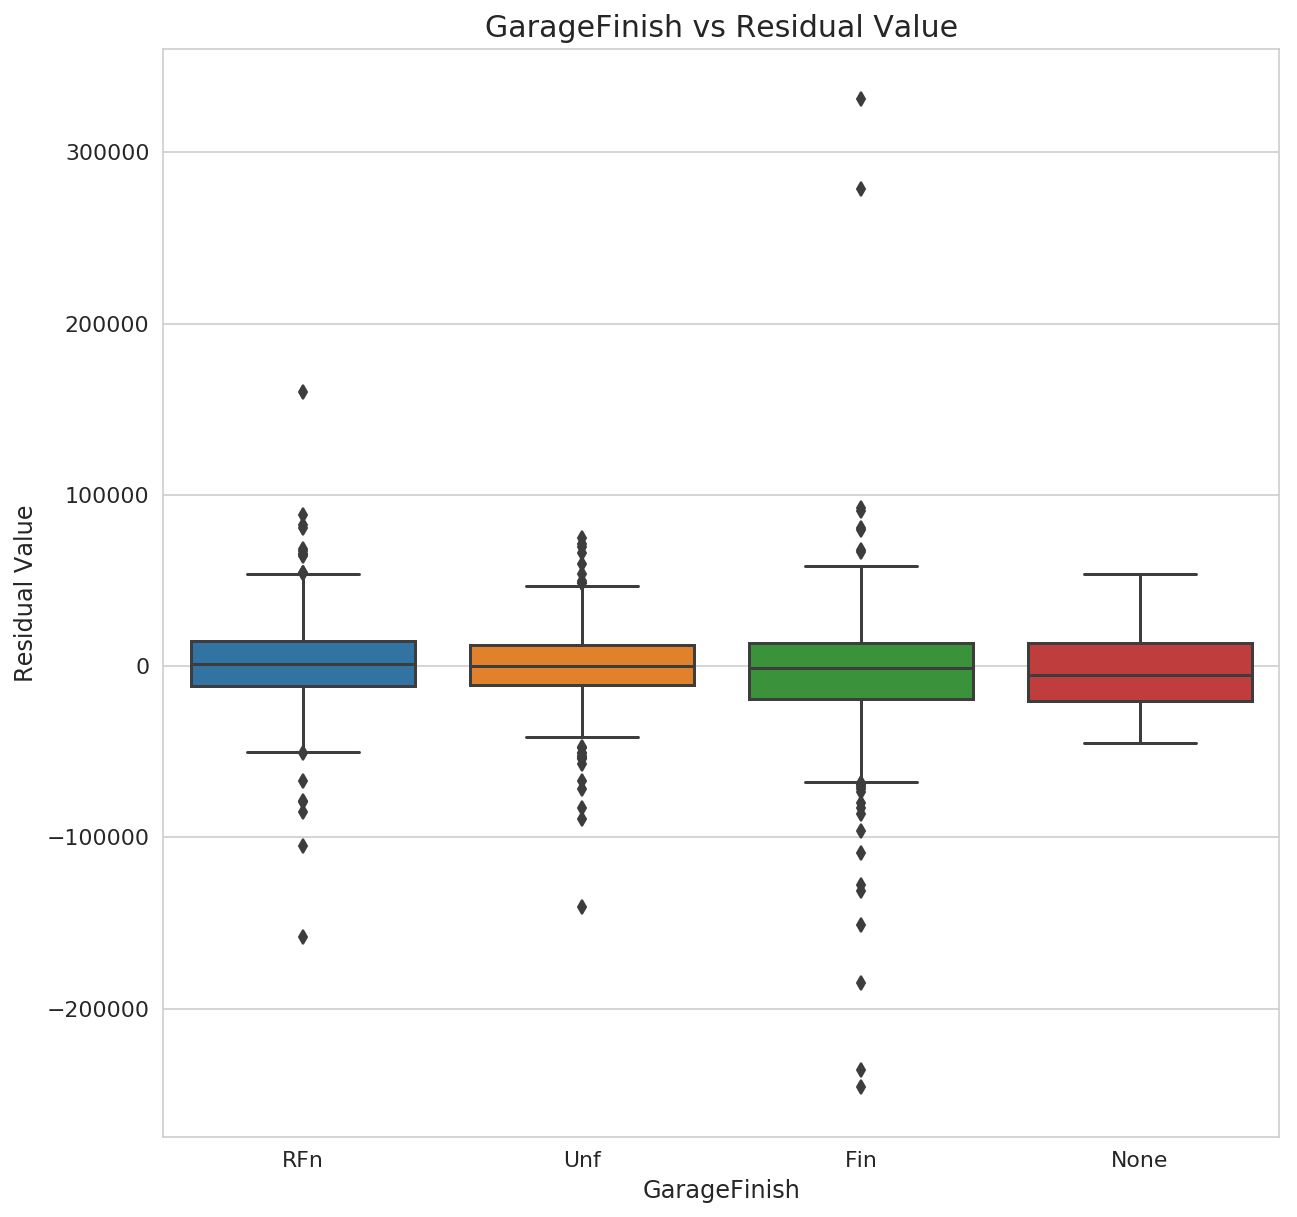

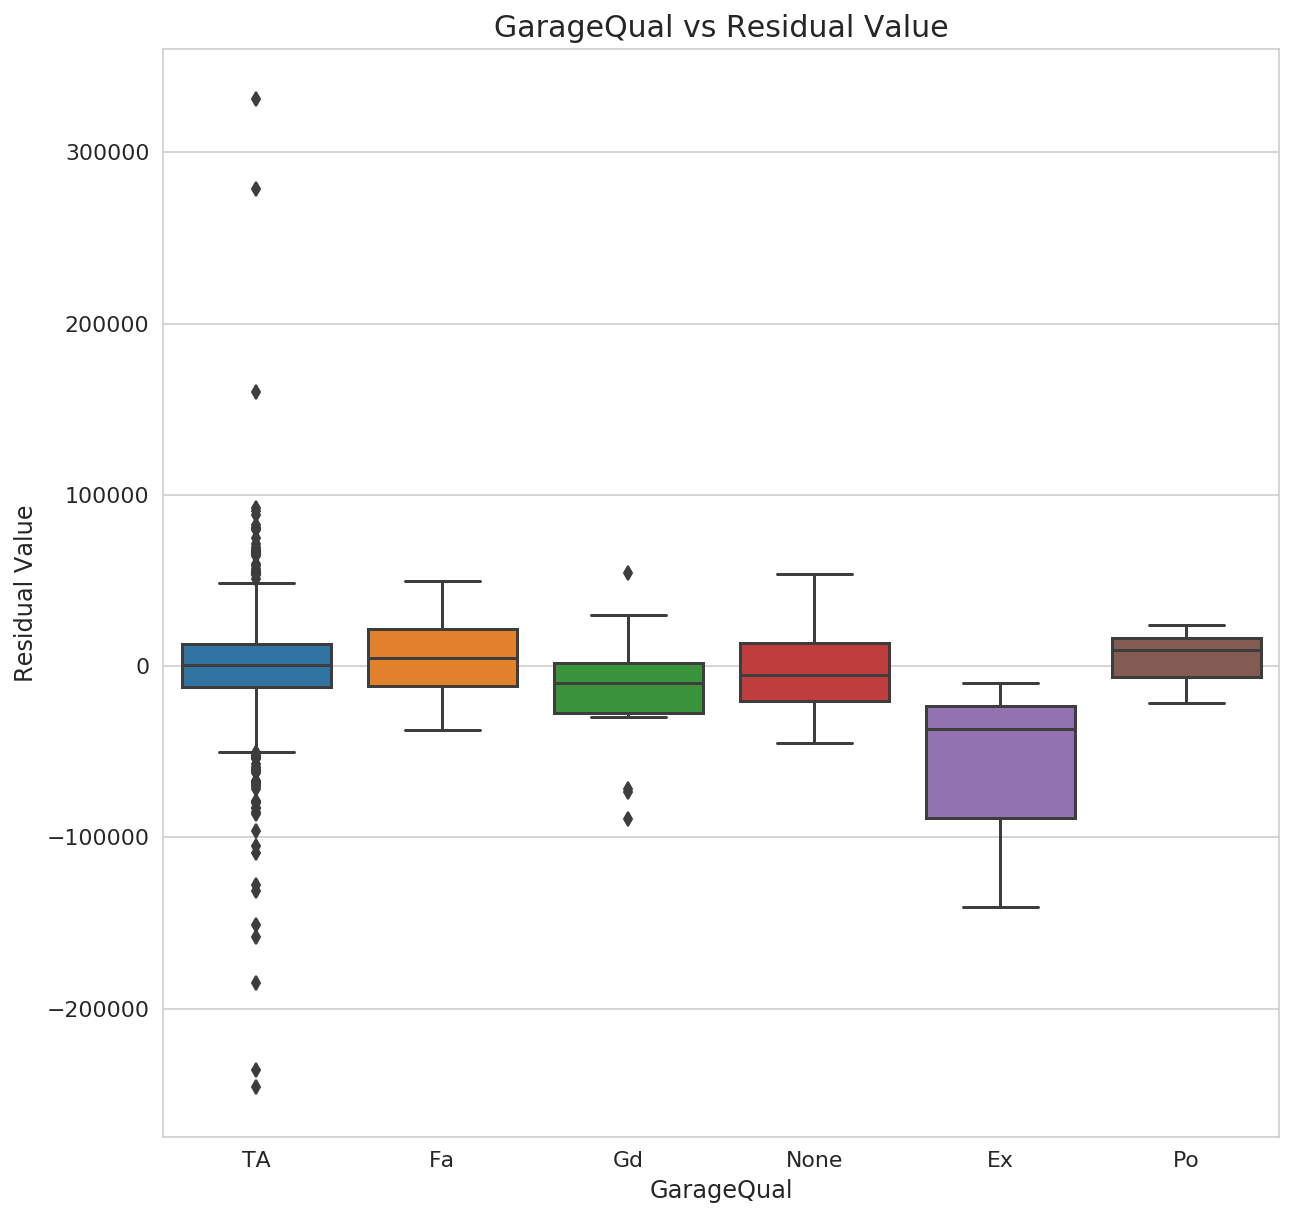

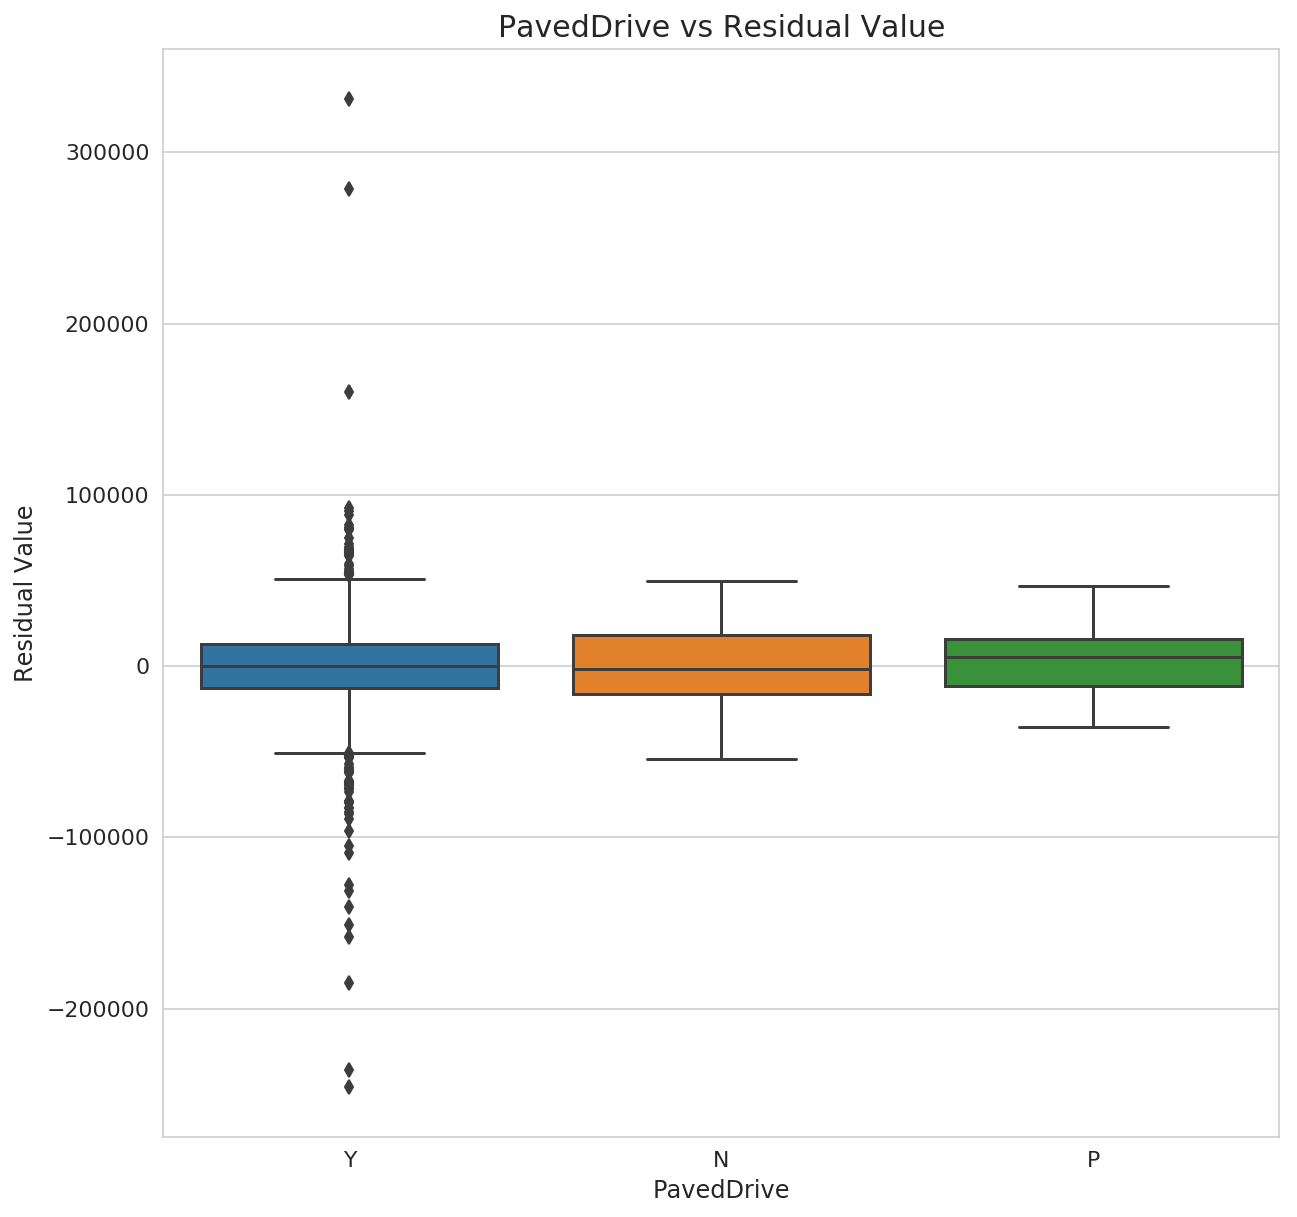

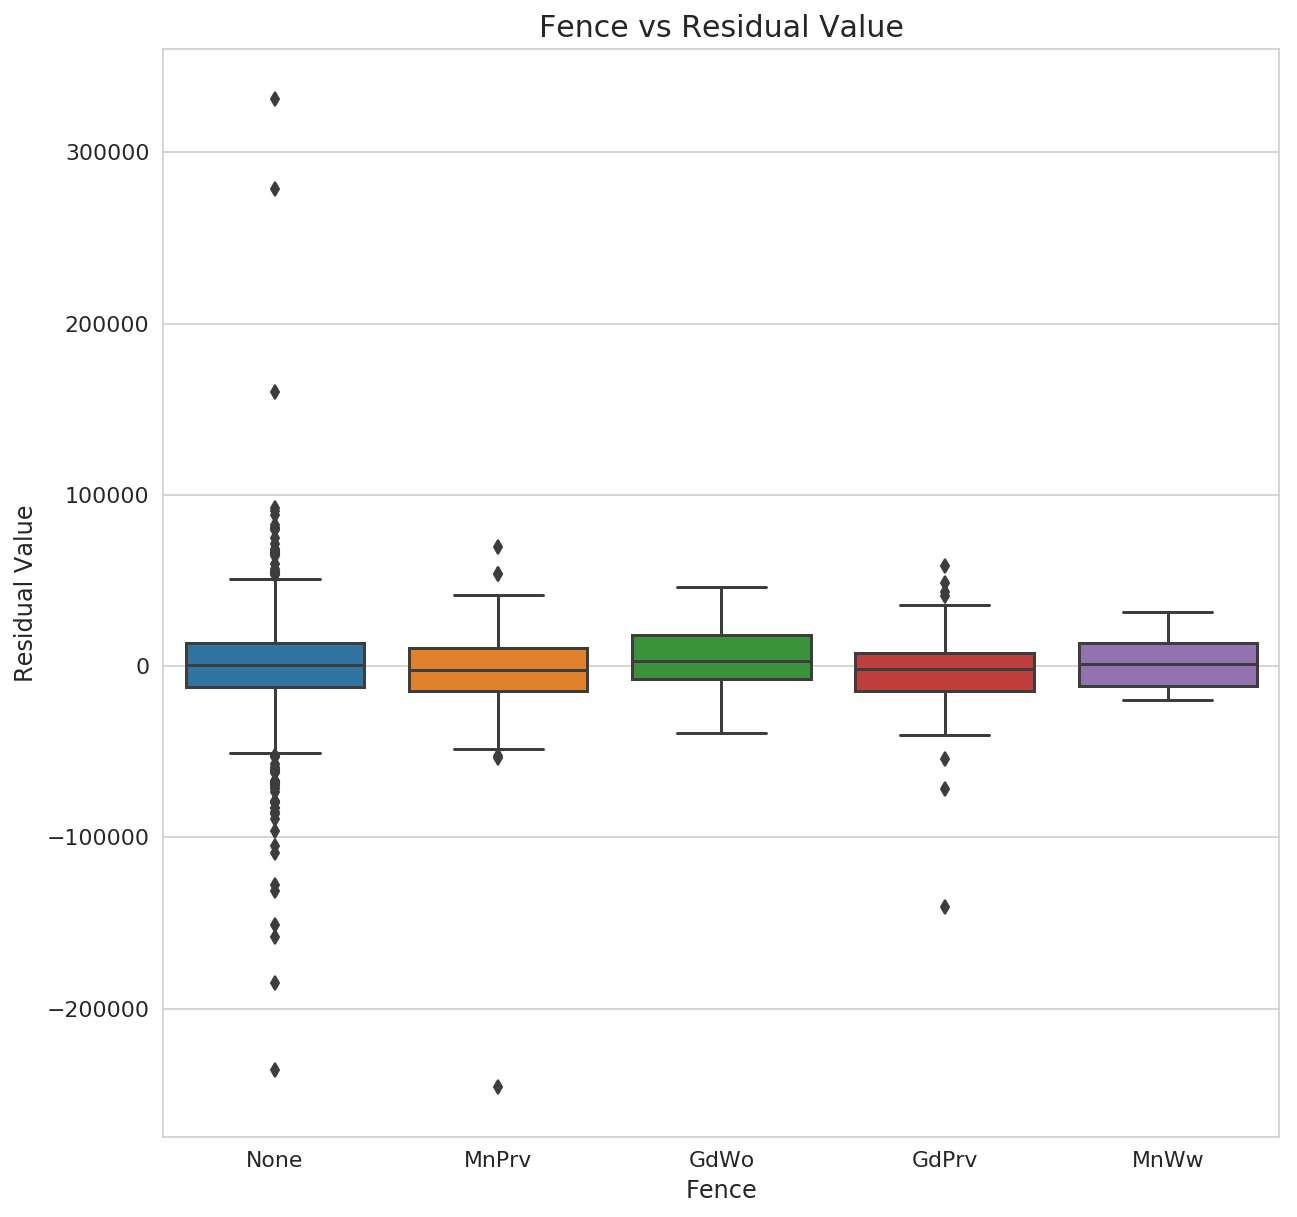

In [45]:
#Let's look at some renovatable features and pick features that exihibit relation to residual house value to see
#if they are a good predictor of the residual house value.

potential_features = ['Alley', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd','MasVnrType',
                      'ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2','HeatingQC',
                      'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','PavedDrive','Fence']

for feature in potential_features:
    f, ax = plt.subplots(figsize=(10,10))
    sns.boxplot(data=house, x=feature, y='SalePrice_resid1', ax=ax)
    
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Residual Value', fontsize=12)
    ax.set_title('{} vs Residual Value' .format(feature), fontsize=15)
    ax.tick_params(axis='both', labelsize=11)
    
    plt.show()

<font color='blue'>

Observations:
1. OverallQual - Model overpredicts (+ve residual) when Overall quality is <5, and underpredicts when quality increases >5.

2. OverallCond - Same as OverallQual

3. Exterqual - Model tend to underpredict Ex, overpredict Fa.

4. KitchenQual - Model tend to underpredict Ex.

5. Functional - Model always overpredict.

6. GarageQual - Overpredicts poor, underpredicts Ex.

<font color='blue'>

### 2.2  Data Preparation for Modeling

In [46]:
#Target Feature
y = house['SalePrice_resid1']

#Selected features
selected_features = ['OverallQual', 'OverallCond', 'ExterQual', 'KitchenQual', 'Functional', 'GarageQual']
X = house[selected_features]
X = pd.get_dummies(X, drop_first=True)

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train = X.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test = X.iloc[index_2010,:]
y_test = y.iloc[index_2010]

<font color='blue'>

### 2.3  Modeling

<font color='blue'>

#### 2.3.1 Linear Regression

In [47]:
lr = LinearRegression()

lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=10)
lr_mean_cv_score = np.mean(lr_cv_scores)
lr_std_cv_score = np.std(lr_cv_scores)

model = lr.fit(X_train, y_train)
lr_test_score =  model.score(X_test, y_test)
lr_mse = mean_squared_error(y_test, model.predict(X_test))

print("CV scores: {}" .format(lr_cv_scores))
print("Mean CV score: {}" .format(lr_mean_cv_score))
print("CV Score STD: {}" .format(lr_std_cv_score))
print("Score on Test Set: {}" .format(lr_test_score))
print("Mean Squared Error: {}" .format(lr_mse))

CV scores: [-9.67514219e-02  2.56086389e-01  7.56097252e-02 -2.70153381e+23
  2.02998958e-01  1.22663499e-01  2.77246535e-02  2.42705016e-01
  4.28583505e-02 -2.42610649e-02]
Mean CV score: -2.70153380680055e+22
CV Score STD: 8.104601420401648e+22
Score on Test Set: 0.16339671517970544
Mean Squared Error: 641782416.5885918


<font color='blue'>

#### 2.3.2 Ridge Regression

In [48]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_mean_cv_score = np.mean(ridge_cv_scores)
ridge_std_cv_score = np.std(ridge_cv_scores)

ridge_model = ridge.fit(X_train, y_train)
ridge_test_score = ridge_model.score(X_test, y_test)
ridge_mse = mean_squared_error(y_test, ridge_model.predict(X_test))

print("CV scores: {}" .format(ridge_cv_scores))
print("Mean CV score: {}" .format(ridge_mean_cv_score))
print("CV Score STD: {}" .format(ridge_std_cv_score))
print("Score on Test Set: {}" .format(ridge_test_score))
print("Mean Squared Error: {}" .format(ridge_mse))

CV scores: [-0.08510544  0.20077934  0.1119958  -0.04339214  0.191136    0.16290907
  0.08572552  0.21864447  0.03760779  0.04249414]
Mean CV score: 0.09227945575768118
CV Score STD: 0.09913270922071216
Score on Test Set: 0.15931998891392718
Mean Squared Error: 644909790.4372176


<font color='blue'>

#### 2.3.3 Lasso Regression

In [49]:
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_mean_cv_score = np.mean(lasso_cv_scores)
lasso_std_cv_score = np.std(lasso_cv_scores)

lasso_model = lasso.fit(X_train, y_train)
lasso_test_score = lasso_model.score(X_test, y_test)
lasso_mse = mean_squared_error(y_test, lasso_model.predict(X_test))

print("CV scores: {}" .format(lasso_cv_scores))
print("Mean CV score: {}" .format(lasso_mean_cv_score))
print("CV Score STD: {}" .format(lasso_std_cv_score))
print("Score on Test Set: {}" .format(lasso_test_score))
print("Mean Squared Error: {}" .format(lasso_mse))

CV scores: [-0.1067994   0.23123953  0.10227614 -0.07050381  0.19260319  0.15712451
  0.06230832  0.23503209  0.04423339  0.02906798]
Mean CV score: 0.08765819515130388
CV Score STD: 0.11277299549528279
Score on Test Set: 0.16075750667480726
Mean Squared Error: 643807029.2609154


<font color='blue'>

#### 2.3.3+ Run Ridge Regression on Remaining (non-zero) Coefficients from Lasso Regression

In [50]:
#Look at coefficients after Lasso:
lasso_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso_model.coef_, 
                               'abs_coef':np.abs(lasso_model.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

#Display the (top-10) non-zero coefficients
lasso_coefs[lasso_coefs.abs_coef>0].head(10)

,variable,coef,abs_coef
0,OverallQual_10,-34032.000498,34032.000498
8,OverallQual_9,-28304.565314,28304.565314
16,OverallCond_9,-27691.435410,27691.435410
15,OverallCond_8,-14867.359171,14867.359171
10,OverallCond_3,14699.062689,14699.062689
14,OverallCond_7,-14170.704979,14170.704979
28,Functional_Typ,-12172.567388,12172.567388
29,GarageQual_Fa,10297.139657,10297.139657
13,OverallCond_6,-7965.593656,7965.593656
21,KitchenQual_Gd,7616.659597,7616.659597


In [51]:
#Run Ridge with remaining Coefficients:
col_lasso = lasso_coefs[lasso_coefs['coef'] != 0]['variable'].values.tolist()

X_train_lasridge = X_train[col_lasso]
X_test_lasridge = X_test[col_lasso]

#Ridge Regression on Remaining Lasso Coefficients
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_lasridge, y_train)

lasridge = Ridge(alpha=optimal_ridge.alpha_)

lasridge_cv_scores = cross_val_score(lasridge, X_train_lasridge, y_train, cv=10)
lasridge_mean_cv_score = np.mean(lasridge_cv_scores)
lasridge_std_cv_score = np.std(lasridge_cv_scores)

lasridge_model = lasridge.fit(X_train_lasridge, y_train)
lasridge_test_score = lasridge_model.score(X_test_lasridge, y_test)
lasridge_mse = mean_squared_error(y_test, lasridge_model.predict(X_test_lasridge))

print("CV scores: {}" .format(lasridge_cv_scores))
print("Mean CV score: {}" .format(lasridge_mean_cv_score))
print("CV Score STD: {}" .format(lasridge_std_cv_score))
print("Score on Test Set: {}" .format(lasridge_test_score))
print("Mean Squared Error: {}" .format(lasridge_mse))

CV scores: [-0.07849285  0.22198143  0.11752226 -0.04393242  0.19706543  0.16391717
  0.07430892  0.23475683  0.04724894  0.04539867]
Mean CV score: 0.09797743681446128
CV Score STD: 0.10286512906616953
Score on Test Set: 0.16007165511067656
Mean Squared Error: 644333165.7012515


<font color='blue'>

#### 2.3.4 Enet Regression

In [52]:
#Find optimum l1_ration and Alpha:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(X_train, y_train)

print("Optimal Alpha: {}" .format(optimal_enet.alpha_))
print("Optimal l1 Ratio: {}" .format(optimal_enet.l1_ratio_))
print("-"*40)
print("")

#Enet Scores
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_cv_scores = cross_val_score(enet, X_train, y_train, cv=10)
enet_mean_cv_score = np.mean(enet_cv_scores)
enet_std_cv_score = np.std(enet_cv_scores)

enet_model = enet.fit(X_train, y_train)
enet_test_score = enet_model.score(X_test, y_test)
enet_mse = mean_squared_error(y_test, enet_model.predict(X_test))

print("CV scores: {}" .format(enet_cv_scores))
print("Mean CV score: {}" .format(enet_mean_cv_score))
print("CV Score STD: {}" .format(enet_std_cv_score))
print("Score on Test Set: {}" .format(enet_test_score))
print("Mean Squared Error: {}" .format(enet_mse))

Optimal Alpha: 35.74626716590322
Optimal l1 Ratio: 1.0
----------------------------------------

CV scores: [-0.10641416  0.23327704  0.10196328 -0.07076133  0.19373884  0.15637132
  0.06053918  0.23559672  0.04396131  0.02634861]
Mean CV score: 0.08746208128185302
CV Score STD: 0.11332874890416432
Score on Test Set: 0.1608155139045866
Mean Squared Error: 643762530.2483214


<font color='blue'>

#### 2.3.5 Summary of Model Scores

In [53]:
linreg = ['Linear Regression', lr_mean_cv_score, lr_std_cv_score, lr_test_score, lr_mse]
ridge = ['Ridge', ridge_mean_cv_score, ridge_std_cv_score, ridge_test_score, ridge_mse]
lasso = ['Lasso', lasso_mean_cv_score, lasso_std_cv_score, lasso_test_score, lasso_mse]
lasridge = ['Lasso + Ridge (non-zero coefficients)', lasridge_mean_cv_score, lasridge_std_cv_score, 
             lasridge_test_score, lasridge_mse]
enet= ['Enet', enet_mean_cv_score, enet_std_cv_score, enet_test_score, enet_mse]

summary = pd.DataFrame(columns = ['Model', 'Average CV Score', 'CV Score STD', 'Test Score', 
                                     'Mean-squared Error'])

for i, model in enumerate([linreg, ridge, lasso, lasridge, enet]):
    summary.loc[i,:] = model
    
summary.sort_values('Test Score', ascending=False)

,Model,Average CV Score,CV Score STD,Test Score,Mean-squared Error
0,Linear Regression,-2.70153e+22,8.1046e+22,0.163397,6.41782e+08
4,Enet,0.0874621,0.113329,0.160816,6.43763e+08
2,Lasso,0.0876582,0.112773,0.160758,6.43807e+08
3,Lasso + Ridge (non-zero coefficients),0.0979774,0.102865,0.160072,6.44333e+08
1,Ridge,0.0922795,0.0991327,0.15932,6.4491e+08


<font color='blue'>

Observations:
1. The R2 scores for all models are very low.

2. Even though Linear Regression model has the best R2 score, the standard deviation of the CV score is very high, indicating that the model is overfitting. Hence,we pick Lasso (Enet has l1 ratio=1, which is equivalent to Lasso Regularization) as the best model.

<font color='blue'>

### 2.4 Model Visualization

In [54]:
#Get SalePrice predictions from Model
y_hat = lasso_model.predict(X)

#Append predicted price to original house DF
house['SalePrice_predict2'] = y_hat

#Calculate the residual of predictions
house['SalePrice_resid2'] = house['SalePrice_predict2'] - house['SalePrice_resid1']


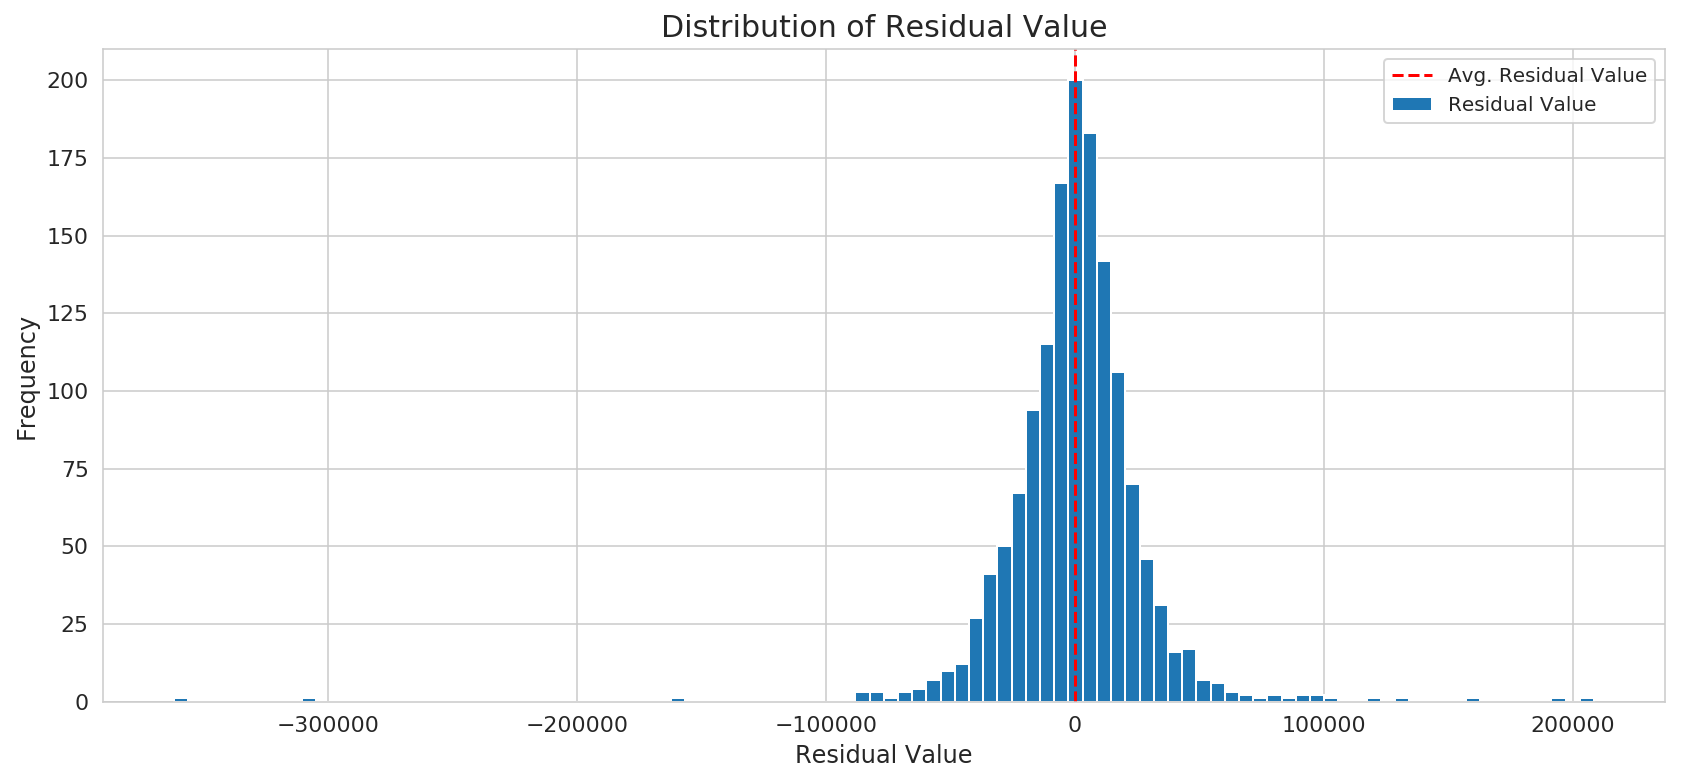

In [55]:
#Distribution plot of Prediction Residual

f, ax = plt.subplots(figsize=(14,6))

ax.hist(x=house['SalePrice_resid2'], bins=100, label='Residual Value')
ax.axvline(np.mean(house['SalePrice_resid2']), color='r', linestyle='--', label='Avg. Residual Value')

ax.set_xlabel('Residual Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Residual Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend()

plt.show()

<font color='blue'>

Observations:
1. From the histogram, the residuals are distributed normally. 

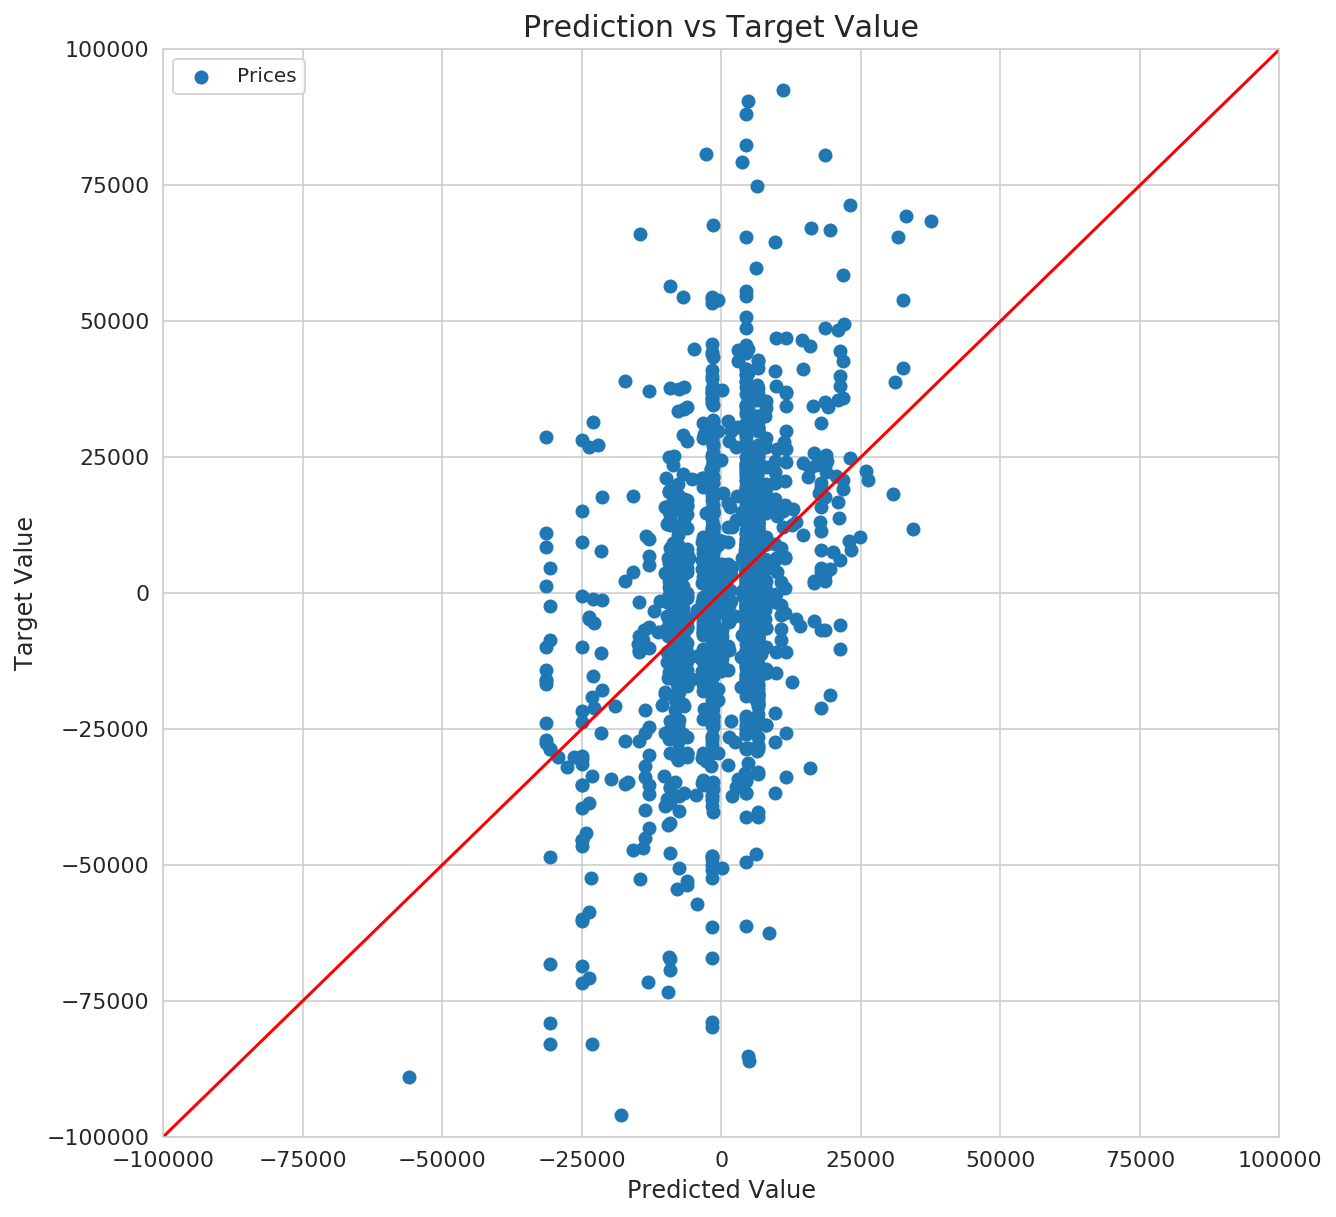

In [56]:
#Plot Scatter Plot of Prediction vs Target

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice_predict2'], y=house['SalePrice_resid1'], label='Prices')
ax.plot((-100000,100000), (-100000,100000), c='red')

ax.set_xlim(-100000, 100000)
ax.set_ylim(-100000, 100000)

ax.set_xlabel('Predicted Value', fontsize=12)
ax.set_ylabel('Target Value', fontsize=12)
ax.set_title('Prediction vs Target Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper left')

plt.show()

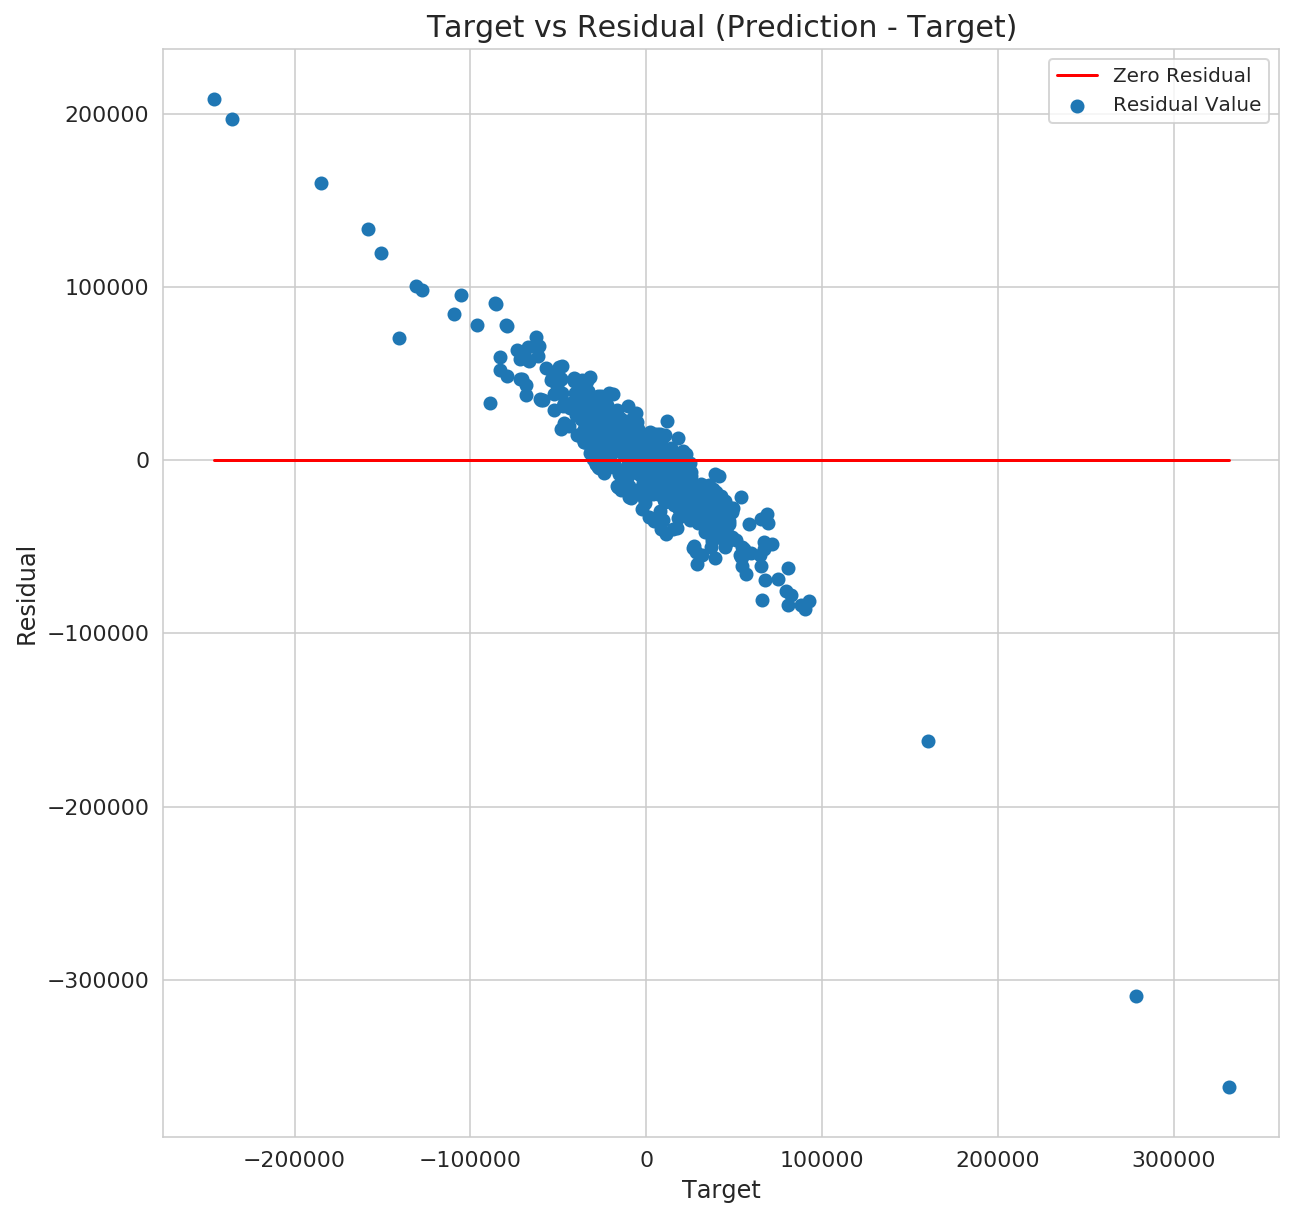

In [57]:
#Scatter Plot of Prediction vs Residual

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice_resid1'], y=house['SalePrice_resid2'], label='Residual Value')
ax.plot((house['SalePrice_resid1'].min(),house['SalePrice_resid1'].max()), (0,0), c='red', label='Zero Residual')

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)
ax.set_title('Target vs Residual (Prediction - Target)', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper right')

plt.show()

<font color='blue'>

Observations:
1. There is an interesting pattern on the Target vs Residual Plot. The residual are distributed in a linear manner. This may indicate some pattern in the data that is not predicted by our model.

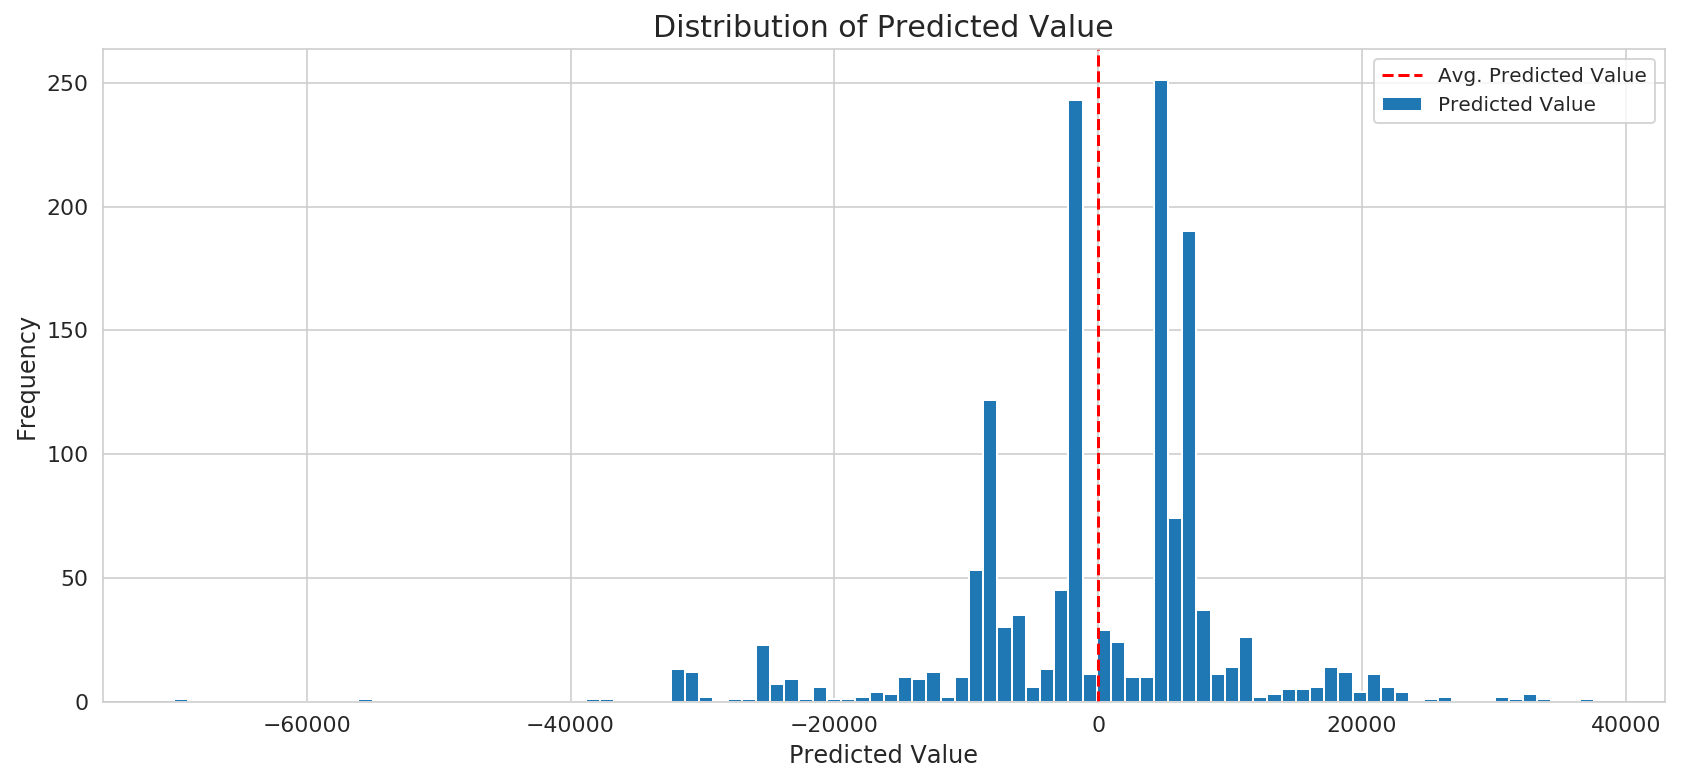

In [58]:
#Distribution plot of Predicted Value

f, ax = plt.subplots(figsize=(14,6))

ax.hist(x=house['SalePrice_predict2'], bins=100, label='Predicted Value')
ax.axvline(np.mean(house['SalePrice_predict2']), color='r', linestyle='--', label='Avg. Predicted Value')

ax.set_xlabel('Predicted Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Predicted Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend()

plt.show()

<font color='blue'>

Observations:
1. The predictions are clusterd to only 4 most frequent bins and not distributed normally as we would expect (given that the target variable is distributed normally).

<font color='blue'>

### 2.4 Try Modeling with All Renovatable Features

In [59]:
X = house[reno_char]

#Standardize the quantitative predictor variables
quant_feat = [f for f in reno_char if f in quant_features]
Xs = X
Xs[quant_feat] = Xs[quant_feat].apply(lambda x: (x-np.mean(x))/np.std(x))

#Create dummy variables for the categorical variables
Xs = pd.get_dummies(Xs, drop_first=True)

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train = Xs.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test = Xs.iloc[index_2010,:]
y_test = y.iloc[index_2010]

<font color='blue'>

#### 2.4.1 Linear Regression

In [60]:
lr = LinearRegression()

lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=10)
lr_mean_cv_score = np.mean(lr_cv_scores)
lr_std_cv_score = np.std(lr_cv_scores)

model = lr.fit(X_train, y_train)
lr_test_score =  model.score(X_test, y_test)
lr_mse = mean_squared_error(y_test, model.predict(X_test))

print("CV scores: {}" .format(lr_cv_scores))
print("Mean CV score: {}" .format(lr_mean_cv_score))
print("CV Score STD: {}" .format(lr_std_cv_score))
print("Score on Test Set: {}" .format(lr_test_score))
print("Mean Squared Error: {}" .format(lr_mse))

CV scores: [-1.20908557e+23 -1.83293085e+22 -2.21435731e+24 -3.25496863e+23
 -5.69552576e+20  4.16939046e-03 -5.93277877e+23  1.22443033e-01
 -1.31578392e+21 -7.76716354e+22]
Mean CV score: -3.351926882615386e+23
CV Score STD: 6.525912595808474e+23
Score on Test Set: -5.6263869957576524e+20
Mean Squared Error: 4.3161631185510005e+29


<font color='blue'>

#### 2.4.2 Ridge Regression

In [61]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_mean_cv_score = np.mean(ridge_cv_scores)
ridge_std_cv_score = np.std(ridge_cv_scores)

ridge_model = ridge.fit(X_train, y_train)
ridge_test_score = ridge_model.score(X_test, y_test)
ridge_mse = mean_squared_error(y_test, ridge_model.predict(X_test))

print("CV scores: {}" .format(ridge_cv_scores))
print("Mean CV score: {}" .format(ridge_mean_cv_score))
print("CV Score STD: {}" .format(ridge_std_cv_score))
print("Score on Test Set: {}" .format(ridge_test_score))
print("Mean Squared Error: {}" .format(ridge_mse))

CV scores: [-0.08497794  0.04181792  0.05322037  0.01375257  0.13824299  0.0762207
  0.09985617  0.16636241 -0.03779493  0.05219361]
Mean CV score: 0.05188938658436657
CV Score STD: 0.07196353208327282
Score on Test Set: 0.12608230378142304
Mean Squared Error: 670407373.668356


<font color='blue'>

#### 2.4.3 Lasso Regression

In [62]:
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_mean_cv_score = np.mean(lasso_cv_scores)
lasso_std_cv_score = np.std(lasso_cv_scores)

lasso_model = lasso.fit(X_train, y_train)
lasso_test_score = lasso_model.score(X_test, y_test)
lasso_mse = mean_squared_error(y_test, lasso_model.predict(X_test))

print("CV scores: {}" .format(lasso_cv_scores))
print("Mean CV score: {}" .format(lasso_mean_cv_score))
print("CV Score STD: {}" .format(lasso_std_cv_score))
print("Score on Test Set: {}" .format(lasso_test_score))
print("Mean Squared Error: {}" .format(lasso_mse))

CV scores: [-0.10375406  0.18230474  0.0601895  -0.00169596  0.19170927  0.11153384
  0.10359933  0.17041564  0.02319128 -0.07722235]
Mean CV score: 0.06602712279818435
CV Score STD: 0.0997484090726446
Score on Test Set: 0.13181617799013723
Mean Squared Error: 666008754.0204854


<font color='blue'>

#### 2.4.3+ Run Ridge Regression on Remaining (non-zero) Coefficients from Lasso Regression

In [63]:
#Look at coefficients after Lasso:
lasso_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso_model.coef_, 
                               'abs_coef':np.abs(lasso_model.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

#Display the (top-10) non-zero coefficients
lasso_coefs[lasso_coefs.abs_coef>0].head(10)

,variable,coef,abs_coef
32,RoofMatl_WdShngl,-45128.972332,45128.972332
9,OverallQual_10,-30332.075010,30332.075010
17,OverallQual_9,-26616.413299,26616.413299
35,Exterior1st_BrkFace,-15946.288557,15946.288557
19,OverallCond_3,14755.953030,14755.953030
110,Functional_Typ,-11707.472325,11707.472325
25,OverallCond_9,-10595.855738,10595.855738
132,PoolQC_Gd,9222.767308,9222.767308
20,OverallCond_4,8229.811887,8229.811887
21,OverallCond_5,7872.626482,7872.626482


In [64]:
#Run Ridge with remaining Coefficients:
col_lasso = lasso_coefs[lasso_coefs['coef'] != 0]['variable'].values.tolist()

X_train_lasridge = X_train[col_lasso]
X_test_lasridge = X_test[col_lasso]

#Ridge Regression on Remaining Lasso Coefficients
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_lasridge, y_train)

lasridge = Ridge(alpha=optimal_ridge.alpha_)

lasridge_cv_scores = cross_val_score(lasridge, X_train_lasridge, y_train, cv=10)
lasridge_mean_cv_score = np.mean(lasridge_cv_scores)
lasridge_std_cv_score = np.std(lasridge_cv_scores)

lasridge_model = lasridge.fit(X_train_lasridge, y_train)
lasridge_test_score = lasridge_model.score(X_test_lasridge, y_test)
lasridge_mse = mean_squared_error(y_test, lasridge_model.predict(X_test_lasridge))

print("CV scores: {}" .format(lasridge_cv_scores))
print("Mean CV score: {}" .format(lasridge_mean_cv_score))
print("CV Score STD: {}" .format(lasridge_std_cv_score))
print("Score on Test Set: {}" .format(lasridge_test_score))
print("Mean Squared Error: {}" .format(lasridge_mse))

CV scores: [-0.06529824  0.16781735  0.08255513  0.0366333   0.21768996  0.11371032
  0.09366308  0.20324441  0.02778231  0.05707245]
Mean CV score: 0.09348700711150991
CV Score STD: 0.08222822089777593
Score on Test Set: 0.12387295733205261
Mean Squared Error: 672102226.8073356


<font color='blue'>

#### 2.4.4 Enet Regression

In [65]:
#Find optimum l1_ration and Alpha:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(X_train, y_train)

print("Optimal Alpha: {}" .format(optimal_enet.alpha_))
print("Optimal l1 Ratio: {}" .format(optimal_enet.l1_ratio_))
print("-"*40)
print("")

#Enet Scores
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_cv_scores = cross_val_score(enet, X_train, y_train, cv=10)
enet_mean_cv_score = np.mean(enet_cv_scores)
enet_std_cv_score = np.std(enet_cv_scores)

enet_model = enet.fit(X_train, y_train)
enet_test_score = enet_model.score(X_test, y_test)
enet_mse = mean_squared_error(y_test, enet_model.predict(X_test))

print("CV scores: {}" .format(enet_cv_scores))
print("Mean CV score: {}" .format(enet_mean_cv_score))
print("CV Score STD: {}" .format(enet_std_cv_score))
print("Score on Test Set: {}" .format(enet_test_score))
print("Mean Squared Error: {}" .format(enet_mse))

Optimal Alpha: 122.85135824225904
Optimal l1 Ratio: 1.0
----------------------------------------

CV scores: [-0.10815213  0.18806926  0.0621987  -0.00362006  0.20343276  0.10918473
  0.09309003  0.16967331  0.0270461  -0.10690993]
Mean CV score: 0.06340127756145432
CV Score STD: 0.10661786728913554
Score on Test Set: 0.13094428758888765
Mean Squared Error: 666677606.1979359


<font color='blue'>

#### 2.4.5 Summary of Model Scores

In [66]:
linreg = ['Linear Regression', lr_mean_cv_score, lr_std_cv_score, lr_test_score, lr_mse]
ridge = ['Ridge', ridge_mean_cv_score, ridge_std_cv_score, ridge_test_score, ridge_mse]
lasso = ['Lasso', lasso_mean_cv_score, lasso_std_cv_score, lasso_test_score, lasso_mse]
lasridge = ['Lasso + Ridge (non-zero coefficients)', lasridge_mean_cv_score, lasridge_std_cv_score, 
             lasridge_test_score, lasridge_mse]
enet= ['Enet', enet_mean_cv_score, enet_std_cv_score, enet_test_score, enet_mse]

summary = pd.DataFrame(columns = ['Model', 'Average CV Score', 'CV Score STD', 'Test Score', 
                                     'Mean-squared Error'])

for i, model in enumerate([linreg, ridge, lasso, lasridge, enet]):
    summary.loc[i,:] = model
    
summary.sort_values('Test Score', ascending=False)

,Model,Average CV Score,CV Score STD,Test Score,Mean-squared Error
2,Lasso,0.0660271,0.0997484,0.131816,6.66009e+08
4,Enet,0.0634013,0.106618,0.130944,6.66678e+08
1,Ridge,0.0518894,0.0719635,0.126082,6.70407e+08
3,Lasso + Ridge (non-zero coefficients),0.093487,0.0822282,0.123873,6.72102e+08
0,Linear Regression,-3.35193e+23,6.52591e+23,-5.62639e+20,4.31616e+29


<font color='blue'>

Observations: The R2 score of all models using All renovatable features are lower than the earlier models with 6 features. Hence, we will not be analyzing in detail on these models.

<font color='blue'>

#### Model Visualization

In [67]:
#Get SalePrice predictions from Model
y_hat = lasso_model.predict(Xs)

#Append predicted price to original house DF
house['SalePrice_predict2'] = y_hat

#Calculate the residual of predictions
house['SalePrice_resid2'] = house['SalePrice_predict2'] - house['SalePrice_resid1']


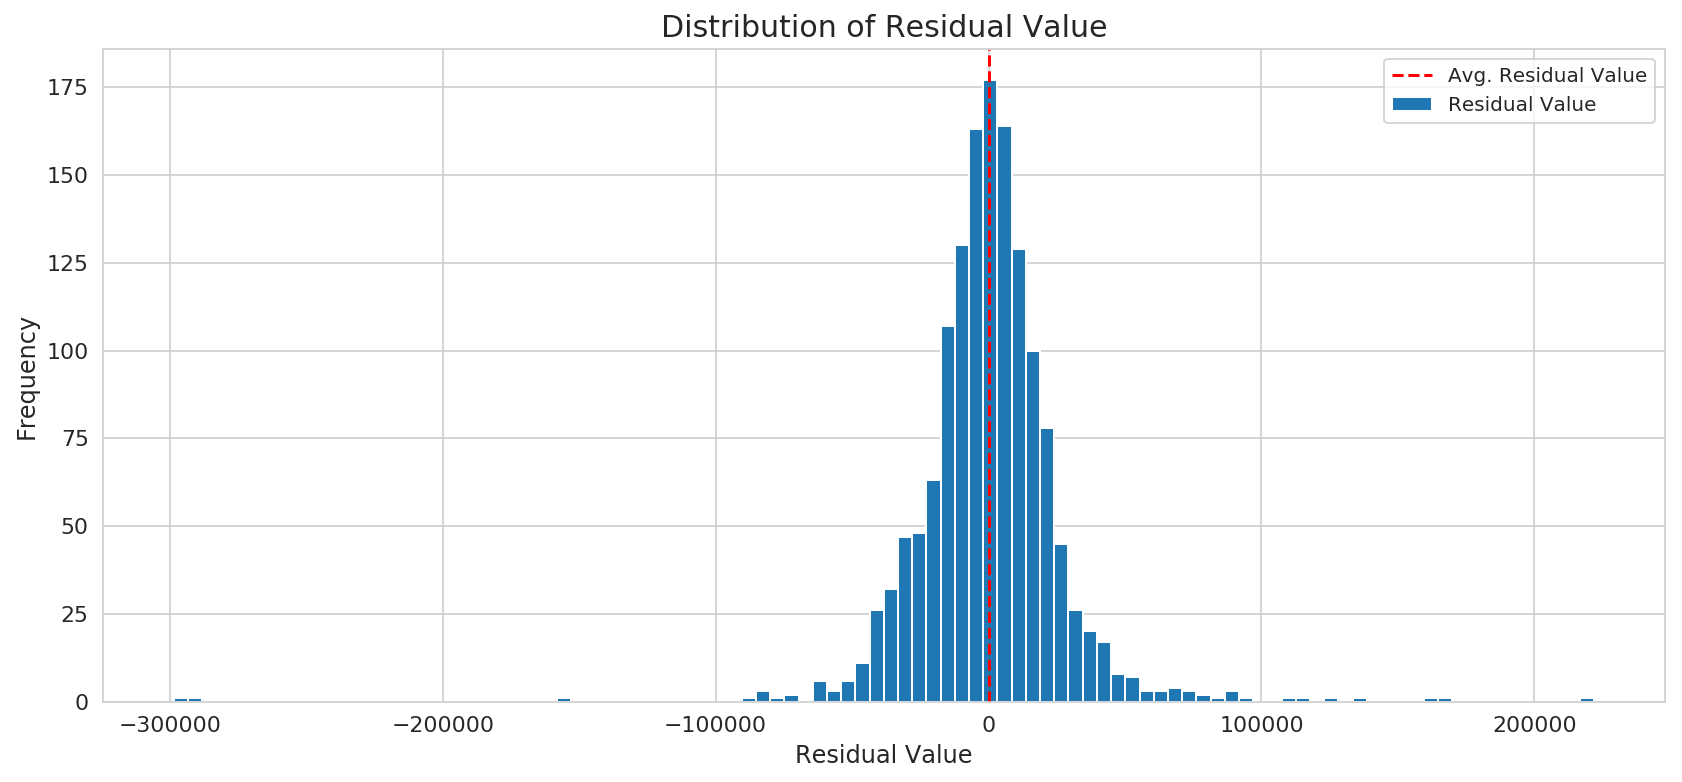

In [68]:
#Distribution plot of Prediction Residual

f, ax = plt.subplots(figsize=(14,6))

ax.hist(x=house['SalePrice_resid2'], bins=100, label='Residual Value')
ax.axvline(np.mean(house['SalePrice_resid2']), color='r', linestyle='--', label='Avg. Residual Value')

ax.set_xlabel('Residual Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Residual Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend()

plt.show()

<font color='blue'>

Observations:
1. From the histogram, the residuals are distributed normally. 

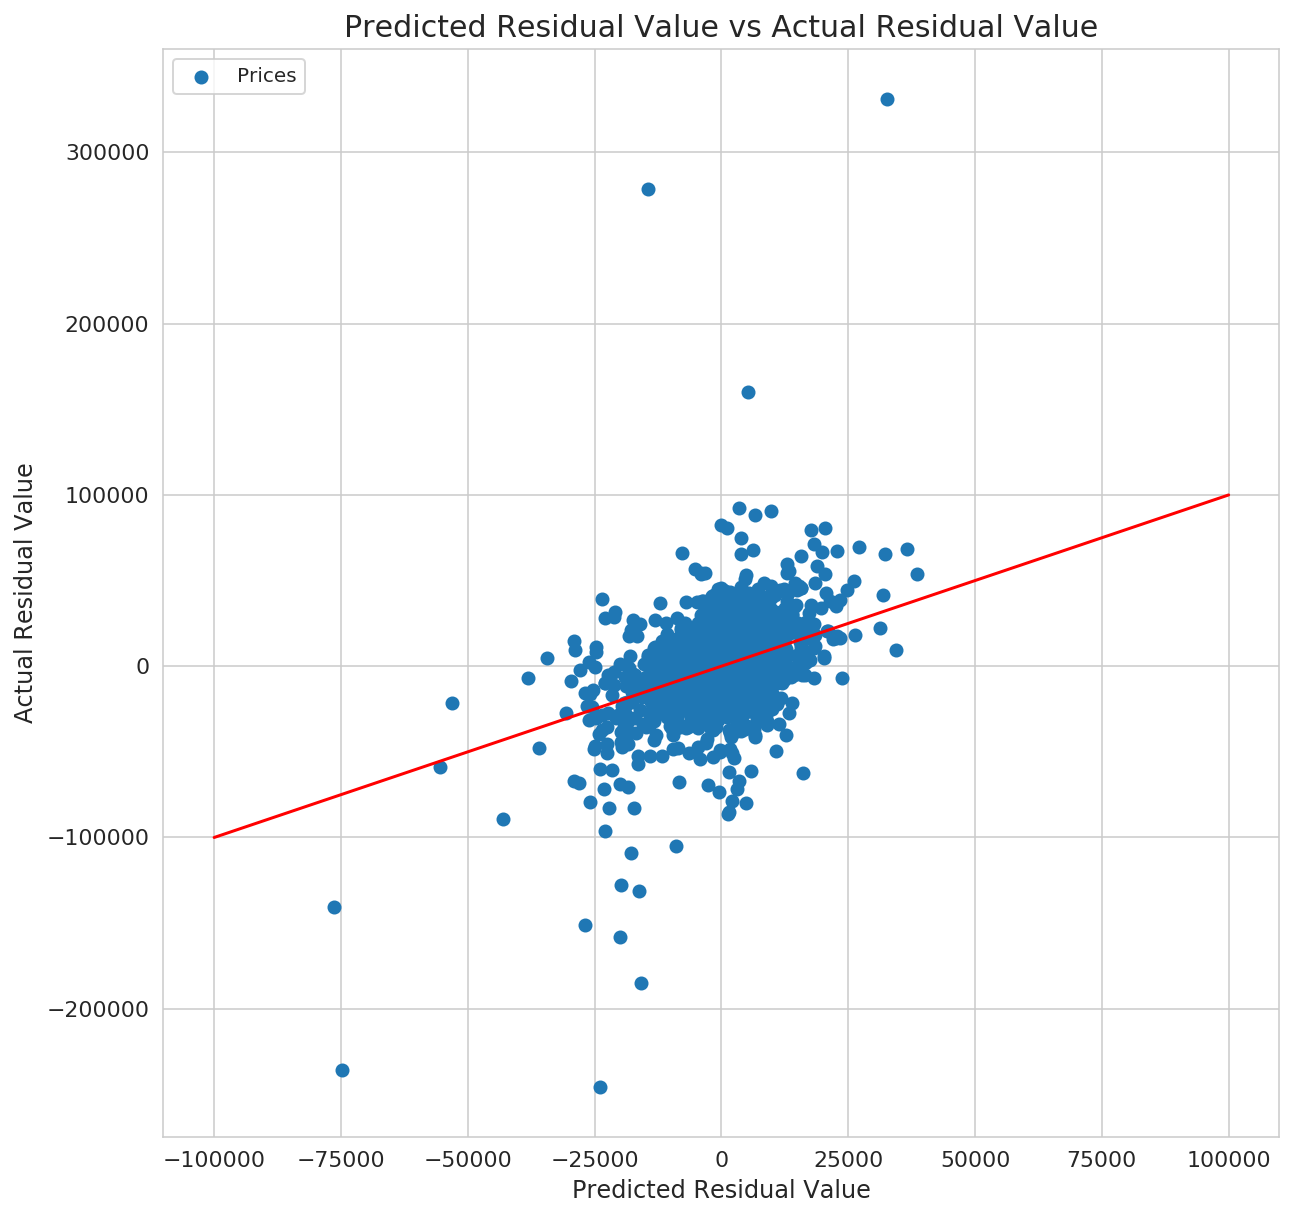

In [69]:
#Plot Scatter Plot of Predicted Price vs Actual Price

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice_predict2'], y=house['SalePrice_resid1'], label='Prices')
ax.plot((-100000,100000), (-100000,100000), c='red')

ax.set_xlabel('Predicted Residual Value', fontsize=12)
ax.set_ylabel('Actual Residual Value', fontsize=12)
ax.set_title('Predicted Residual Value vs Actual Residual Value', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper left')

plt.show()

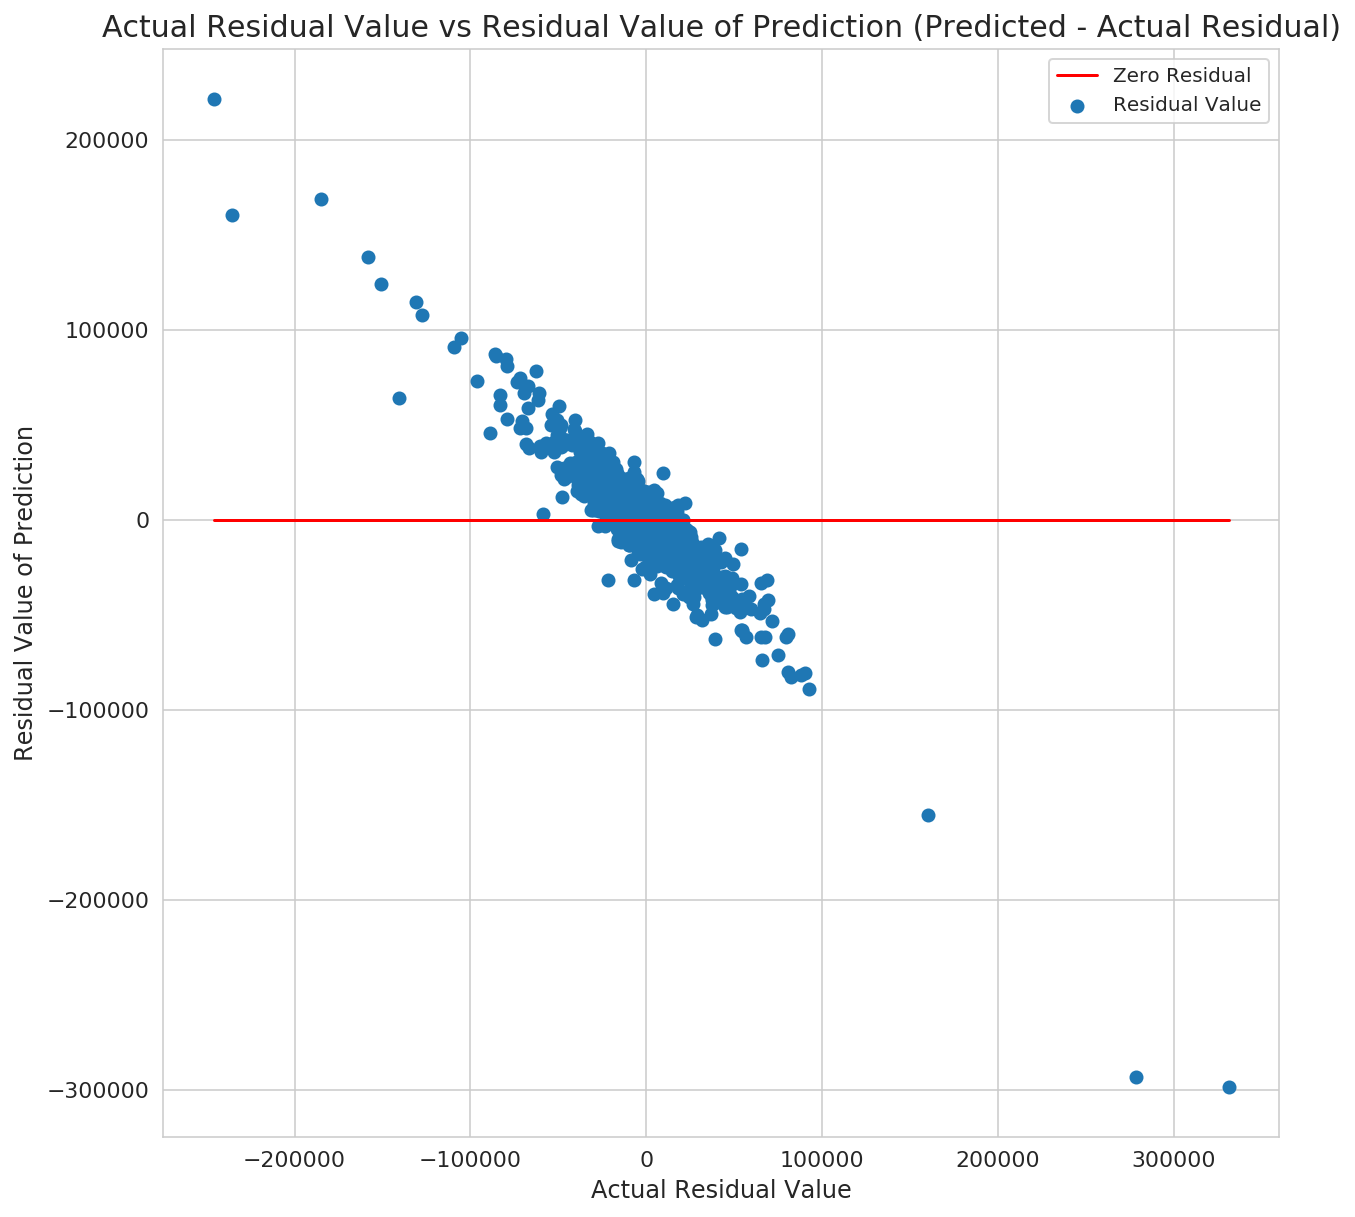

In [70]:
#Plot Scatter Plot of Actual Residual Value vs Residual Value of Prediction

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=house['SalePrice_resid1'], y=house['SalePrice_resid2'], label='Residual Value')
ax.plot((house['SalePrice_resid1'].min(),house['SalePrice_resid1'].max()), (0,0), c='red', label='Zero Residual')

ax.set_xlabel('Actual Residual Value', fontsize=12)
ax.set_ylabel('Residual Value of Prediction', fontsize=12)
ax.set_title('Actual Residual Value vs Residual Value of Prediction (Predicted - Actual Residual)', fontsize=15)

ax.tick_params(axis='both', labelsize=11)

ax.legend(loc='upper right')

plt.show()

<font color='blue'>

### 2.5 Conclusion

<font color='blue'>

1. The models we built using the selected renovatable features yielded weak result (R2 score 0.16). This meant that the model only explained 16% of the variance in the dataset.

2. From the coefficient of our model, the top features predicting the residual value of the property from the prediction in question 1 are Overall Quality and Overall Condition.

3. As the model score is low, it is not advisable to use this model to evaluate which property to purchase and fix up.

<font color='red'>

### Appendix 1: Remove All Non-renovatable Variables with P-value < 0.05, before modeling with Lasso & Ridge 

In [71]:
y = house['SalePrice']

X_cat = house[fixed_cat]
X_quant = house[fixed_quant]

#Standardize the quantitative predictor variables
ss = StandardScaler()
Xs_quant = pd.DataFrame(ss.fit_transform(X_quant), columns=fixed_quant)

#Generate dummy variables for the categorical predictor variables
X_cat_dummy = pd.get_dummies(X_cat, columns=fixed_cat, drop_first=True, prefix=fixed_cat)

#Cocat the standardized and dummy predictor variables
Xs = pd.concat([Xs_quant, X_cat_dummy], axis=1)

#Split the Dataset into train (pre-2010) and test (2010) sets
index_2010 = house[house['YrSold']==2010].index
X_train = Xs.drop(index=index_2010, axis=0)
y_train = y.drop(index=index_2010, axis=0)
X_test = Xs.iloc[index_2010,:]
y_test = y.iloc[index_2010]


#Check P-Value of all Non-renovatable feeatures using Statsmodel OLS

X_train_inter = sm.add_constant(X_train)

sm_model = sm.OLS(y_train, X_train_inter)
sm_model = sm_model.fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     51.90
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:42:41   Log-Likelihood:                -14931.
No. Observations:                1278   AIC:                         3.015e+04
Df Residuals:                    1133   BIC:                         3.090e+04
Df Model:                         144                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.184e+04   2.06e+05      0.397      0.691   -3.23e+05    4.86e+05
LotFrontage           -2056.4713   1086.688     -1.892      0.059   -4188.618      75.675
LotArea                5258.6211   1303.493      4.034      0.000    2701.090    7816.152
YearBuilt             -9685.5335   3233.129     -2.996      0.003    -1.6e+04   -3341.940
MasVnrArea             1243.6768   1123.067      1.107      0.268    -959.849    3447.202
TotalBsmtSF            1632.1625   2486.135      0.657      0.512   -3245.784    6510.109
1stFlrSF               5754.1556   1.01e+04      0.572      0.567    -1.4e+04    2.55e+04
2ndFlrSF                1.87e+04   1.09e+04      1.710      0.087   -2752.529    4.01e+04
GrLivArea               1.92e+04   1.34e+04      1.430      0.153   -7135.337    4.55e+04
BsmtFullBath           5477.9173   1078.225      5.080      0.000    3362.374    7593.460
BsmtHalfBath           2012.2192    904.413      2.225      0.026     237.706    3786.732
FullBath               5196.2846   1667.553      3.116      0.002    1924.445    8468.124
HalfBath               2758.5218   1470.506      1.876      0.061    -126.699    5643.743
BedroomAbvGr          -6027.7930   1510.014     -3.992      0.000   -8990.530   -3065.056
KitchenAbvGr          -5636.5562   1754.124     -3.213      0.001   -9078.253   -2194.859
TotRmsAbvGrd           4030.2853   2136.174      1.887      0.059    -161.016    8221.587
Fireplaces             3596.5812   1188.656      3.026      0.003    1264.367    5928.795
GarageYrBlt             -64.1785   1981.916     -0.032      0.974   -3952.817    3824.460
GarageCars             1.089e+04   2256.430      4.827      0.000    6465.501    1.53e+04
GarageArea            -2096.8049   2268.254     -0.924      0.355   -6547.254    2353.645
WoodDeckSF             1707.7157   1031.134      1.656      0.098    -315.431    3730.862
OpenPorchSF             -13.5559   1037.254     -0.013      0.990   -2048.711    2021.599
EnclosedPorch           640.2544   1031.687      0.621      0.535   -1383.977    2664.486
3SsnPorch              1909.1741    883.416      2.161      0.031     175.859    3642.489
ScreenPorch            3574.2230    957.233      3.734      0.000    1696.075    5452.371
PoolArea                809.1925    980.038      0.826      0.409   -1113.702    2732.087
MiscVal                2333.1517   6428.300      0.363      0.717   -1.03e+04    1.49e+04
LandContour_HLS        1.635e+04   6936.389      2.357      0.019    2738.871       3e+04
LandContour_Low        3799.3124   8958.105      0.424      0.672   -1.38e+04    2.14e+04
LandContour_Lvl        1.106e+04   4923.889      2.246      0.025    1397.490    2.07e+04
Foundation_CBlock      1557.4435   4344.788      0.358      0.720   -6967.292    1.01e+04
Foundation_PConc       

In [72]:
#Extract features with Pvalue >= 0.05
high_p = sm_model.pvalues[sm_model.pvalues >= 0.05].index.tolist()

#Remove the features with Pvalue >= 0.05 and re-model with Ridge Regression
remaining_col = [f for f in X_train.columns if f not in high_p]

X_train_remain = X_train[remaining_col]
X_test_remain = X_test[remaining_col]

#Lasso Regression on remaining columns
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train_remain, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lassopval_cv_scores = cross_val_score(lasso, X_train_remain, y_train, cv=10)
lassopval_mean_cv_score = np.mean(lassopval_cv_scores)
lassopval_std_cv_score = np.std(lassopval_cv_scores)

lasso_model = lasso.fit(X_train_remain, y_train)
lassopval_test_score = lasso_model.score(X_test_remain, y_test)
lassopval_mse = mean_squared_error(y_test, lasso_model.predict(X_test_remain))

print("CV scores: {}" .format(lassopval_cv_scores))
print("Mean CV score: {}" .format(lassopval_mean_cv_score))
print("CV Score STD: {}" .format(lassopval_std_cv_score))
print("Score on Test Set: {}" .format(lassopval_test_score))
print("Mean Squared Error: {}" .format(lassopval_mse))

CV scores: [0.75401391 0.73100569 0.75714125 0.72516612 0.72627657 0.70986047
 0.72555243 0.66784458 0.68227721 0.77599229]
Mean CV score: 0.7255130514014492
CV Score STD: 0.031355484193957305
Score on Test Set: 0.7422821917197548
Mean Squared Error: 1638414962.9811828


In [73]:
#Look at coefficients after Lasso:
lassopval_coefs = pd.DataFrame({'variable':X_train_remain.columns, 'coef':lasso_model.coef_, 
                               'abs_coef':np.abs(lasso_model.coef_)})

lassopval_coefs.sort_values('abs_coef', inplace=True, ascending=False)

#Display the (top-10) non-zero coefficients
lassopval_coefs[lassopval_coefs.abs_coef>0].head(10)

,variable,coef,abs_coef
26,Neighborhood_NoRidge,91163.402360,91163.402360
28,Neighborhood_StoneBr,65752.105606,65752.105606
27,Neighborhood_NridgHt,56490.368914,56490.368914
20,BsmtQual_Gd,-38546.356292,38546.356292
21,BsmtQual_TA,-38353.808666,38353.808666
19,BsmtQual_Fa,-37768.754448,37768.754448
31,LandSlope_Sev,-29199.046334,29199.046334
29,BsmtExposure_Gd,25118.814676,25118.814676
8,GarageCars,20679.976412,20679.976412
24,LotConfig_FR2,-20672.078560,20672.078560


In [74]:
#Check for the P-value of the non-zero variables from Lasso
col_lasso = lassopval_coefs[lassopval_coefs['coef'] != 0]['variable'].values.tolist()

X_train_pval = X_train[col_lasso]
X_train_pval_int = sm.add_constant(X_train_pval)

sm_model = sm.OLS(y_train, X_train_pval_int)
sm_model = sm_model.fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     130.0
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:42:41   Log-Likelihood:                -15337.
No. Observations:                1278   AIC:                         3.073e+04
Df Residuals:                    1248   BIC:                         3.089e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.016e+05   6487.287     31.077      0.000    1.89e+05    2.14e+05
Neighborhood_NoRidge  9.523e+04   7320.096     13.010      0.000    8.09e+04     1.1e+05
Neighborhood_StoneBr   7.15e+04   9353.012      7.644      0.000    5.31e+04    8.98e+04
Neighborhood_NridgHt  5.739e+04   5768.577      9.948      0.000    4.61e+04    6.87e+04
BsmtQual_Gd          -4.151e+04   4229.463     -9.815      0.000   -4.98e+04   -3.32e+04
BsmtQual_TA          -4.235e+04   5164.655     -8.200      0.000   -5.25e+04   -3.22e+04
BsmtQual_Fa          -4.473e+04   8999.722     -4.970      0.000   -6.24e+04   -2.71e+04
LandSlope_Sev        -4.871e+04   1.51e+04     -3.234      0.001   -7.82e+04   -1.92e+04
BsmtExposure_Gd        2.68e+04   4557.513      5.881      0.000    1.79e+04    3.57e+04
GarageCars            2.054e+04   1829.767     11.226      0.000     1.7e+04    2.41e+04
LotConfig_FR2        -2.553e+04   6428.478     -3.971      0.000   -3.81e+04   -1.29e+04
GarageType_None       2.393e+04   6626.677      3.610      0.000    1.09e+04    3.69e+04
Neighborhood_Edwards -2.099e+04   4650.177     -4.515      0.000   -3.01e+04   -1.19e+04
FullBath              1.671e+04   1619.329     10.318      0.000    1.35e+04    1.99e+04
GarageType_BuiltIn    2.039e+04   5785.706      3.524      0.000    9040.785    3.17e+04
LotShape_IR3         -3.026e+04   1.35e+04     -2.246      0.025   -5.67e+04   -3823.261
Fireplaces            1.156e+04   1320.684      8.753      0.000    8968.858    1.42e+04
LotShape_IR2          1.361e+04   7205.197      1.888      0.059    -529.172    2.77e+04
KitchenAbvGr         -9764.3432   1230.704     -7.934      0.000   -1.22e+04   -7349.866
BsmtFullBath          7377.5561   1261.584      5.848      0.000    4902.497    9852.615
LotArea               7944.3520   1478.743      5.372      0.000    5043.255    1.08e+04
GarageType_Attchd     7692.9503   3190.159      2.411      0.016    1434.283     1.4e+04
LandContour_HLS       1.122e+04   7405.737      1.515      0.130   -3311.158    2.57e+04
BedroomAbvGr          5970.2133   1345.151      4.438      0.000    3331.206    8609.220
YearBuilt            -3751.3541   1988.324     -1.887      0.059   -7652.181     149.473
ScreenPorch           4206.5306   1142.062      3.683      0.000    1965.958    6447.104
3SsnPorch             1861.8587   1090.162      1.708      0.088    -276.893    4000.610
BsmtHalfBath          1457.4786   1112.422      1.310      0.190    -724.945    3639.903
BsmtExposure_No        224.4519   2821.328      0.080      0.937   -5310.617    5759.521
LandContour_Lvl       3202.9234   4779.870      0.670      0.503   -6174.545    1.26e+04
==============================================================================
Omnibus:                      394.391   Durbin-Watson:             

<font color='blue'>

Observations: 

1. Using only Lasso Model on the remaining features with Pvalue <0.05, the R2 score is lower than running Lasso with all features.

2. After running the Lasso Model, the Pvalue for some of the remaining coefficients(>0) from the Lasso Model became >0.05. May need to re-peat the pruning of coefficients with P-value >0.05 and re-run Lasso again.


<font color='red'>

### Appendix 2: One potential Feature Engineering on 'LotArea'

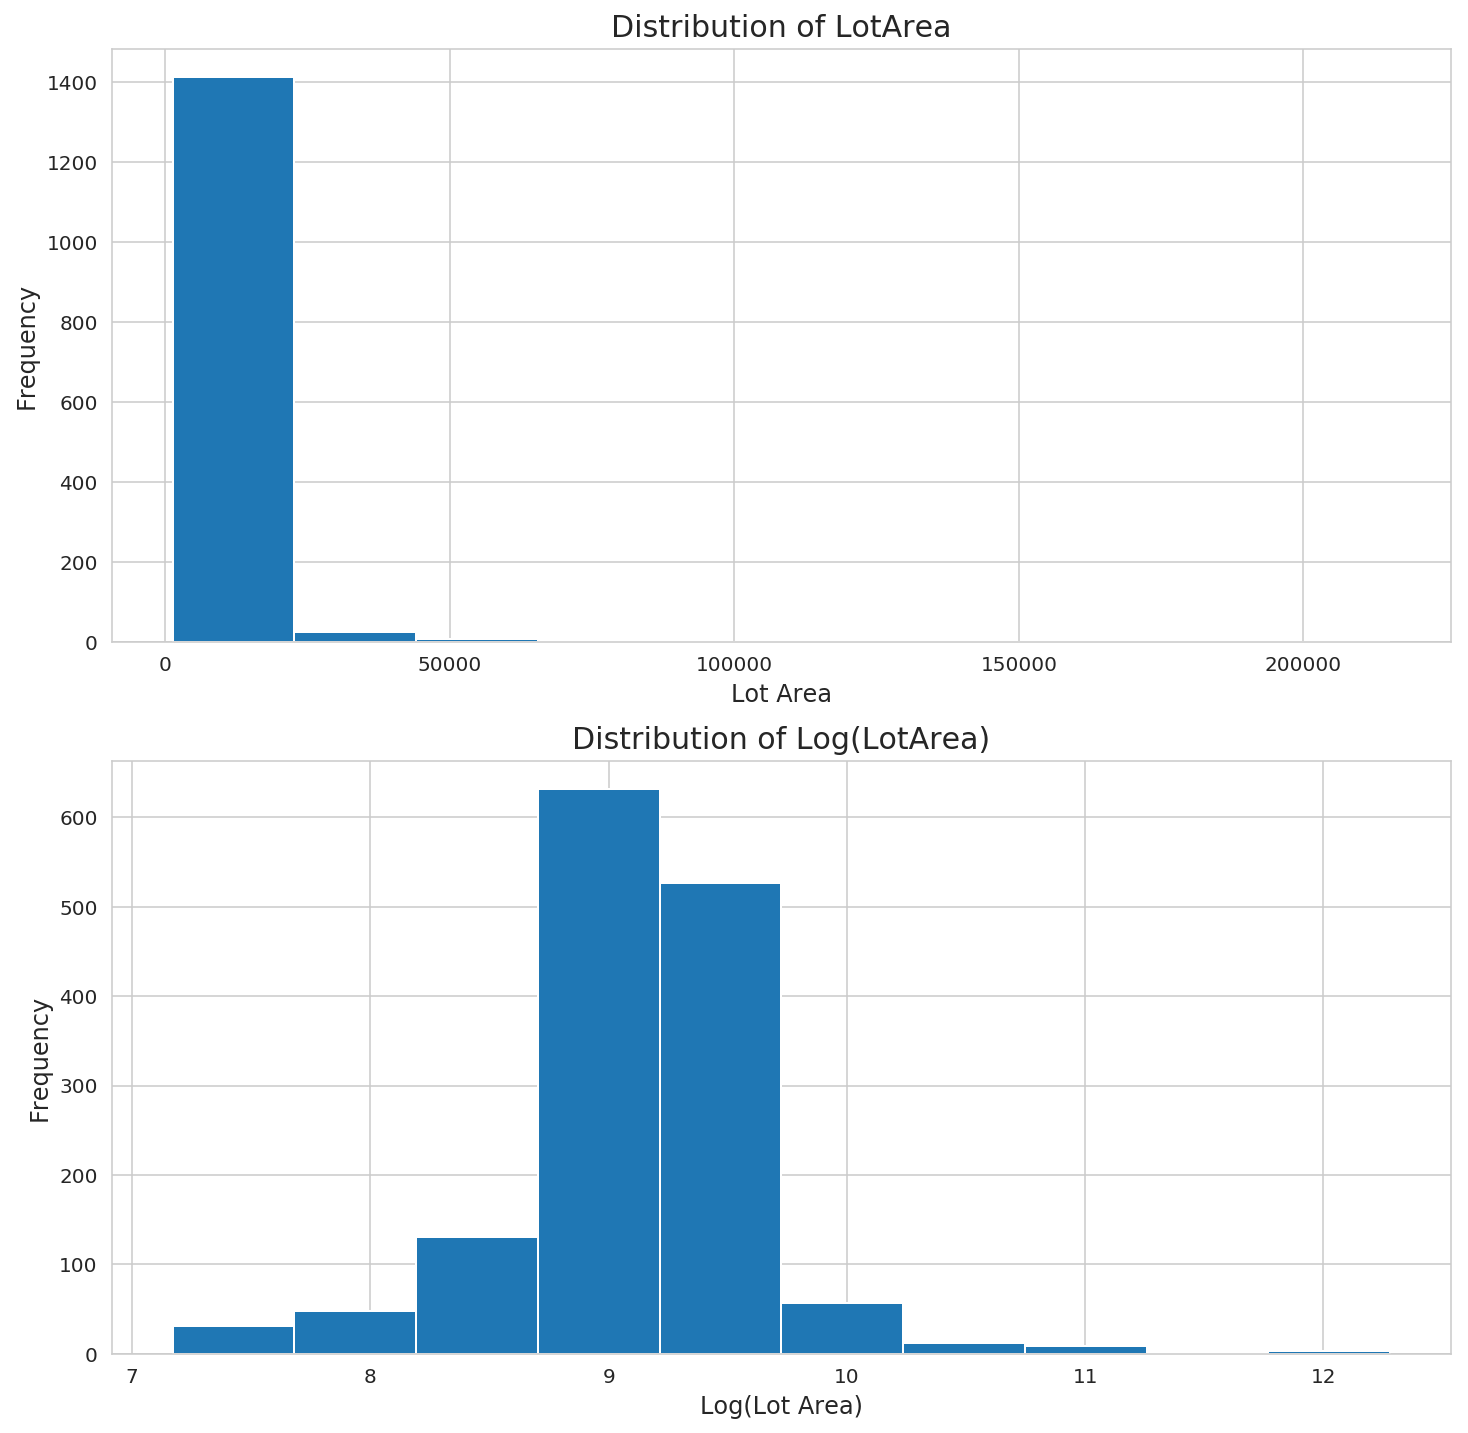

In [75]:
#Plot distribution of LotArea

f, ax = plt.subplots(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.hist(house.LotArea)
ax1.set_xlabel('Lot Area', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of LotArea', fontsize=15)

ax2 = plt.subplot(2,1,2)
ax2.hist(np.log(house.LotArea))
ax2.set_xlabel('Log(Lot Area)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Log(LotArea)', fontsize=15)

plt.show()


<font color='blue'>

Observation:  Outliers in LotArea skewing the distribution. Using Log(LotArea), the distribution approximates to Normal distribution.

In [86]:
house['log_LotArea'] = np.log(house.LotArea)

house[['LotArea','log_LotArea', 'SalePrice']].corr()

,LotArea,log_LotArea,SalePrice
LotArea,1.000000,0.697774,0.264715
log_LotArea,0.697774,1.000000,0.391604
SalePrice,0.264715,0.391604,1.000000


<font color='blue'>

Observation: Increase in correlation to SalePrice with Log(LotArea)

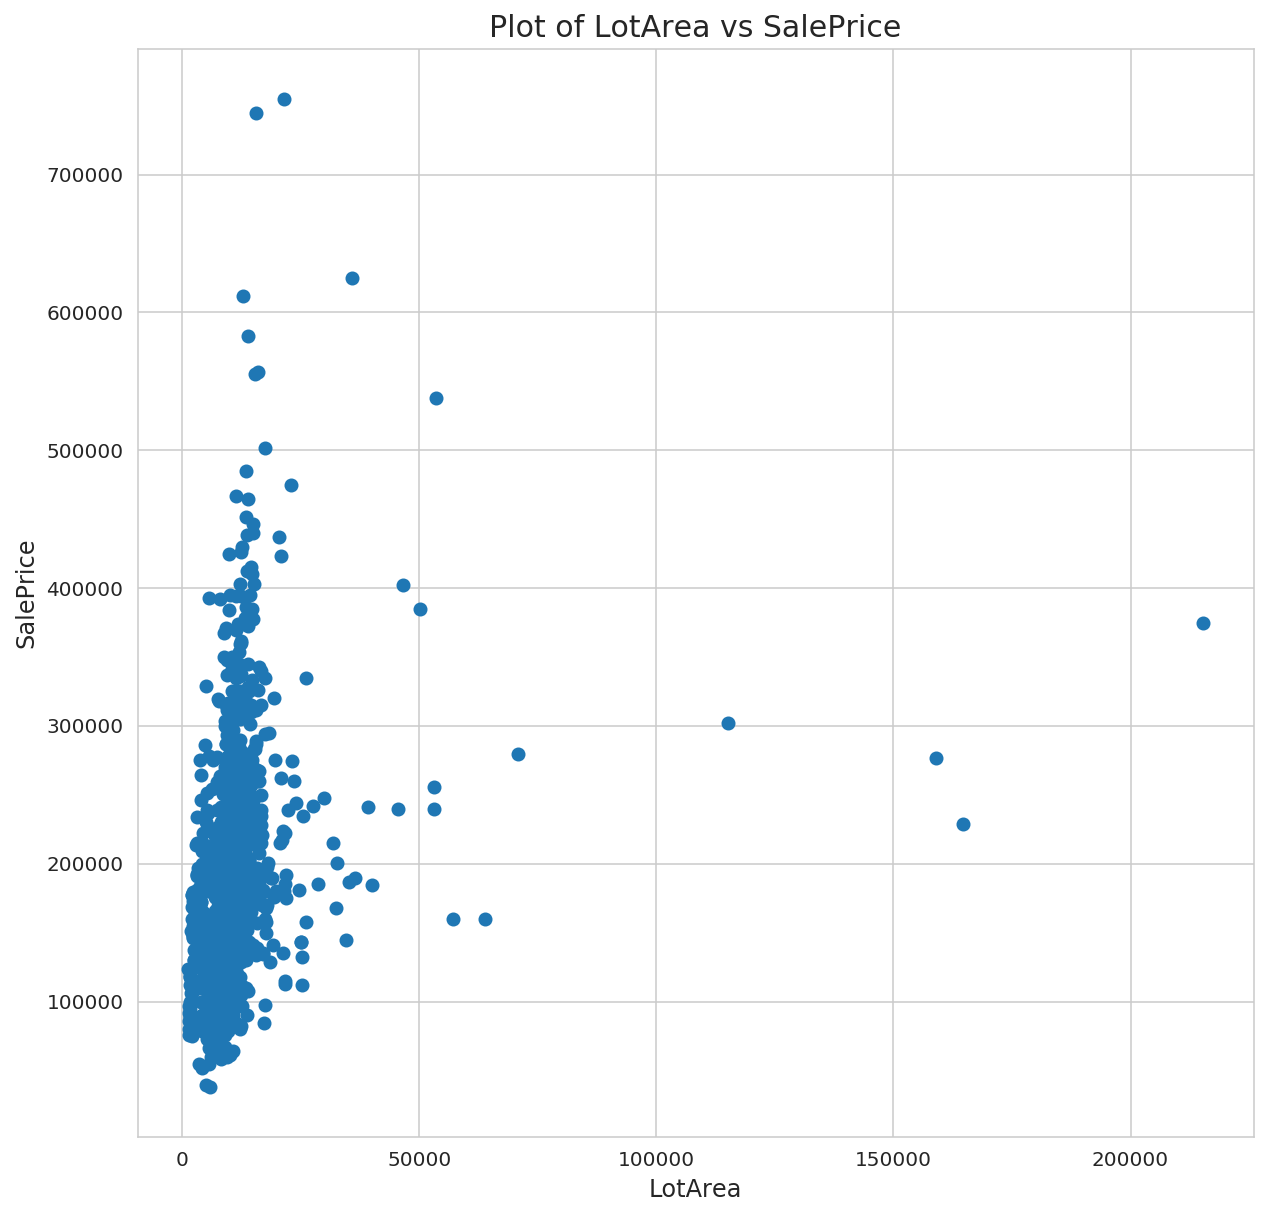

In [84]:
scatter_plot(house.LotArea, house.SalePrice, 'LotArea', 'SalePrice')

plt.show()

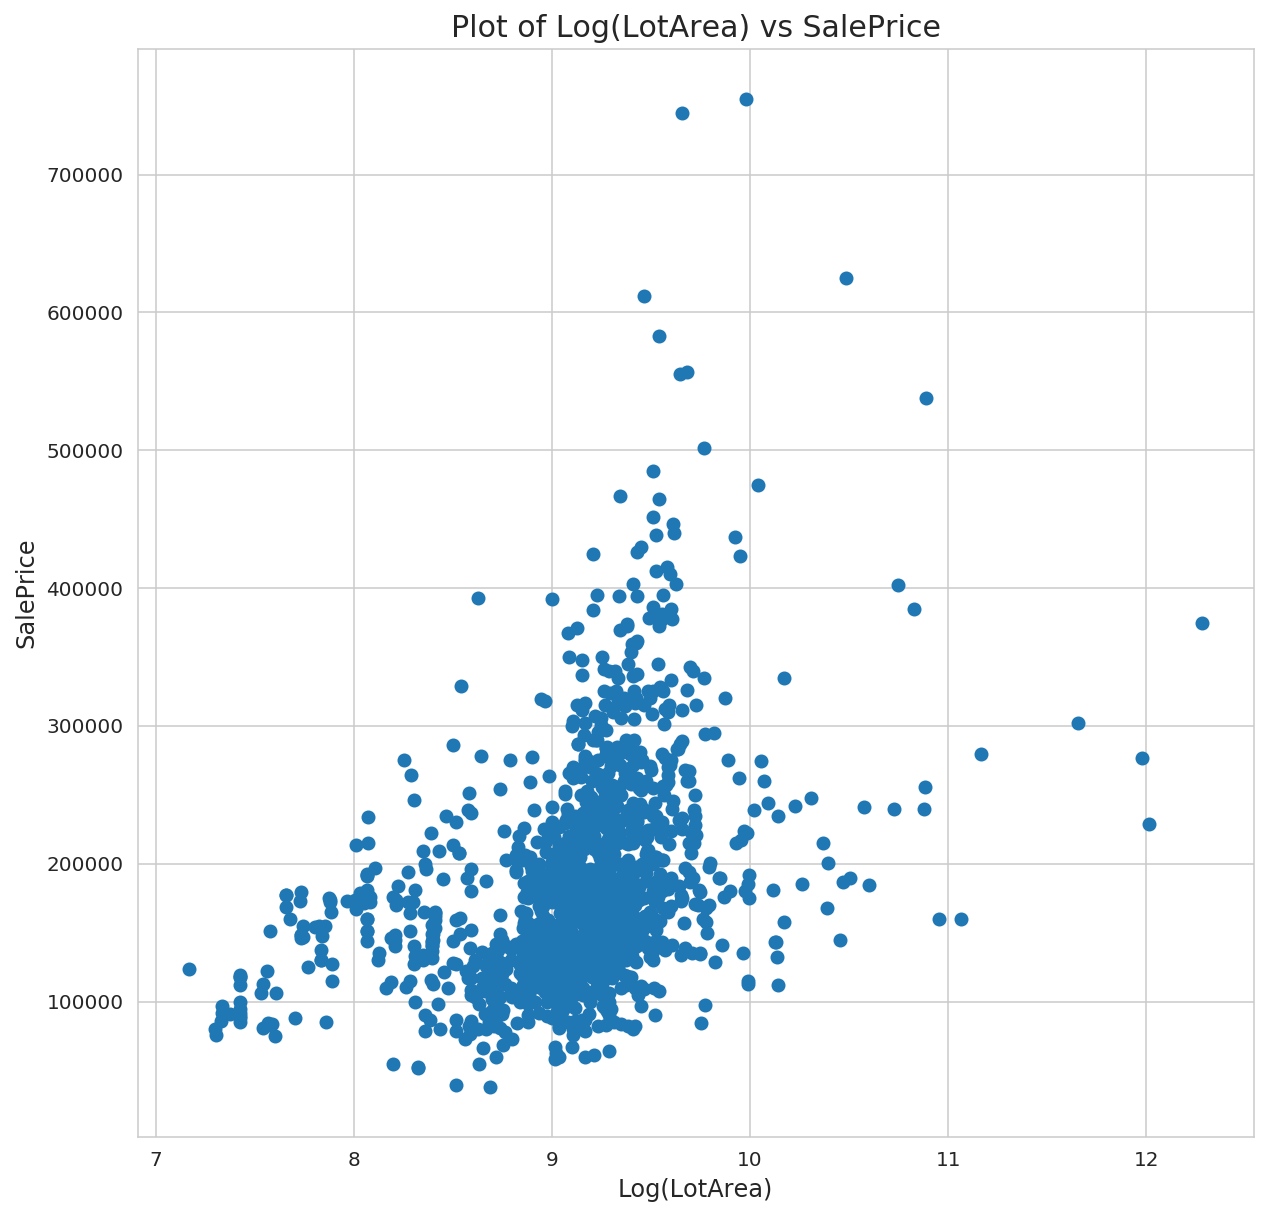

In [83]:
scatter_plot(house.log_LotArea, house.SalePrice, 'Log(LotArea)', 'SalePrice')

plt.show()

<font color='blue'>

Observation: Plot shows better correlation to Sale Price after Log(LotArea)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

<font color='blue'>

Sorry didn't have time to attempt this question.